# Python Forecasting Examples
 - No one-size-fits-all approach for across space, time, models and forecast horizons
 
 - Here, we study a few different models

 - Some dependencies: darts, xarray, netcdf4, h5netcdf

 - In particular, many, many more models + training schemes: https://github.com/unit8co/darts#forecasting-models 

 - Please find many more models used in previous forecasting challenges: https://github.com/Mosqlimate-project/2nd_IMDC_sprint_results

In [ ]:
#On my machine, I had to run:
# pip install h5netcdf
# pip install xarray
# pip install netcdf4


In [8]:
import pandas as pd
import xarray as xr
import seaborn as sns
# from tqdm import tqdm
from scipy.stats import pearsonr
import numpy as np
from sklearn.metrics import r2_score
import os
from darts.models import TCNModel
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer
from darts.models import TFTModel, NBEATSModel
# Assuming 'series' is your TimeSeries object
from darts import concatenate
from darts.utils.callbacks import TFMProgressBar
import shutil
import torch
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import NBEATSModel
from darts.models import AutoARIMA
from darts.models import XGBModel
import warnings
# Suppress warnings
warnings.filterwarnings("ignore")
# 1. Suppress PyTorch Lightning Hardware Messages
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)
logging.getLogger("darts").setLevel(logging.WARNING)
# =============================================================================
# 1. HELPER: Date Alignment
# =============================================================================
def to_month_end(date_series):
    """Aligns dates to the last day of the month."""
    return pd.to_datetime(date_series) + pd.offsets.MonthEnd(0)

## 0. Data Integration

In [3]:
# =============================================================================
# 1. ROBUST DATA INTEGRATION (NetCDF Handling)
# =============================================================================
print("Step 1: Processing Seasonal Forecasts (BRA)...")

# 1. Load Target Data (EPI)
df_epi = pd.read_csv('BRA_epi_training.csv')
df_epi['Region'] = df_epi['Region'].astype(int)
df_epi['Date'] = to_month_end(df_epi['Month'])
df_epi = df_epi.drop(columns=['Month', 'Unnamed: 0'], errors='ignore')
if df_epi.duplicated(subset=['Region', 'Date']).any():
    df_epi = df_epi.groupby(['Region', 'Date']).mean(numeric_only=True).reset_index()

# 2. Process NetCDF (Flattening Leads)
# Define files
fc_file = 'BRA-seasonal_forecast_monthly.zs.nc'
hist_files = {
    'BRA-reanalysis_monthly.zs.nc': None, 
    'BRA-spe06.zs.nc': None,
    'BRA-population.zs.nc': {'population': 'pop_count'}
}

# Merge Base (EPI)
df_final = df_epi.copy()

# A. Process Historical (Standard Merge)
print("  Merging Historical Covariates...")
for f, rename_map in hist_files.items():
    if not os.path.exists(f): continue
    ds = xr.open_dataset(f)
    df_nc = ds.to_dataframe().reset_index()
    ds.close()
    
    # Standardize
    df_nc.rename(columns=lambda x: x.lower() if x in ['time', 'region'] else x, inplace=True)
    df_nc.rename(columns={'time': 'Date', 'region': 'Region'}, inplace=True)
    df_nc['Region'] = pd.to_numeric(df_nc['Region'], errors='coerce')
    df_nc.dropna(subset=['Region'], inplace=True)
    df_nc['Region'] = df_nc['Region'].astype(int)
    df_nc['Date'] = to_month_end(df_nc['Date'])
    
    # Clean
    cols_drop = [c for c in df_nc.columns if c in ['spatial_ref', 'crs', 'bnds', 'month_number']]
    df_nc.drop(columns=cols_drop, inplace=True, errors='ignore')
    
    if rename_map: df_nc.rename(columns=rename_map, inplace=True)
    if df_nc.duplicated(subset=['Region', 'Date']).any():
        df_nc = df_nc.groupby(['Region', 'Date']).mean(numeric_only=True).reset_index()
        
    df_final = pd.merge(df_final, df_nc, on=['Region', 'Date'], how='left')

# B. Process Seasonal Forecasts (The "BRB" Cube)
# Structure: time (Init), month (Lead 1..6), region
print("  Processing Seasonal Forecast Cube (Flattening Leads)...")
# C. Seasonal Forecasts (The Cube -> Flattened Columns)
fc_file = 'BRA-seasonal_forecast_monthly.zs.nc'
fc_cols = []

if os.path.exists(fc_file):
    print("  Flattening Forecast Cube (Leads 1..6)...")
    ds = xr.open_dataset(fc_file)
    df_fc = ds.to_dataframe().reset_index()
    ds.close()
    
    # Standardize
    df_fc.rename(columns=lambda x: x.lower() if x in ['time', 'region', 'month'] else x, inplace=True)
    df_fc.rename(columns={'time': 'Date', 'region': 'Region'}, inplace=True)
    df_fc['Region'] = pd.to_numeric(df_fc['Region'], errors='coerce')
    df_fc.dropna(subset=['Region'], inplace=True)
    df_fc['Region'] = df_fc['Region'].astype(int)
    df_fc['Date'] = to_month_end(df_fc['Date'])
    
    # PIVOT: Turn 'month' (Lead Time) into Columns (t2m_L1, t2m_L2...)
    value_vars = [c for c in df_fc.columns if c not in ['Region', 'Date', 'month', 'spatial_ref', 'crs']]
    
    df_pivoted = df_fc.pivot_table(index=['Region', 'Date'], columns='month', values=value_vars)
    df_pivoted.columns = [f"{col}_L{lead}" for col, lead in df_pivoted.columns]
    df_pivoted = df_pivoted.reset_index()
    
    df_final = pd.merge(df_final, df_pivoted, on=['Region', 'Date'], how='left')
    
    fc_cols = [c for c in df_pivoted.columns if c not in ['Region', 'Date']]
    print(f"  Added {len(fc_cols)} forecast features (e.g., {fc_cols[:3]}).")
else:
    print("  ⚠️ Forecast file not found. Skipping.")

# Interpolate
df_final.sort_values(['Region', 'Date'], inplace=True)
if 'pop_count' in df_final.columns:
    df_final['pop_count'] = df_final.groupby('Region')['pop_count'].transform(lambda x: x.interpolate(limit_direction='both'))
if fc_cols:
    df_final[fc_cols] = df_final.groupby('Region')[fc_cols].transform(lambda x: x.fillna(method='ffill'))


#IMPORTANT NOTE:
# We'll use log(cases + 1) throughout for fitting, evaluation, and visualisation
df_final['LogCases'] = np.log1p(df_final['Cases'])


# Final Save
df_final.sort_values(by=['Region', 'Date'], inplace=True)
outfile = 'BRA_integrated_forecasting_data.csv'
df_final.to_csv(outfile, index=False)

print("\n--- Final Dataset Columns ---")
print(df_final.columns.tolist())
print(f"Success! Saved to {outfile}")

Step 1: Processing Seasonal Forecasts (BRA)...
  Merging Historical Covariates...
  Processing Seasonal Forecast Cube (Flattening Leads)...
  Flattening Forecast Cube (Leads 1..6)...
  Added 30 forecast features (e.g., ['mn2t24_L1.0', 'mn2t24_L2.0', 'mn2t24_L3.0']).

--- Final Dataset Columns ---
['Country', 'Region', 'Cases', 'Spatial_Resolution', 'Date', 't2m', 'rh', 'tp', 'spe06', 'pop_count', 'area', 'pop_density', 'mn2t24_L1.0', 'mn2t24_L2.0', 'mn2t24_L3.0', 'mn2t24_L4.0', 'mn2t24_L5.0', 'mn2t24_L6.0', 'mx2t24_L1.0', 'mx2t24_L2.0', 'mx2t24_L3.0', 'mx2t24_L4.0', 'mx2t24_L5.0', 'mx2t24_L6.0', 'rh_L1.0', 'rh_L2.0', 'rh_L3.0', 'rh_L4.0', 'rh_L5.0', 'rh_L6.0', 't2m_L1.0', 't2m_L2.0', 't2m_L3.0', 't2m_L4.0', 't2m_L5.0', 't2m_L6.0', 'tp_L1.0', 'tp_L2.0', 'tp_L3.0', 'tp_L4.0', 'tp_L5.0', 'tp_L6.0', 'LogCases']
Success! Saved to BRA_integrated_forecasting_data.csv


In [4]:
df_final.head()

,Country,Region,Cases,Spatial_Resolution,Date,t2m,rh,tp,spe06,pop_count,...,t2m_L4.0,t2m_L5.0,t2m_L6.0,tp_L1.0,tp_L2.0,tp_L3.0,tp_L4.0,tp_L5.0,tp_L6.0,LogCases
0,BRAZIL,1100015,1,Admin 2,2014-12-31,NaN,NaN,NaN,NaN,24599.201863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147
1,BRAZIL,1100015,12,Admin 2,2015-01-31,297.628837,0.883355,0.027984,0.604961,24599.201863,...,297.829534,297.540846,297.150224,0.796062,0.804263,0.831304,0.476248,0.191497,0.067469,2.564949
2,BRAZIL,1100015,20,Admin 2,2015-02-28,297.745730,0.883954,0.027113,0.488125,24585.172967,...,297.553797,297.256606,297.995341,0.703709,0.756392,0.521663,0.211014,0.088883,0.053763,3.044522
3,BRAZIL,1100015,56,Admin 2,2015-03-31,297.692512,0.901911,0.027866,0.736242,24571.144070,...,297.455812,298.279801,299.984514,0.803096,0.532766,0.227263,0.053779,0.057806,0.125051,4.043051
4,BRAZIL,1100015,31,Admin 2,2015-04-30,297.978838,0.899102,0.022900,1.704725,24557.115174,...,298.114492,299.519818,300.603329,0.505449,0.250108,0.068888,0.082493,0.121574,0.263081,3.465736


Selected Region: 3115458


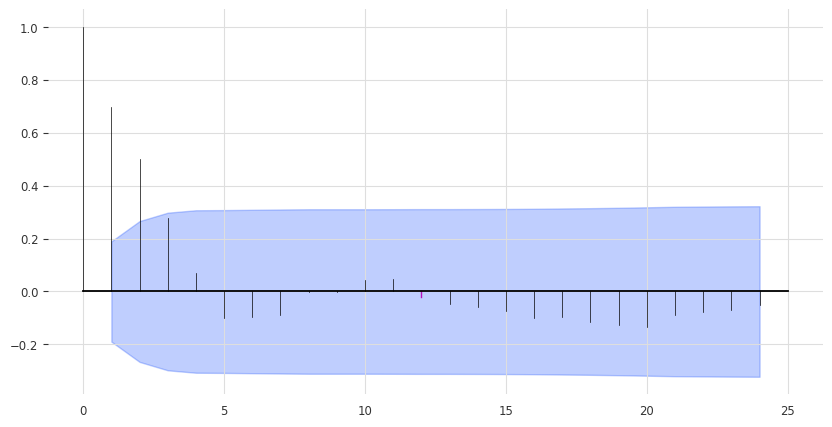

In [ ]:
from darts.utils.statistics import check_seasonality, plot_acf
random_region = np.random.choice(df_final['Region'].unique())
print(f"Selected Region: {random_region}")

# 2. Filter data for this region
df_region = df_final[df_final['Region'] == random_region].sort_values('Date')

series = TimeSeries.from_dataframe(
    df_region, 
    time_col='Date', 
    value_cols='LogCases',
    freq='ME'  # 'ME' = Month End (pandas 2.2+ standard)
)
plot_acf(series, m=12, alpha=0.05, max_lag=24)

In [15]:
# =============================================================================
# 2. NA CHECK (Post-2016)
# =============================================================================
print("\nStep 2: Checking for Missing Values (Date > 2016-12-31)...")
df_check = df_final[df_final['Date'] > '2016-12-31']
na_counts = df_check.isna().sum()
na_cols = na_counts[na_counts > 0]

if len(na_cols) == 0:
    print("✅ SUCCESS: No missing values found in any variable after 2016.")
else:
    print(f"⚠️ WARNING: Found missing values in {len(na_cols)} columns:")
    print(na_cols)
    print("  (Note: Minor gaps in weather data usually handled by TCN/XGBoost or interpolation)")


Step 2: Checking for Missing Values (Date > 2016-12-31)...
⚠️ WARNING: Found missing values in 3 columns:
pop_count           7
area           416857
pop_density    416857
dtype: int64
  (Note: Minor gaps in weather data usually handled by TCN/XGBoost or interpolation)



Step 3: Generating Tile Plots...


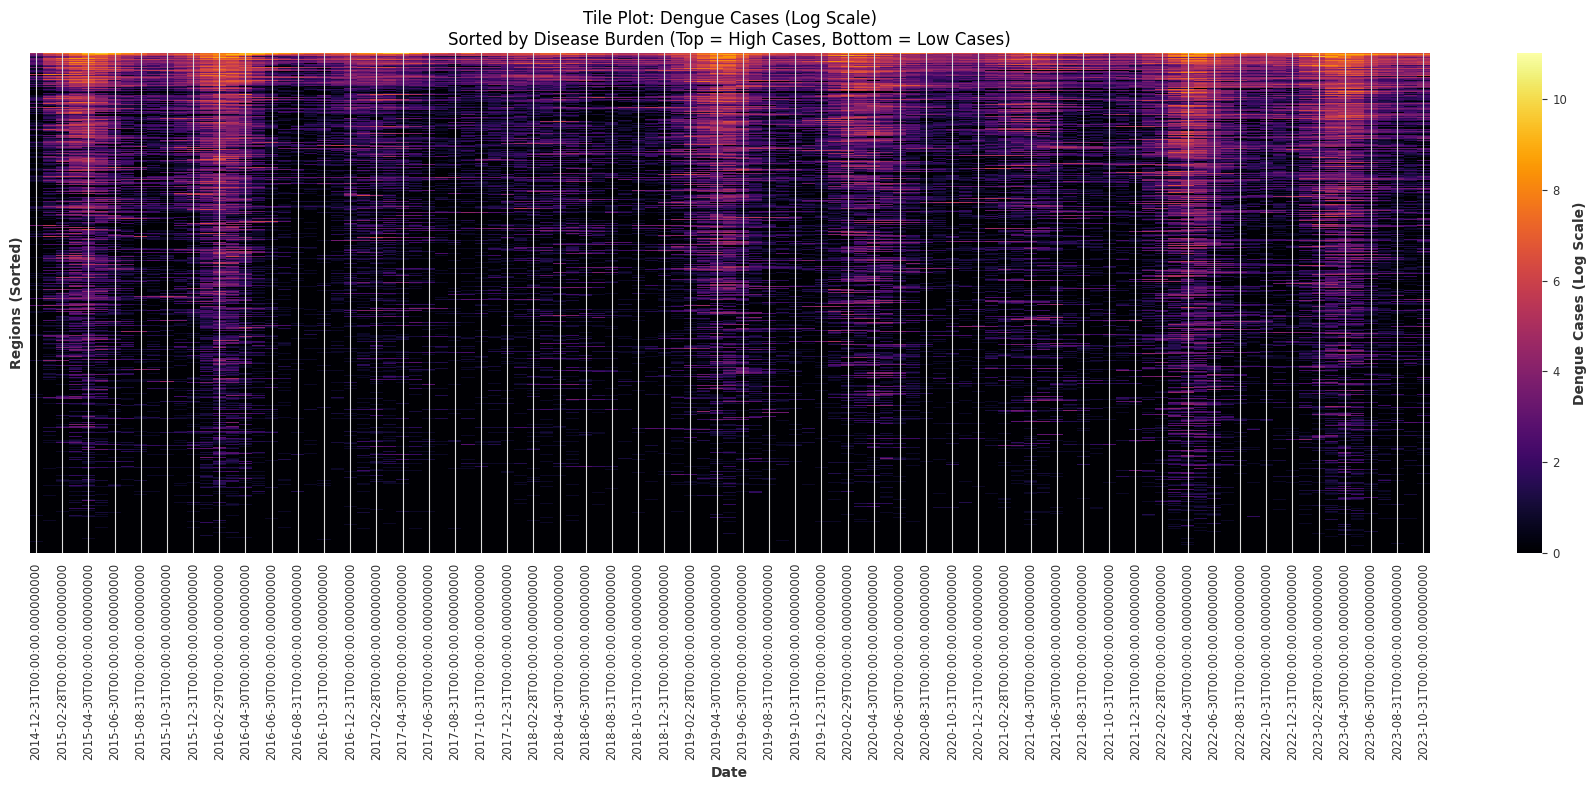

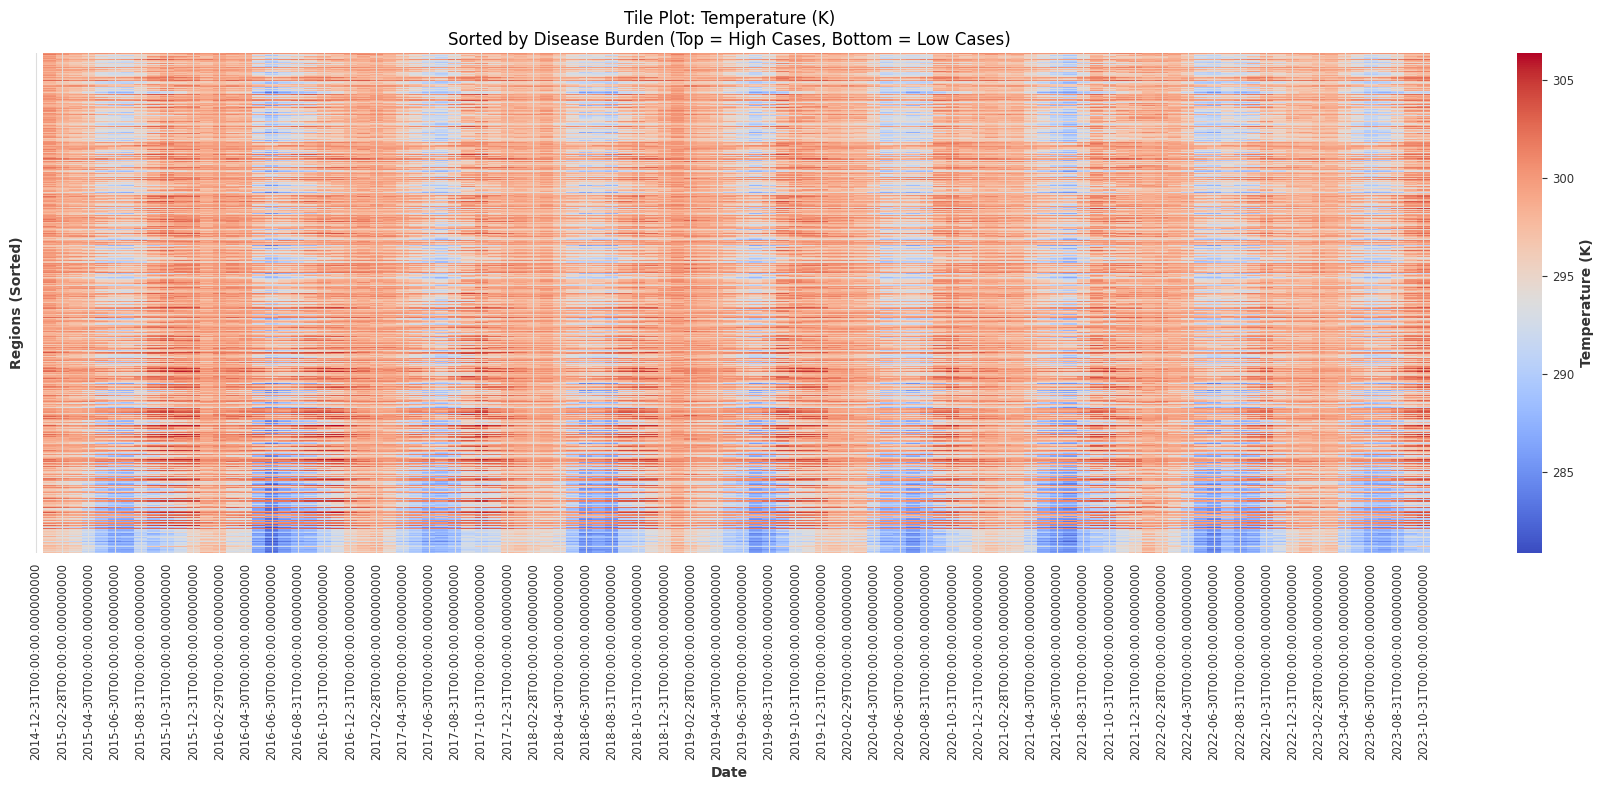

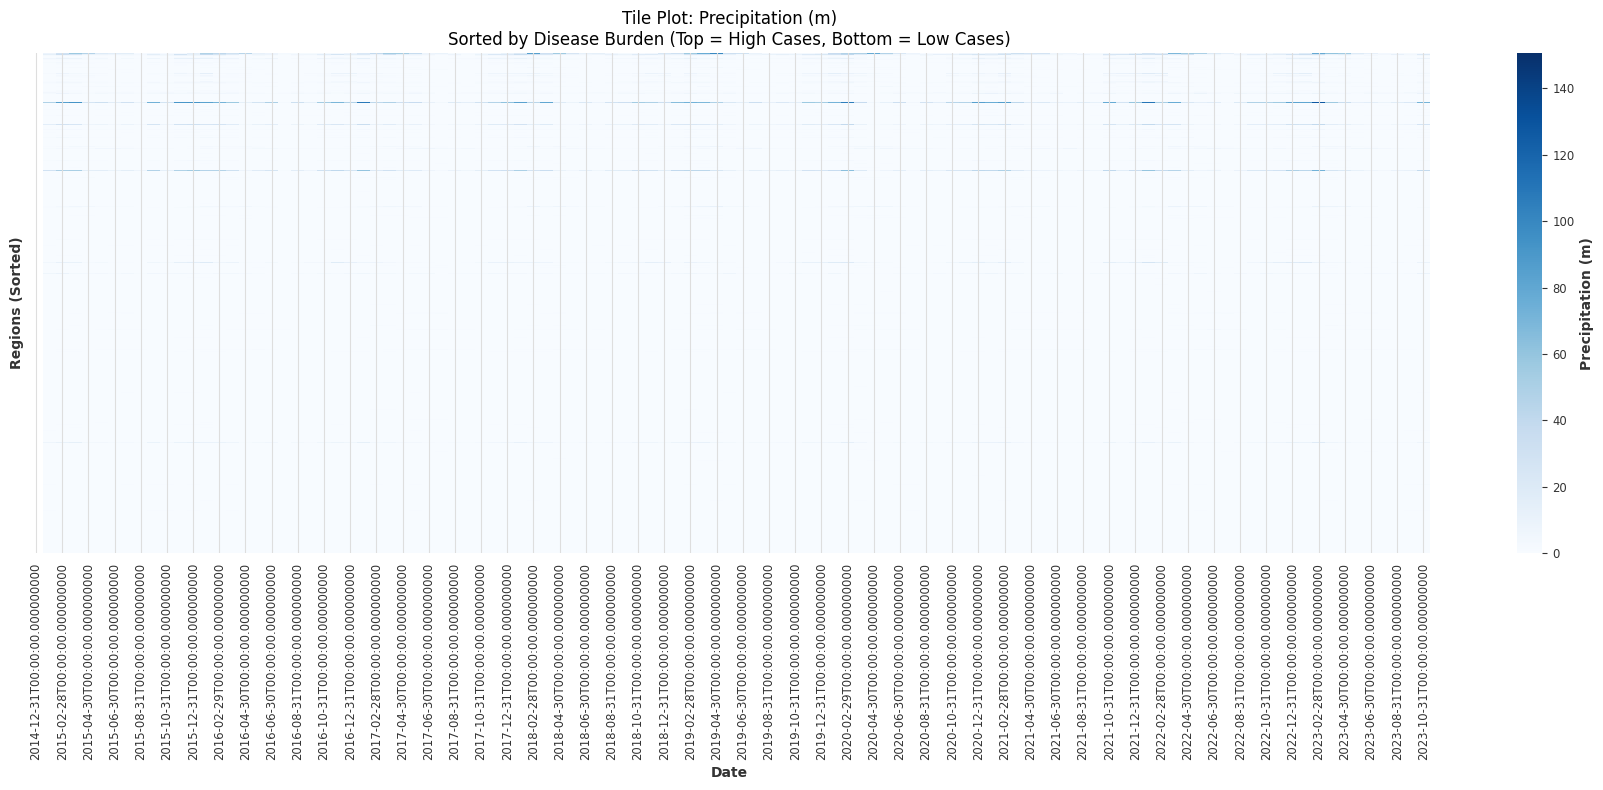

In [6]:
# =============================================================================
# 3. VISUALIZATION (Tile Plots)
# =============================================================================
print("\nStep 3: Generating Tile Plots...")

# Sort Regions by Total Burden (Cases)
burden = df_final.groupby('Region')['Cases'].sum().sort_values(ascending=False)
sorted_regions = burden.index.tolist()

# Define Plots
plot_configs = [
    {'col': 'Cases', 'title': 'Dengue Cases (Log Scale)', 'cmap': 'inferno', 'log': True},
    {'col': 't2m',   'title': 'Temperature (K)',          'cmap': 'coolwarm', 'log': False},
    {'col': 'tp',    'title': 'Precipitation (m)',        'cmap': 'Blues',    'log': False},
    {'col': 'spei',  'title': 'Drought Index (SPEI)',     'cmap': 'BrBG',     'log': False}, # Brown=Dry
    {'col': 'gdp_pc','title': 'GDP per Capita (Log)',     'cmap': 'viridis',  'log': True}
]

for cfg in plot_configs:
    col = cfg['col']
    if col not in df_final.columns: continue
    
    # Pivot Data for Heatmap
    # Rows: Regions (Sorted), Cols: Date
    pivot_val = np.log1p(df_final[col]) if cfg['log'] else df_final[col]
    
    heatmap_data = df_final.pivot(index='Region', columns='Date', values=col)
    
    # If log scale requested, apply it to the pivoted data
    if cfg['log']:
        heatmap_data = np.log1p(heatmap_data)
        
    # Reindex rows to match burden sort order
    heatmap_data = heatmap_data.reindex(sorted_regions)
    
    # Plot
    plt.figure(figsize=(18, 8))
    # Using rasterized=True for speed with large grids
    sns.heatmap(heatmap_data, cmap=cfg['cmap'], cbar_kws={'label': cfg['title']}, rasterized=True)
    
    plt.title(f"Tile Plot: {cfg['title']}\nSorted by Disease Burden (Top = High Cases, Bottom = Low Cases)")
    plt.ylabel("Regions (Sorted)")
    plt.xlabel("Date")
    plt.yticks([]) # Hide 5000+ labels for clarity
    plt.tight_layout()
    plt.show()

## 1. A start to forecasting
- In this hackathon, we will only produce forecasts for **one**, **three**, and **six** month **horizons**
- Please ensure that these forecasts only include historical covariates and any forecasted covariates - no **data leakage**

In [5]:
#If required:
#pip install statsforecast, 
from tqdm import tqdm
from scipy.stats import pearsonr
#Now, let's do fitting + evaluation with WIS
# I'm going to use stride length of 6 to keep things quick

# =============================================================================
# 0. HELPER: WEIGHTED INTERVAL SCORE (WIS)
# =============================================================================
def calculate_wis_scalar(actual, q_dict):
    """
    Computes WIS for a single observation on Log Scale.
    q_dict: dictionary {0.01: val, ..., 0.5: median, ..., 0.99: val}
    """
    if pd.isna(actual): return np.nan
    qs = sorted(q_dict.keys())
    K = len(qs) // 2
    median = q_dict[0.5]
    wis_sum = 0.5 * abs(actual - median)
    for k in range(K):
        alpha = 2 * qs[k]
        L = q_dict[qs[k]]
        U = q_dict[qs[-(k+1)]]
        score = (U - L)
        if actual < L: score += (2/alpha) * (L - actual)
        if actual > U: score += (2/alpha) * (actual - U)
        wis_sum += score
    return wis_sum / (K + 0.5)

def caret_r2(obs, pred):
    """
    Calculates R2 as the square of the Pearson correlation coefficient.
    Formula used by R's caret package.
    """
    if len(obs) < 2: return np.nan
    # Pearsonr requires at least 2 points and non-constant input
    if np.std(obs) == 0 or np.std(pred) == 0: return 0.0
    r, _ = pearsonr(obs, pred)
    return r**2


## SARIMA - i 
- Let's fit a very simple yet flexible time series model to a single time point, single location, and all horizons
- We'll select a random region and cutoff date
- Throughout, we recommend fitting, evaluating, and visualising using log(Cases + 1), or alternatively use Dengue Incidence Rate, DIR:= Cases/Pop*1000

Selected Region: 5003256
Selected Cutoff Date (Training ends): 2021-04-30

Fitting Auto-SARIMA model (this finds best p,d,q automatically)...
Generating forecasts...

FORECAST REPORT FOR REGION 5003256
Forecast Origin: 2021-04-30
1-Month Ahead (2021-04-30): 2.6 Cases
3-Month Ahead (2021-06-30): 2.1 Cases
6-Month Ahead (2021-09-30): 2.6 Cases


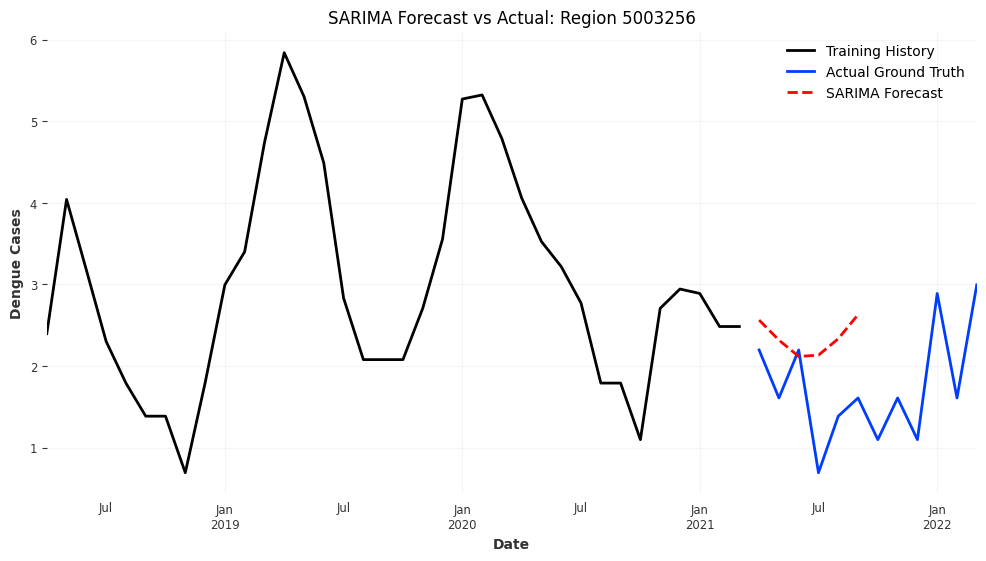

In [ ]:
# =============================================================================
# 1. Pick a random region, or choose one of interest!
random_region = np.random.choice(df_final['Region'].unique())
print(f"Selected Region: {random_region}")

# 2. Filter data for this region
df_region = df_final[df_final['Region'] == random_region].sort_values('Date')

# 3. Pick a random 'cutoff' date (The "Today" of our simulation)
# We'll ensure we have at least 24 months of history to train on
# and at least 6 months of future data to compare against.
valid_dates = df_region['Date'].unique()

if len(valid_dates) > 30:
    # Pick a date somewhere in the middle (avoiding the very start/end)
    cutoff_idx = np.random.randint(24, len(valid_dates) - 6)
    cutoff_date = valid_dates[cutoff_idx]
else:
    # Fallback for short series
    cutoff_date = valid_dates[len(valid_dates) - 7]

print(f"Selected Cutoff Date (Training ends): {pd.to_datetime(cutoff_date).date()}")


# =============================================================================
# 3. Prepare Darts TimeSeries
#Darts requires this specific format for all models, so worth getting used to!
# =============================================================================

series = TimeSeries.from_dataframe(
    df_region, 
    time_col='Date', 
    value_cols='LogCases',
    freq='ME'  # 'ME' = Month End (pandas 2.2+ standard)
)


# Interpolate small gaps (SARIMA fails on NaNs)
series = fill_missing_values(series)

# Split the data: Train (up to cutoff) vs Validation (after cutoff)
train, val = series.split_before(pd.Timestamp(cutoff_date))



# =============================================================================
# 4. Fit Auto-SARIMA Model
# =============================================================================
print("\nFitting Auto-SARIMA model (this finds best p,d,q automatically)...")

# season_length=12 tells it to look for annual patterns (Monthly data)
model = AutoARIMA(season_length=12)
model.fit(train)

# =============================================================================
# 5. Generate Forecast (Horizon = 6 months)
# =============================================================================
print("Generating forecasts...")
forecast = model.predict(n=6)

# Extract specific horizons (1, 3, 6 months ahead)
# Note: forecast[0] is t+1, forecast[2] is t+3, forecast[5] is t+6
pred_1 = forecast[0]
pred_3 = forecast[2]
pred_6 = forecast[5]

# =============================================================================
# 6. Report & Visualize
# =============================================================================
print("\n" + "="*40)
print(f"FORECAST REPORT FOR REGION {random_region}")
print(f"Forecast Origin: {pd.to_datetime(cutoff_date).date()}")
print("="*40)
print(f"1-Month Ahead ({pred_1.time_index[0].date()}): {pred_1.values()[0][0]:.1f} Cases")
print(f"3-Month Ahead ({pred_3.time_index[0].date()}): {pred_3.values()[0][0]:.1f} Cases")
print(f"6-Month Ahead ({pred_6.time_index[0].date()}): {pred_6.values()[0][0]:.1f} Cases")


# Plot
plt.figure(figsize=(12, 6))
train.tail(36).plot(label='Training History')
val.head(12).plot(label='Actual Ground Truth')
forecast.plot(label='SARIMA Forecast', linestyle='--', color='red')
plt.title(f"SARIMA Forecast vs Actual: Region {random_region}")
plt.xlabel("Date")
plt.ylabel("Dengue Cases")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## SARIMA - ii
- Now, let's fit a simple model to all time points in 2020-2022, still for a single location, and all horizons
- We'll select the same random region again


Starting Rolling Forecast for 36 time points...
Period: 2020-01-31 to 2022-12-31
  Processed cutoff: 2020-06-30
  Processed cutoff: 2020-12-31
  Processed cutoff: 2021-06-30
  Processed cutoff: 2021-12-31
  Processed cutoff: 2022-06-30
  Processed cutoff: 2022-12-31

=== FORECAST PERFORMANCE (RMSE) ===
1-Month Horizon: 36.75
3-Month Horizon: 37.21
6-Month Horizon: 70.83


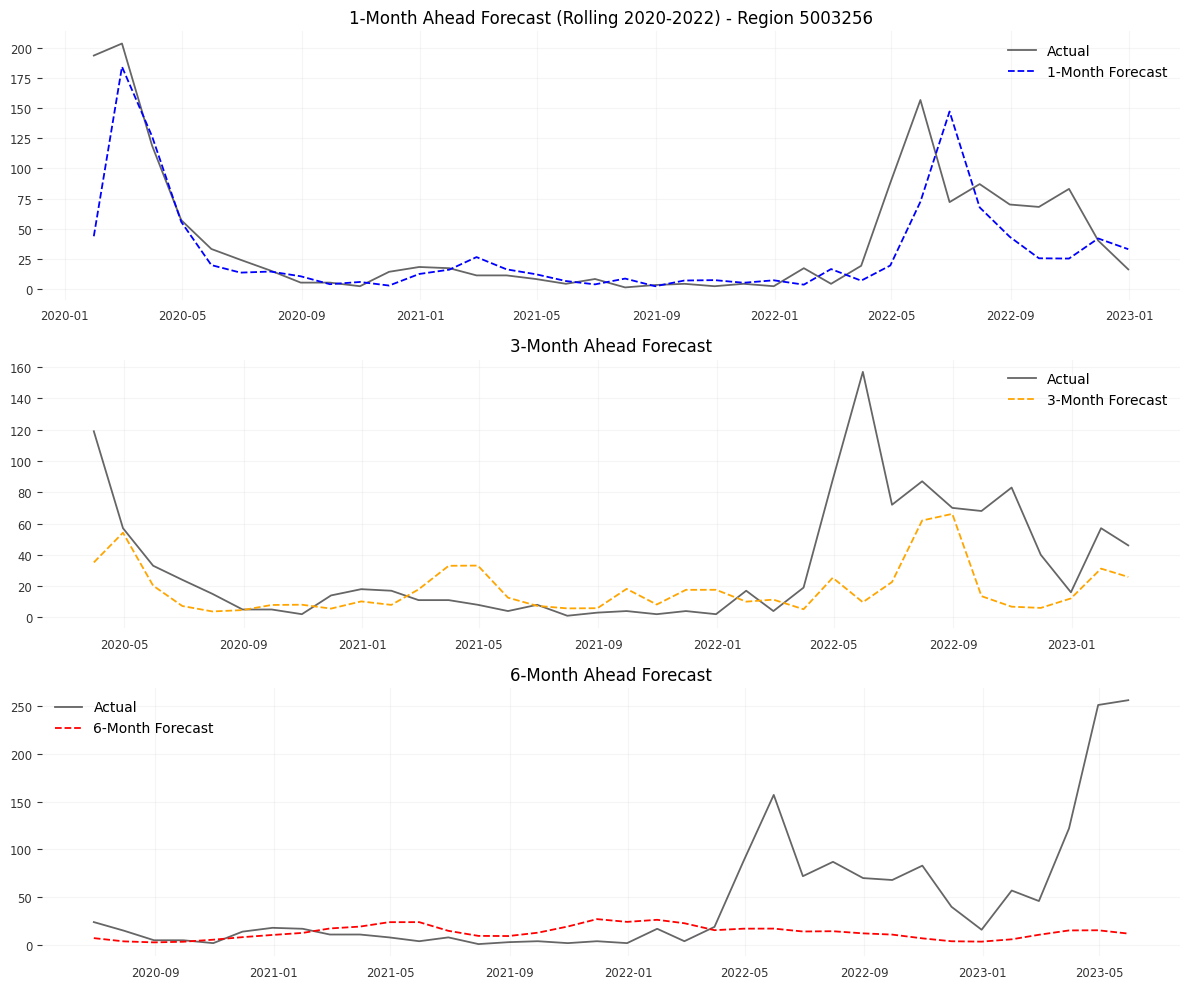

In [ ]:
#All time points
# Filter
df_region = df_final[df_final['Region'] == random_region].sort_values('Date')

# Apply Log Transform: log(Cases + 1)
# We do this in pandas before creating the TimeSeries for simplicity
df_region['LogCases'] = np.log1p(df_region['Cases'])

# Create Darts Series
series_log = TimeSeries.from_dataframe(
    df_region, 
    time_col='Date', 
    value_cols='LogCases',
    freq='ME' # Month End
)

# Handle Missing Values (Interpolate Log Values)
series_log = fill_missing_values(series_log)

# =============================================================================
# 2. Define Rolling Backtest Parameters
# =============================================================================
# Define the Evaluation Window (origins)
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")

# Generate monthly cutoff dates
cutoff_dates = pd.date_range(start=start_date, end=end_date, freq='ME')

results = []

print(f"\nStarting Rolling Forecast for {len(cutoff_dates)} time points...")
print(f"Period: {start_date.date()} to {end_date.date()}")

# =============================================================================
# 3. Execution Loop
# =============================================================================
model = AutoARIMA() # Initialize once

for cutoff in cutoff_dates:
    # 1. Split Data: Train on everything UP TO this cutoff
    train, _ = series_log.split_before(cutoff)
    
    # Ensure we have enough history (e.g., at least 24 months)
    if len(train) < 24:
        continue

    # 2. Fit Model (Refit every step for reliability)
    # Using 'suppress_warnings=True' to keep output clean
    model.fit(train)
    
    # 3. Predict 6 steps ahead
    pred_log = model.predict(n=6)
    
    # 4. Extract Targets (t+1, t+3, t+6)
    # Inverse Transform: exp(x) - 1
    # We use expm1 for precision
    
    # Horizon 1 (1 month ahead)
    h1_log = pred_log.values()[0][0]
    h1_val = np.expm1(h1_log)
    h1_date = pred_log.time_index[0]
    
    # Horizon 3 (3 months ahead)
    h3_log = pred_log.values()[2][0]
    h3_val = np.expm1(h3_log)
    h3_date = pred_log.time_index[2]
    
    # Horizon 6 (6 months ahead)
    h6_log = pred_log.values()[5][0]
    h6_val = np.expm1(h6_log)
    h6_date = pred_log.time_index[5]
    
    # 5. Get Actuals (Ground Truth) for comparison
    # We look up the actual value in the original series at the forecast date
    try:
        actual_h1 = np.expm1(series_log[h1_date].values()[0][0])
    except:
        actual_h1 = np.nan
        
    try:
        actual_h3 = np.expm1(series_log[h3_date].values()[0][0])
    except:
        actual_h3 = np.nan
        
    try:
        actual_h6 = np.expm1(series_log[h6_date].values()[0][0])
    except:
        actual_h6 = np.nan

    # Store
    results.append({
        'Origin_Date': cutoff,
        'Region': random_region,
        'Pred_H1': h1_val, 'Actual_H1': actual_h1, 'Date_H1': h1_date,
        'Pred_H3': h3_val, 'Actual_H3': actual_h3, 'Date_H3': h3_date,
        'Pred_H6': h6_val, 'Actual_H6': actual_h6, 'Date_H6': h6_date
    })
    
    # Optional: Print progress every 6 months
    if cutoff.month % 6 == 0:
        print(f"  Processed cutoff: {cutoff.date()}")

# =============================================================================
# 4. Analysis & Visualization
# =============================================================================
res_df = pd.DataFrame(results)

# Calculate Errors (RMSE)
rmse_h1 = np.sqrt(np.mean((res_df['Pred_H1'] - res_df['Actual_H1'])**2))
rmse_h3 = np.sqrt(np.mean((res_df['Pred_H3'] - res_df['Actual_H3'])**2))
rmse_h6 = np.sqrt(np.mean((res_df['Pred_H6'] - res_df['Actual_H6'])**2))

print("\n=== FORECAST PERFORMANCE (RMSE) ===")
print(f"1-Month Horizon: {rmse_h1:.2f}")
print(f"3-Month Horizon: {rmse_h3:.2f}")
print(f"6-Month Horizon: {rmse_h6:.2f}")

# Plotting the Backtest
plt.figure(figsize=(12, 10))

# Plot 1: 1-Month Ahead Performance
plt.subplot(3, 1, 1)
plt.plot(res_df['Date_H1'], res_df['Actual_H1'], label='Actual', color='black', alpha=0.6)
plt.plot(res_df['Date_H1'], res_df['Pred_H1'], label='1-Month Forecast', color='blue', linestyle='--')
plt.title(f"1-Month Ahead Forecast (Rolling 2020-2022) - Region {random_region}")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: 3-Month Ahead Performance
plt.subplot(3, 1, 2)
plt.plot(res_df['Date_H3'], res_df['Actual_H3'], label='Actual', color='black', alpha=0.6)
plt.plot(res_df['Date_H3'], res_df['Pred_H3'], label='3-Month Forecast', color='orange', linestyle='--')
plt.title("3-Month Ahead Forecast")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: 6-Month Ahead Performance
plt.subplot(3, 1, 3)
plt.plot(res_df['Date_H6'], res_df['Actual_H6'], label='Actual', color='black', alpha=0.6)
plt.plot(res_df['Date_H6'], res_df['Pred_H6'], label='6-Month Forecast', color='red', linestyle='--')
plt.title("6-Month Ahead Forecast")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SARIMA - iii
- Let's fit a simple model to all time points in 2020-2022, **many locations**, and all horizons

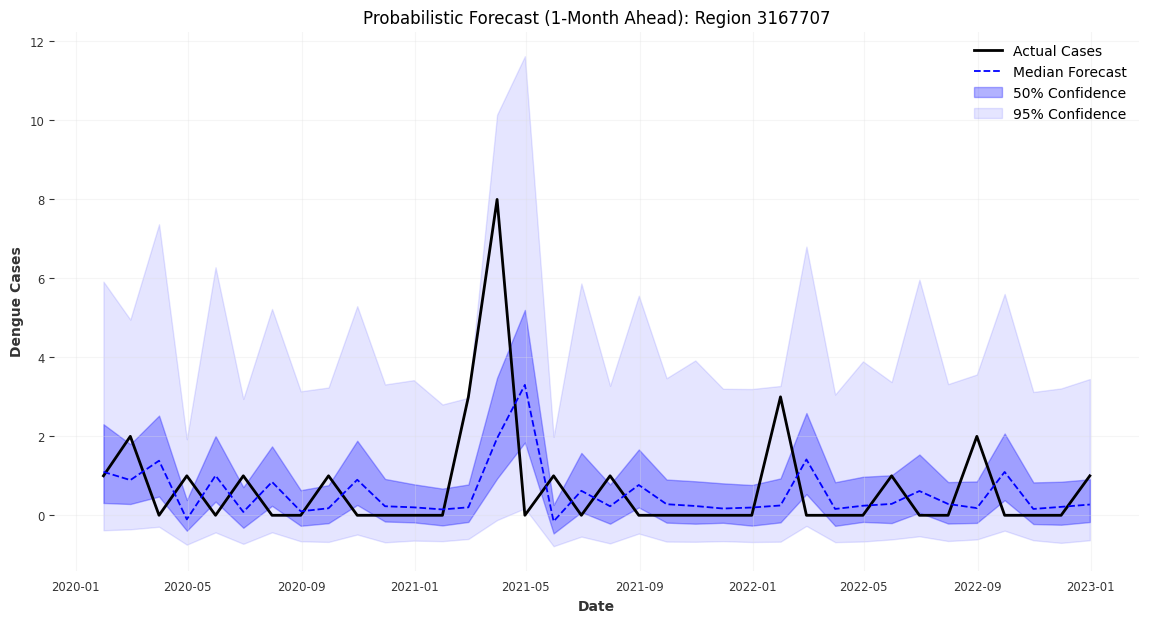

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm  # Progress bar
from darts import TimeSeries
from darts.models import AutoARIMA
from darts.utils.missing_values import fill_missing_values


# =============================================================================
# 1. CONFIGURATION
# =============================================================================
# Quantiles requested
QUANTILES = [0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 
             0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 
             0.850, 0.900, 0.950, 0.975, 0.990]

# Date Range for Rolling Backtest
START_DATE = pd.Timestamp("2020-01-31")
END_DATE   = pd.Timestamp("2022-12-31")

# *** CRITICAL: Set a limit for testing. Set to None to run ALL regions. ***
#Not a problem for smaller nations + for ADM0/ADM1 nations!
REGION_LIMIT = 25  

# =============================================================================
# 2. DATA PREPARATION
# =============================================================================
print("Loading and preparing data...")
# df = pd.read_csv('BRA_integrated_forecasting_data.csv')
# df['Date'] = pd.to_datetime(df['Date'])

# Get list of regions
all_regions = df_final['Region'].unique()
if REGION_LIMIT:
    target_regions = np.random.choice(all_regions, REGION_LIMIT, replace=False)
    print(f"⚠️ TESTING MODE: Processing only {REGION_LIMIT} random regions: {target_regions}")
else:
    target_regions = all_regions
    print(f"🚀 PRODUCTION MODE: Processing ALL {len(target_regions)} regions (This will take a long time!)")

results_master = []

# =============================================================================
# 3. MAIN FORECASTING LOOP
# =============================================================================
# Initialize Model
model = AutoARIMA()

for region in tqdm(target_regions, desc="Regions"):
    # Filter & Sort
    df_reg = df_final[df_final['Region'] == region].sort_values('Date')
    
    # 1. Log Transform
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    
    # 2. Create TimeSeries
    ts = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts = fill_missing_values(ts)
    
    # 3. Define Cutoff Dates for this region
    cutoffs = pd.date_range(start=START_DATE, end=END_DATE, freq='ME')
    
    for cutoff in cutoffs:
        # Check if date exists in data range
        if cutoff > ts.end_time() or cutoff < ts.start_time():
            continue
            
        # Split Data
        train, val = ts.split_before(cutoff)
        
        # Minimum history check (e.g. 24 months)
        if len(train) < 24:
            continue
            
        # FIT MODEL (Refitting every step)
        try:
            model.fit(train)
            
            # PREDICT with SAMPLES
            # num_samples=500 creates a distribution we can calc quantiles from
            pred_samples = model.predict(n=6, num_samples=500)
            
            # EXTRACT QUANTILES & INVERSE TRANSFORM
            # We iterate through horizons h=1, h=3, h=6
            for step, horizon in enumerate([1, 3, 6]):
                if step >= len(pred_samples): break # Safety check
                
                # Get the slice for this horizon (t+h)
                # pred_samples is a list of TimeSeries if n>1? No, it's one TimeSeries with length n.
                # We access the specific time step
                pred_slice = pred_samples[step] 
                
                # Calculate Quantiles on LOG scale
                q_values_log = {}
                for q in QUANTILES:
                    # Darts quantile() returns a TimeSeries, we get the value
                    val_log = pred_slice.quantile(q).values()[0][0]
                    q_values_log[q] = val_log
                
                # Inverse Transform (expm1)
                q_values_real = {f"q_{q:.3f}": np.expm1(v) for q, v in q_values_log.items()}
                
                # Get Actual Value (if available)
                forecast_date = pred_slice.time_index[0]
                try:
                    actual_log = ts[forecast_date].values()[0][0]
                    actual_real = np.expm1(actual_log)
                except:
                    actual_real = np.nan
                
                # Store Row
                row = {
                    'Region': region,
                    'Origin_Date': cutoff,
                    'Forecast_Date': forecast_date,
                    'Horizon': horizon,
                    'Actual': actual_real
                }
                row.update(q_values_real) # Add all quantiles columns
                results_master.append(row)
                
        except Exception as e:
            # Catch convergence errors
            continue

# =============================================================================
# 4. SUMMARIES & EVALUATION
# =============================================================================
res_df = pd.DataFrame(results_master)

if res_df.empty:
    print("No forecasts generated. Check data range or minimum history settings.")
else:
    # A. Calculate Errors (RMSE on Median)
    res_df['Error_Median'] = res_df['q_0.500'] - res_df['Actual']
    res_df['Sq_Error'] = res_df['Error_Median']**2
    
    rmse = np.sqrt(res_df['Sq_Error'].mean())
    mae = res_df['Error_Median'].abs().mean()
    
    # B. Calculate Coverage (95% Interval: q0.025 to q0.975)
    res_df['In_95_Interval'] = (res_df['Actual'] >= res_df['q_0.025']) & \
                               (res_df['Actual'] <= res_df['q_0.975'])
    coverage_95 = res_df['In_95_Interval'].mean()
    
    # C. Calculate Coverage (50% Interval: q0.250 to q0.750)
    res_df['In_50_Interval'] = (res_df['Actual'] >= res_df['q_0.250']) & \
                               (res_df['Actual'] <= res_df['q_0.750'])
    coverage_50 = res_df['In_50_Interval'].mean()

    print("\n" + "="*30)
    print("FINAL MODEL SUMMARY")
    print("="*30)
    print(f"Total Forecasts Generated: {len(res_df)}")
    print(f"RMSE (Median Forecast):    {rmse:.2f}")
    print(f"MAE (Median Forecast):     {mae:.2f}")
    print("-" * 30)
    print(f"95% Interval Coverage:     {coverage_95:.1%} (Target: 95.0%)")
    print(f"50% Interval Coverage:     {coverage_50:.1%} (Target: 50.0%)")
    print("="*30)

# =============================================================================
# 5. VISUALIZATION (Sample Region)
# =============================================================================
if not res_df.empty:
    sample_region = res_df['Region'].unique()[2]
    viz_df = res_df[(res_df['Region'] == sample_region) & (res_df['Horizon'] == 1)]
    
    plt.figure(figsize=(14, 7))
    
    # Plot Actual
    plt.plot(viz_df['Forecast_Date'], viz_df['Actual'], color='black', label='Actual Cases', lw=2)
    
    # Plot Median Forecast
    plt.plot(viz_df['Forecast_Date'], viz_df['q_0.500'], color='blue', label='Median Forecast', linestyle='--')
    
    # Plot 50% Interval (Darker Shade)
    plt.fill_between(viz_df['Forecast_Date'], 
                     viz_df['q_0.250'], viz_df['q_0.750'], 
                     color='blue', alpha=0.3, label='50% Confidence')
    
    # Plot 95% Interval (Lighter Shade)
    plt.fill_between(viz_df['Forecast_Date'], 
                     viz_df['q_0.025'], viz_df['q_0.975'], 
                     color='blue', alpha=0.1, label='95% Confidence')
    
    plt.title(f"Probabilistic Forecast (1-Month Ahead): Region {sample_region}")
    plt.xlabel("Date")
    plt.ylabel("Dengue Cases")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # # Save Results
    # res_df.to_csv("BRA_forecast_results_probabilistic.csv", index=False)
    # print("Full probabilistic results saved to 'BRA_forecast_results_probabilistic.csv'")

Calculating WIS for all forecasts...


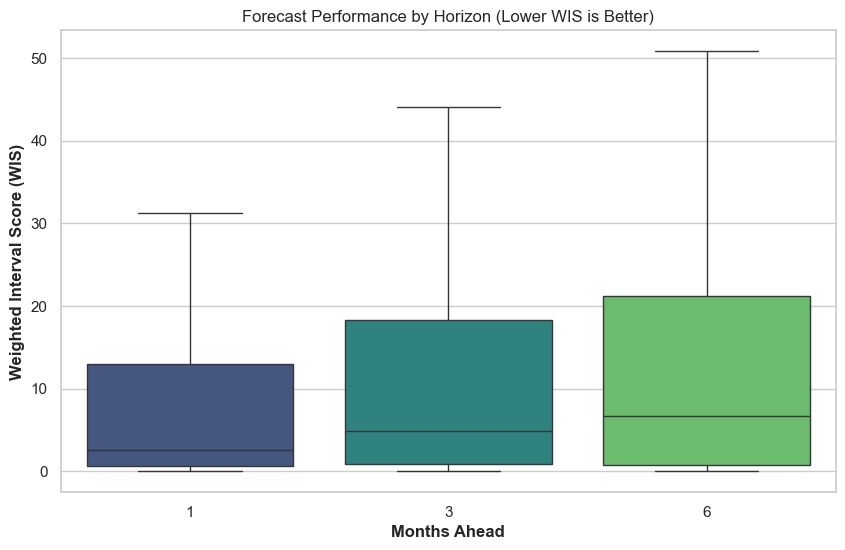

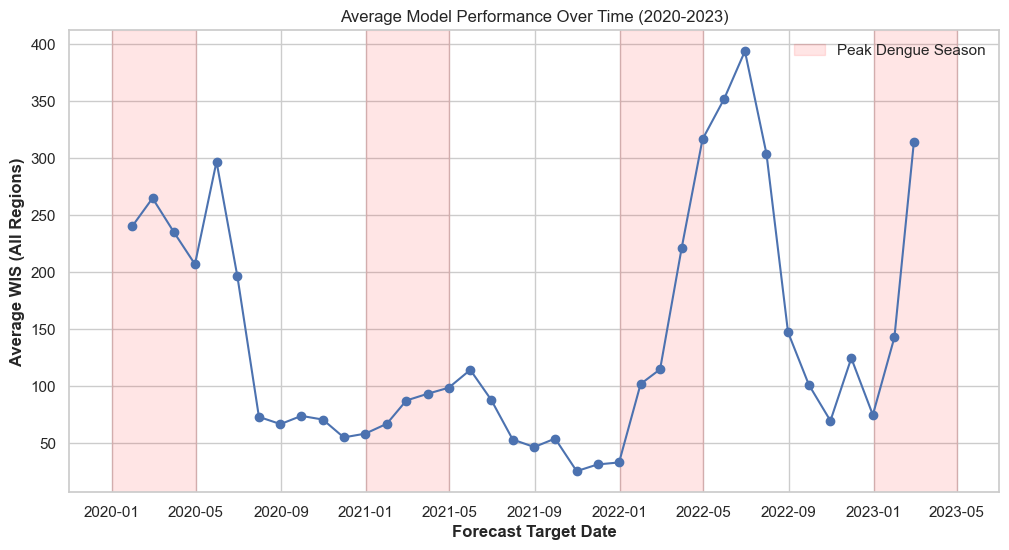

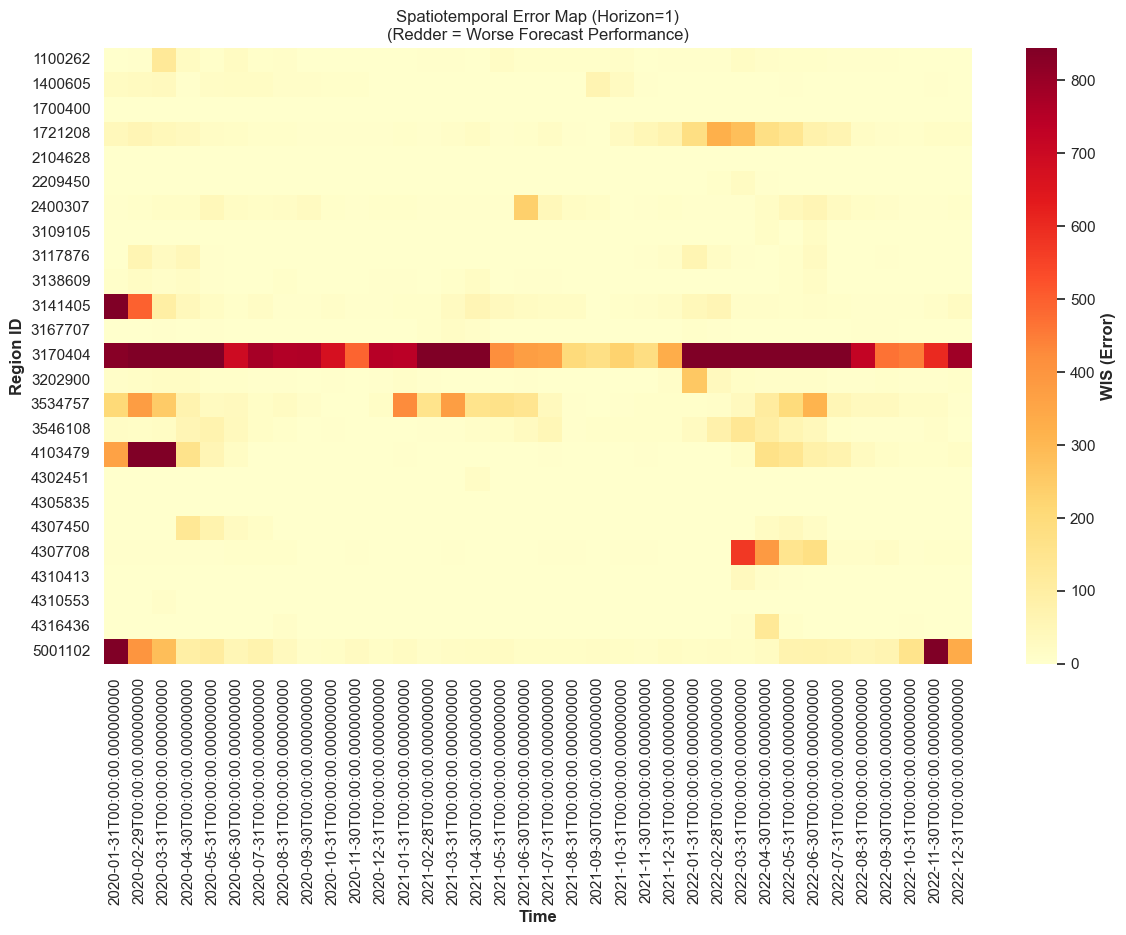

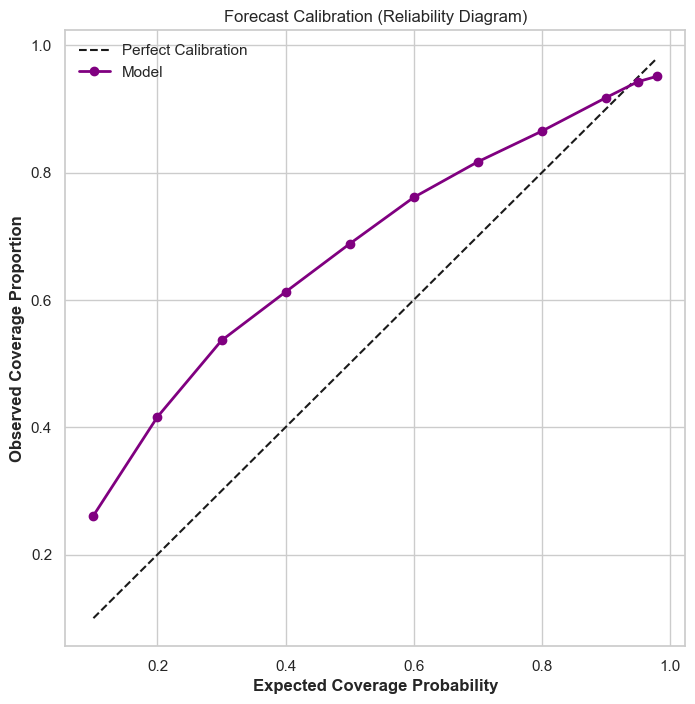


=== PERFORMANCE SUMMARY BY REGION ===
     Region  Mean_WIS    Std_WIS  Total_Observed_Cases  WIS_per_Case
18  4305835  0.000000   0.000000                   0.0      0.000000
17  4302451  0.557340   2.816515                   3.0     13.933491
22  4310553  0.645633   1.605943                   3.0     16.140834
4   2104628  0.994035   0.406628                   6.0     14.200507
21  4310413  1.495194   6.158033                   9.0     14.951938
2   1700400  1.632127   0.451886                   1.0     81.606364
5   2209450  1.740163   5.540173                  12.0     13.385871
7   3109105  2.304843   6.034550                  24.0      9.219371
23  4316436  5.025900  21.594489                  36.0     13.583514
11  3167707  7.107828  21.113019                 106.0      6.642830


In [ ]:
import seaborn as sns
# =============================================================================
# 2. COMPUTE WIS (Weighted Interval Score)
# =============================================================================
def calculate_wis(row):
    """
    Computes WIS for a single row based on the quantiles provided.
    WIS = 1/(K+0.5) * (w0 * |y - m| + sum(wk * IS_alpha))
    """
    actual = row['Actual']
    if pd.isna(actual):
        return np.nan
        
    # 1. Absolute Error (Median)
    median = row['q_0.500']
    abs_error = abs(actual - median)
    
    # 2. Interval Scores
    # We pair quantiles: (0.01, 0.99), (0.025, 0.975), etc.
    # The quantiles list provided in previous step:
    quantiles = [0.010, 0.025, 0.050, 0.100, 0.150, 0.200, 0.250, 0.300, 0.350, 
                 0.400, 0.450, 0.500, 0.550, 0.600, 0.650, 0.700, 0.750, 0.800, 
                 0.850, 0.900, 0.950, 0.975, 0.990]
    
    # Identify pairs
    K = len(quantiles) // 2
    interval_scores = []
    
    for k in range(K):
        lower_q = quantiles[k]
        upper_q = quantiles[-(k+1)]
        
        # Alpha (significance level)
        alpha = 2 * lower_q 
        
        # Get values
        L = row[f"q_{lower_q:.3f}"]
        U = row[f"q_{upper_q:.3f}"]
        
        # Interval Score Formula
        # Width + Penalty for missing lower + Penalty for missing upper
        score = (U - L) 
        if actual < L:
            score += (2/alpha) * (L - actual)
        if actual > U:
            score += (2/alpha) * (actual - U)
            
        interval_scores.append(score)
        
    # 3. Final Weighted Sum
    # Normalization factor 1 / (K + 0.5) is standard approximation
    wis = (1 / (K + 0.5)) * (0.5 * abs_error + sum(interval_scores))
    return wis

print("Calculating WIS for all forecasts...")
res_df['WIS'] = res_df.apply(calculate_wis, axis=1)

# Drop rows where WIS couldn't be calculated (missing actuals)
df_clean = res_df.dropna(subset=['WIS'])

# =============================================================================
# 3. VISUALIZATIONS
# =============================================================================
#Really simple visualisations
sns.set_theme(style="whitegrid")

# --- PLOT A: Performance Across Horizons (Boxplot) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Horizon', y='WIS', showfliers=False, palette="viridis")
plt.title("Forecast Performance by Horizon (Lower WIS is Better)")
plt.ylabel("Weighted Interval Score (WIS)")
plt.xlabel("Months Ahead")
plt.show()

# --- PLOT B: Performance Over Time (Aggregated Line Plot) ---
# Average WIS per forecast date across all regions
time_perf = df_clean.groupby('Forecast_Date')['WIS'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(time_perf['Forecast_Date'], time_perf['WIS'], marker='o', linestyle='-', color='b')
plt.title("Average Model Performance Over Time (2020-2023)")
plt.ylabel("Average WIS (All Regions)")
plt.xlabel("Forecast Target Date")
# Add shading for 'outbreak' seasons (roughly Jan-May in Brazil)
for year in range(2020, 2024):
    plt.axvspan(pd.Timestamp(f"{year}-01-01"), pd.Timestamp(f"{year}-05-01"), 
                color='red', alpha=0.1, label='Peak Dengue Season' if year==2020 else "")
plt.legend()
plt.show()

# --- PLOT C: Spatiotemporal Heatmap ---
# We pivot the data: Rows=Regions, Cols=Date, Values=WIS
# We filter for Horizon=1 for the cleanest view
heatmap_data = df_clean[df_clean['Horizon'] == 1].pivot_table(
    index='Region', 
    columns='Forecast_Date', 
    values='WIS', 
    aggfunc='mean'
)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="YlOrRd", robust=True, cbar_kws={'label': 'WIS (Error)'})
plt.title("Spatiotemporal Error Map (Horizon=1)\n(Redder = Worse Forecast Performance)")
plt.xlabel("Time")
plt.ylabel("Region ID")
plt.show()

# --- PLOT D: Reliability (Calibration) Diagram ---
# Check if 50% interval actually captures 50% of data, etc.
intervals = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.98]
observed_coverage = []

for interval in intervals:
    # Calculate alpha for this interval
    alpha = 1 - interval
    lower_q = alpha / 2
    upper_q = 1 - (alpha / 2)
    
    # Check coverage
    # Find closest available quantiles in our dataset
    # (Simplified lookup)
    l_col = f"q_{lower_q:.3f}"
    u_col = f"q_{upper_q:.3f}"
    
    if l_col in df_clean.columns and u_col in df_clean.columns:
        hits = ((df_clean['Actual'] >= df_clean[l_col]) & 
                (df_clean['Actual'] <= df_clean[u_col])).mean()
        observed_coverage.append(hits)
    else:
        observed_coverage.append(np.nan)

plt.figure(figsize=(8, 8))
plt.plot(intervals, intervals, 'k--', label='Perfect Calibration')
plt.plot(intervals, observed_coverage, 'o-', color='purple', lw=2, label='Model')
plt.xlabel("Expected Coverage Probability")
plt.ylabel("Observed Coverage Proportion")
plt.title("Forecast Calibration (Reliability Diagram)")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# 4. SUMMARY TABLE
# =============================================================================
print("\n=== PERFORMANCE SUMMARY BY REGION ===")
summary = df_clean.groupby('Region').agg({
    'WIS': ['mean', 'std'],
    'Actual': 'sum' # Total cases seen in this period
}).reset_index()
summary.columns = ['Region', 'Mean_WIS', 'Std_WIS', 'Total_Observed_Cases']
summary['WIS_per_Case'] = summary['Mean_WIS'] / (summary['Total_Observed_Cases'] + 1) * 100
print(summary.sort_values('Mean_WIS').head(10))

## Temporal Convolutional Network - i
 - First, **single region, single time point**, and all horizons
 - Using only historical covariates
 - Please read the docs to get more ideas about how to improve: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import uuid
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import TCNModel
from darts.utils.likelihood_models import QuantileRegression

# Pick a specific region for demonstration
# We pick one with most cases!
counts = df_final.groupby('Region')['Cases'].sum().sort_values(ascending=False)
selected_region = counts.index[0] # The region with most cases (likely populous)
print(f"Selected Region: {selected_region}")

Selected Region: 3106200


In [17]:
# Generate a random model name to ensure uniqueness
MODEL_NAME = f"TCN_Quantile_{uuid.uuid4().hex[:8]}"
print(f"New Model ID: {MODEL_NAME}")

New Model ID: TCN_Quantile_59b4a0ca


Selected Region: 3106200
Step 2: Creating TimeSeries...
Using Past Covariates: ['t2m', 'rh', 'tp']
Step 3: Splitting and Scaling...
Step 4: Training TCN...
Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 22.85it/s, train_loss=0.778]
Step 5: Predicting...
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
Prediction Shape: (6, 1) (Time, Components, Samples)
Step 6: Computing Quantiles...
Step 7: Visualizing...


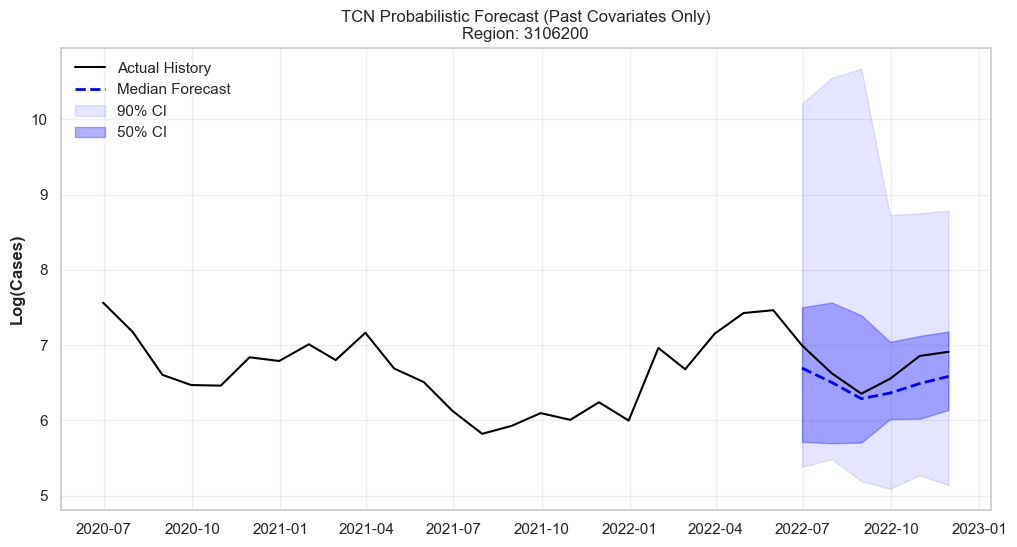


=== FORECAST TABLE (Log Scale) ===
               q0.10     q0.50     q0.90
Date                                    
2022-06-30  5.488759  6.695875  9.141065
2022-07-31  5.535505  6.506641  8.794956
2022-08-31  5.522016  6.289655  8.008542
2022-09-30  5.685915  6.364441  7.904436
2022-10-31  5.843547  6.490804  7.776429
2022-11-30  5.616177  6.585663  8.262259


In [18]:
# Pick one region (e.g., the one with the most cases)
top_region = df_final.groupby('Region')['Cases'].sum().idxmax()
print(f"Selected Region: {top_region}")

df_reg = df_final[df_final['Region'] == top_region].sort_values('Date')

# =============================================================================
# 2. SETUP TIME SERIES
# =============================================================================
print("Step 2: Creating TimeSeries...")

# A. TARGET (Log Scale)
ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
ts_target = fill_missing_values(ts_target)

# B. PAST COVARIATES (Weather only)
# We select only the columns that represent historical observations
cov_cols = ['t2m', 'rh', 'tp', 'spei'] 
# Ensure they exist in the DF
valid_covs = [c for c in cov_cols if c in df_reg.columns]
print(f"Using Past Covariates: {valid_covs}")

ts_past = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_covs, freq='ME')
ts_past = fill_missing_values(ts_past)

# =============================================================================
# 3. SPLIT & SCALE
# =============================================================================
print("Step 3: Splitting and Scaling...")

# Define Cutoff: We train up to June 2022, Predict July-Dec 2022
cutoff_date = pd.Timestamp("2022-06-30")
train_target, val_target = ts_target.split_before(cutoff_date)
train_past, val_past = ts_past.split_before(cutoff_date)

# Scale
scaler_target = Scaler()
scaler_past = Scaler()

ts_target_scaled = scaler_target.fit_transform(train_target)
ts_past_scaled = scaler_past.fit_transform(ts_past) # Scale full past series

# =============================================================================
# 4. TRAIN TCN (Simple)
# =============================================================================
print("Step 4: Training TCN...")

model = TCNModel(
    input_chunk_length=24,  # Look back 24 months
    output_chunk_length=6,  # Forecast 6 months
    kernel_size=3,
    num_filters=32,
    dilation_base=2,
    dropout=0.1,
    likelihood=QuantileRegression(), # <--- Generates probabilistic samples
    random_state=42,
    model_name=MODEL_NAME,
    force_reset=True,
    save_checkpoints=False,
    pl_trainer_kwargs={"accelerator": "cpu"}
)

model.fit(
    series=ts_target_scaled,
    past_covariates=ts_past_scaled,
    epochs=30,
    verbose=True
)

# =============================================================================
# 5. PREDICT (With Samples)
# =============================================================================
print("Step 5: Predicting...")

# Predict 6 months ahead
# num_samples=1000 ensures we get a distribution we can quantile later
pred_scaled = model.predict(
    n=6,
    series=ts_target_scaled,
    past_covariates=ts_past_scaled,
    num_samples=1000 
)

# Inverse Transform (Scales back the values, keeps the samples structure)
pred_log = scaler_target.inverse_transform(pred_scaled)

print(f"Prediction Shape: {pred_log.values().shape} (Time, Components, Samples)")

# =============================================================================
# 6. COMPUTE QUANTILES & DATAFRAME
# =============================================================================
print("Step 6: Computing Quantiles...")

QUANTILES = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
results = {'Date': pred_log.time_index}

for q in QUANTILES:
    # .quantile(q) reduces the 1000 samples to a single value per time step
    q_series = pred_log.quantile(q)
    results[f"q{q:.2f}"] = q_series.values().flatten()

df_forecast = pd.DataFrame(results).set_index('Date')

# =============================================================================
# 7. ALIGNMENT & VISUALIZATION
# =============================================================================
print("Step 7: Visualizing...")

# Get Ground Truth for the forecast period + some history
full_actual = ts_target.slice(cutoff_date - pd.DateOffset(months=24), cutoff_date + pd.DateOffset(months=6))
df_actual = pd.DataFrame({
    'Actual': full_actual.values().flatten()
}, index=full_actual.time_index)

# Merge for perfect alignment on the plot
df_plot = df_actual.join(df_forecast, how='outer')

plt.figure(figsize=(12, 6))

# Plot History (Black)
plt.plot(df_plot.index, df_plot['Actual'], color='black', label='Actual History', linewidth=1.5)

# Plot Forecast (Blue)
# We filter to where we actually have forecasts
subset = df_plot.dropna(subset=['q0.50'])

plt.plot(subset.index, subset['q0.50'], color='blue', label='Median Forecast', linewidth=2, linestyle='--')

# Fan Chart
plt.fill_between(subset.index, subset['q0.05'], subset['q0.95'], color='blue', alpha=0.1, label='90% CI')
plt.fill_between(subset.index, subset['q0.25'], subset['q0.75'], color='blue', alpha=0.3, label='50% CI')

plt.title(f"TCN Probabilistic Forecast (Past Covariates Only)\nRegion: {top_region}")
plt.ylabel("Log(Cases)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# =============================================================================
# 8. PRINT RESULTS
# =============================================================================
print("\n=== FORECAST TABLE (Log Scale) ===")
print(df_forecast[['q0.10', 'q0.50', 'q0.90']])

## Temporal Convolutional Network - ii
 - Now, single region, all time points in 2020-2022, and all horizons
 - Using only historical covariates
 - Please read the docs to get more ideas about how to improve: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html


Starting Rolling Forecast (2020-2022)...
  Processing cutoff: 2020-01-31 (1/36)
  Processing cutoff: 2020-07-31 (7/36)
  Processing cutoff: 2021-01-31 (13/36)
  Processing cutoff: 2021-07-31 (19/36)
  Processing cutoff: 2022-01-31 (25/36)
  Processing cutoff: 2022-07-31 (31/36)

Step 4: Generating Visualizations...


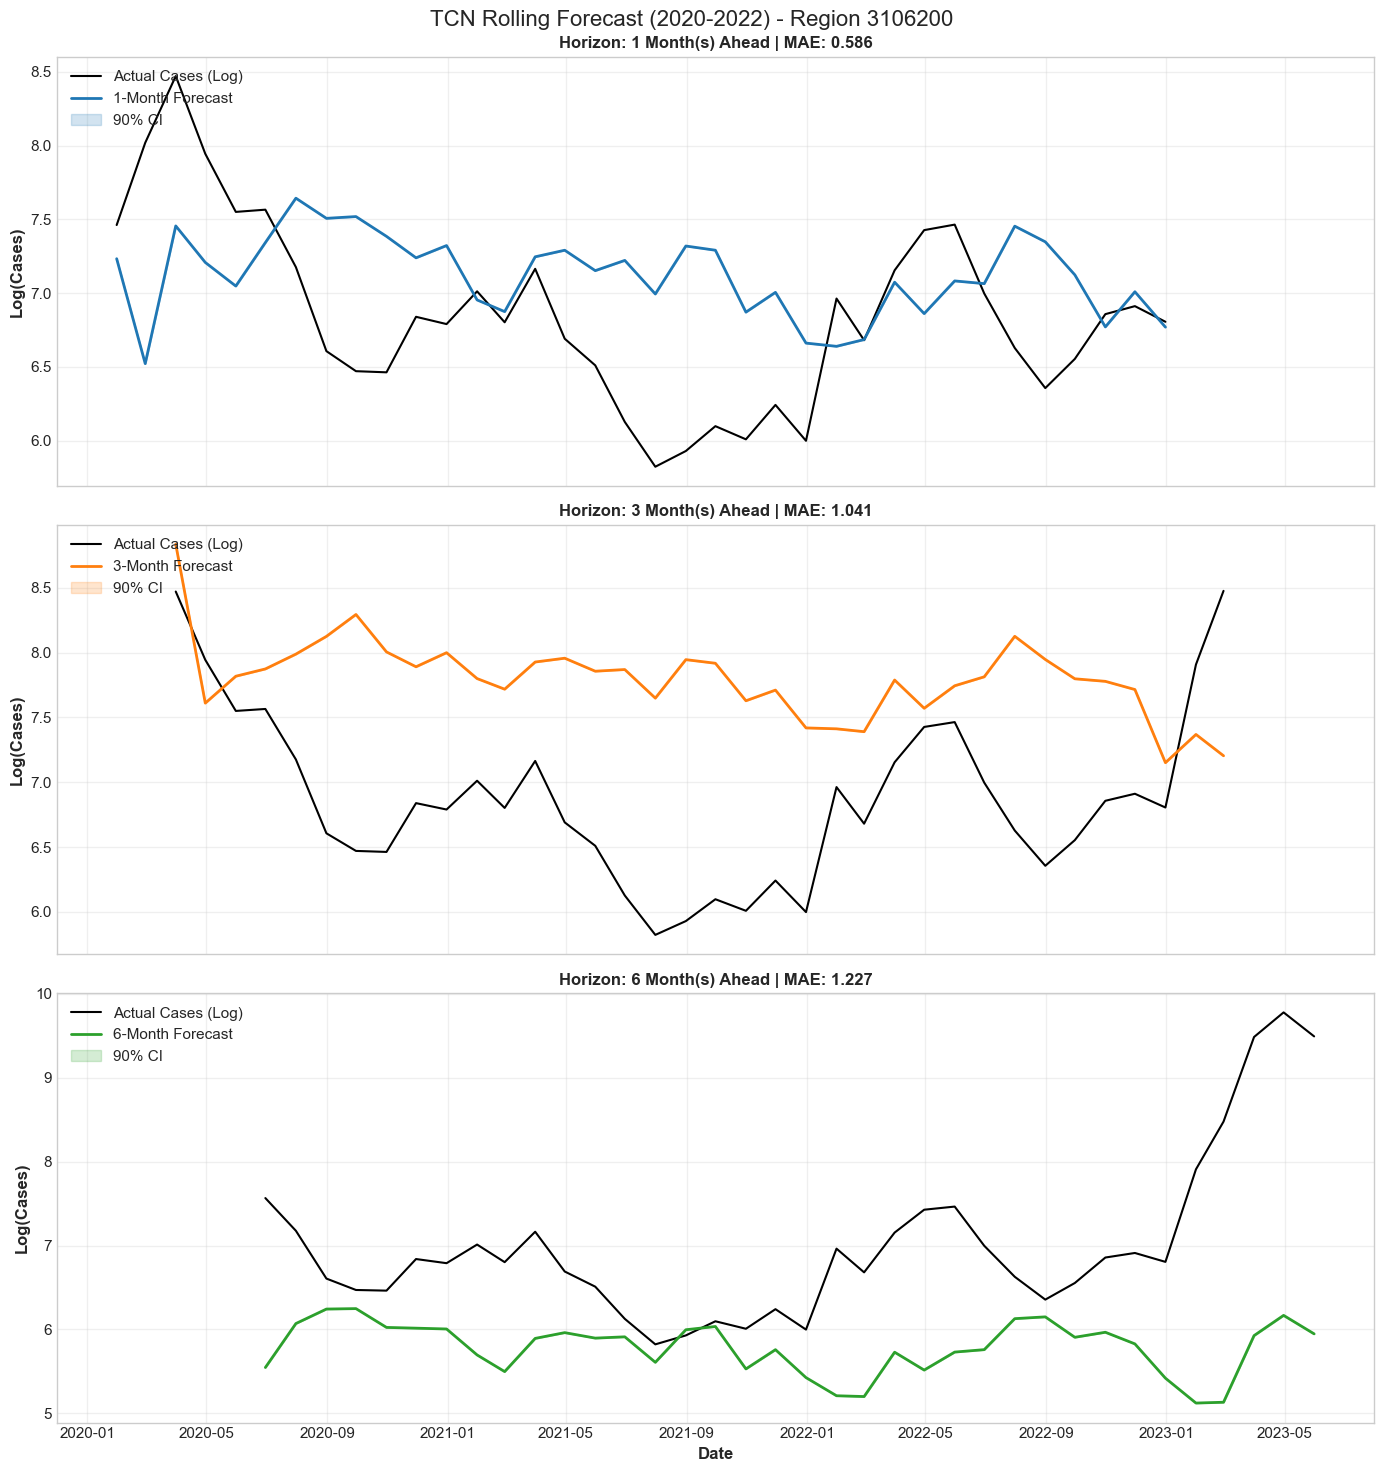

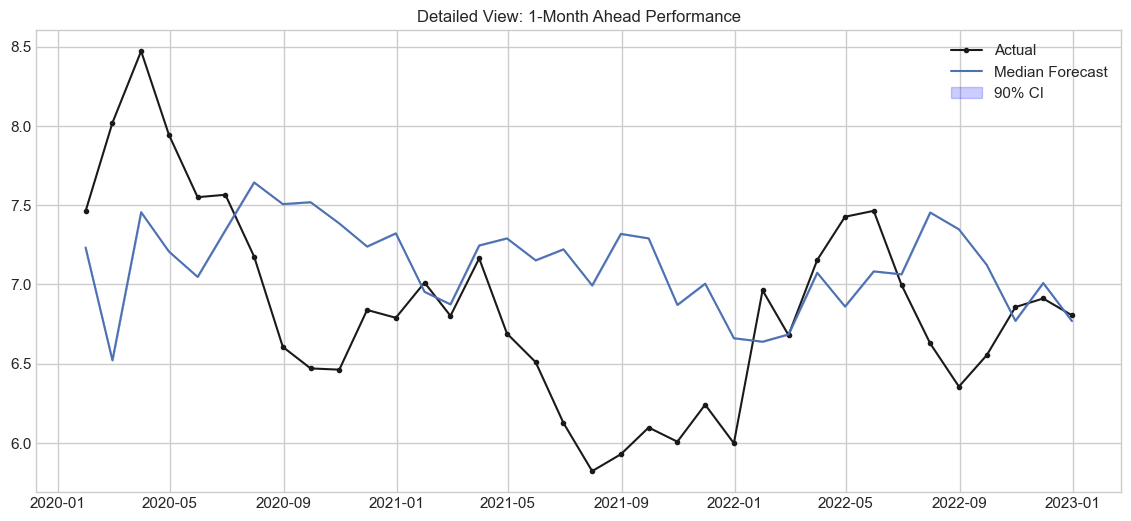


=== SUMMARY METRICS ===
Horizon
1    0.585998
3    1.041207
6    1.226836
dtype: float64


In [ ]:
ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
ts_target = fill_missing_values(ts_target)

# Past Covariates (Weather)
cov_cols = ['t2m', 'rh', 'tp', 'spei'] 
valid_covs = [c for c in cov_cols if c in df_reg.columns]
ts_past = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_covs, freq='ME')
ts_past = fill_missing_values(ts_past)

# Scale
scaler_target = Scaler()
scaler_past = Scaler()
ts_target_scaled = scaler_target.fit_transform(ts_target)
ts_past_scaled = scaler_past.fit_transform(ts_past)

# =============================================================================
# 3. ROLLING BACKTEST (2020-2022)
# =============================================================================
print("\nStarting Rolling Forecast (2020-2022)...")
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

results = []

for i, cutoff in enumerate(cutoffs):
    if i % 6 == 0: print(f"  Processing cutoff: {cutoff.date()} ({i+1}/{len(cutoffs)})")
    
    # 1. Split Data
    train_target, _ = ts_target_scaled.split_before(cutoff)
    
    # 2. Train Model (Fresh)
    model = TCNModel(
        input_chunk_length=24,
        output_chunk_length=6,
        kernel_size=3,
        num_filters=16, 
        dilation_base=2,
        dropout=0.1,
        likelihood=QuantileRegression(), #Play around with this 
        random_state=42,
        pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
    )
    
    model.fit(series=train_target, past_covariates=ts_past_scaled, epochs=15, verbose=False)
    
    # 3. Predict (Samples)
    pred_samples = model.predict(n=6, series=train_target, past_covariates=ts_past_scaled, num_samples=500, verbose=False)
    
    # 4. Inverse Transform
    pred_inv = scaler_target.inverse_transform(pred_samples)
    
    # Extract Values (Handling 2D vs 3D shape)
    vals = pred_inv.values() # Shape could be (Time, Samples) or (Time, 1, Samples)
    
    # Loop over horizons 1, 3, 6
    for h in [1, 3, 6]:
        step_idx = h - 1
        forecast_date = pred_inv.time_index[step_idx]
        
        # --- ROBUST EXTRACTION ---
        if vals.ndim == 3:
            # (Time, Component, Samples)
            samples_at_step = vals[step_idx, 0, :]
        else:
            # (Time, Samples)
            samples_at_step = vals[step_idx, :]
        # -------------------------
        
        q05 = np.quantile(samples_at_step, 0.05)
        q50 = np.quantile(samples_at_step, 0.50)
        q95 = np.quantile(samples_at_step, 0.95)
        
        try:
            actual = ts_target[forecast_date].values()[0][0]
        except:
            actual = np.nan
            
        results.append({
            'Origin': cutoff,
            'Horizon': h,
            'Forecast_Date': forecast_date,
            'q05': q05, 'q50': q50, 'q95': q95,
            'Actual': actual
        })

df_res = pd.DataFrame(results)

# =============================================================================
# 4. VISUALIZATION
# =============================================================================
print("\nStep 4: Generating Visualizations...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

horizons = [1, 3, 6]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, h in enumerate(horizons):
    ax = axes[idx]
    data_h = df_res[df_res['Horizon'] == h]
    
    # Plot Actual vs Forecast
    ax.plot(data_h['Forecast_Date'], data_h['Actual'], color='black', label='Actual Cases (Log)', linewidth=1.5)
    ax.plot(data_h['Forecast_Date'], data_h['q50'], color=colors[idx], label=f'{h}-Month Forecast', linewidth=2)
    
    # Uncertainty
    ax.fill_between(data_h['Forecast_Date'], data_h['q05'], data_h['q95'], 
                    color=colors[idx], alpha=0.2, label='90% CI')
    
    valid = data_h.dropna()
    mae = np.mean(np.abs(valid['q50'] - valid['Actual'])) if len(valid)>0 else np.nan
    
    ax.set_title(f"Horizon: {h} Month(s) Ahead | MAE: {mae:.3f}", fontsize=12, fontweight='bold')
    ax.set_ylabel("Log(Cases)")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.xlabel("Date")
plt.suptitle(f"TCN Rolling Forecast (2020-2022) - Region {top_region}", fontsize=16)
plt.tight_layout()
plt.show()

# Fan Chart Zoom (H=1)
plt.figure(figsize=(14, 6))
h1 = df_res[df_res['Horizon'] == 1]
plt.plot(h1['Forecast_Date'], h1['Actual'], 'k.-', label='Actual')
plt.plot(h1['Forecast_Date'], h1['q50'], 'b-', label='Median Forecast')
plt.fill_between(h1['Forecast_Date'], h1['q05'], h1['q95'], color='blue', alpha=0.2, label='90% CI')
plt.title("Detailed View: 1-Month Ahead Performance")
plt.legend()
plt.show()

print("\n=== SUMMARY METRICS ===")
print(df_res.groupby('Horizon')[['Actual', 'q50']].apply(lambda x: np.mean(np.abs(x['Actual'] - x['q50']))))

## Temporal Convolutional Network - iii
 - Now, single region, all time points in 2020-2022, and all horizons
 - Using only historical covariates
 - V. simple covariate selection + hyperparameter tuning
 - Again, read the docs to get more ideas about how to improve: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html


--- EXPERIMENT 1: COVARIATE SELECTION ---
Testing: Weather...
  MAE: 0.0293
Testing: Full...
  MAE: 0.0375
Testing: Minimal...
  MAE: 0.0917
Testing: Univariate...
  MAE: 0.0566

Winner: Weather (0.0293)

--- EXPERIMENT 2: HYPERPARAMETER TUNING ---
Config 1: {'input_chunk_length': 12, 'kernel_size': 3, 'num_filters': 16, 'dropout': 0.1, 'output_chunk_length': 6, 'dilation_base': 2}
  MAE: 0.0690
Config 2: {'input_chunk_length': 24, 'kernel_size': 3, 'num_filters': 32, 'dropout': 0.1, 'output_chunk_length': 6, 'dilation_base': 2}
  MAE: 0.0733
Config 3: {'input_chunk_length': 36, 'kernel_size': 5, 'num_filters': 16, 'dropout': 0.2, 'output_chunk_length': 6, 'dilation_base': 2}
  MAE: 0.0718
Config 4: {'input_chunk_length': 24, 'kernel_size': 3, 'num_filters': 16, 'dropout': 0.3, 'output_chunk_length': 6, 'dilation_base': 2}
  MAE: 0.1065

Top Models:
         Type        Name     Score  \
0   Covariate     Weather  0.029310   
1   Covariate        Full  0.037523   
3   Covariate  Univa

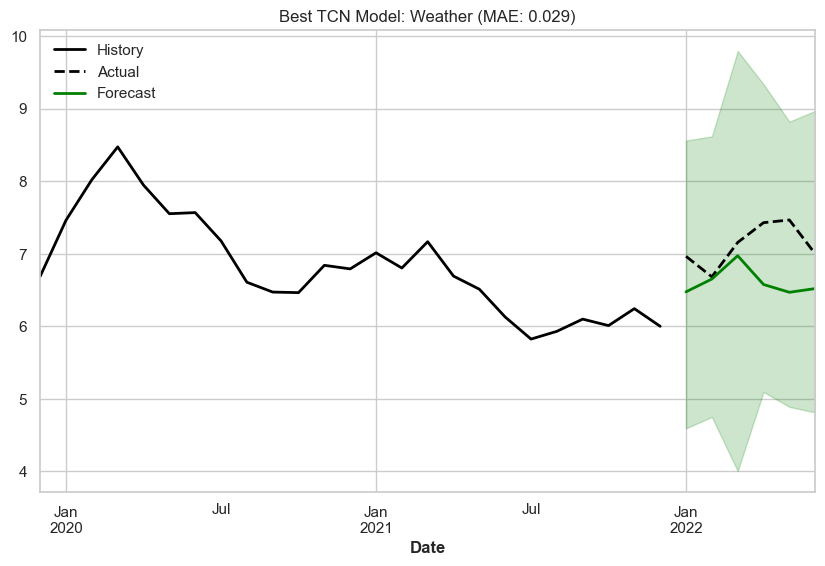

In [19]:
from darts.metrics import mae as calc_mae  # <--- Renamed import to prevent shadowing
# Covariate Library
cov_library = {}

weather_cols = ['t2m', 'rh', 'tp', 'spei']
valid_w = [c for c in weather_cols if c in df_reg.columns]
if valid_w:
    cov_library['Weather'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_w, freq='ME'))

full_cols = weather_cols + ['gdp_pc', 'pop_count']
valid_f = [c for c in full_cols if c in df_reg.columns]
if valid_f:
    cov_library['Full'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_f, freq='ME'))

min_cols = ['t2m', 'tp']
valid_m = [c for c in min_cols if c in df_reg.columns]
if valid_m:
    cov_library['Minimal'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_m, freq='ME'))

cov_library['Univariate'] = None

# Scale
cov_library_scaled = {}
for name, ts in cov_library.items():
    if ts is not None:
        cov_library_scaled[name] = Scaler().fit_transform(ts)
    else:
        cov_library_scaled[name] = None

scaler_target = Scaler()
ts_target_scaled = scaler_target.fit_transform(ts_target)

# =============================================================================
# 3. EXPERIMENT LOOP (Corrected)
# =============================================================================
def evaluate_config(cov_name, model_params, train_series, val_series):
    cov_ts = cov_library_scaled.get(cov_name)
    run_id = uuid.uuid4().hex[:6]
    
    # Ensure n doesn't exceed output_chunk_length to avoid auto-regression warning
    horizon = min(len(val_series), model_params['output_chunk_length'])
    
    model = TCNModel(
        likelihood=QuantileRegression(),
        random_state=42,
        model_name=f"TCN_{run_id}",
        force_reset=True,
        save_checkpoints=False,
        pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False, "enable_model_summary": False},
        **model_params
    )
    
    try:
        model.fit(series=train_series, past_covariates=cov_ts, epochs=15, verbose=False)
        pred = model.predict(n=horizon, series=train_series, past_covariates=cov_ts, num_samples=100, verbose=False)
        
        # Calculate Metric
        val_slice = val_series.slice(pred.start_time(), pred.end_time())
        score = calc_mae(val_slice, pred) # Using calc_mae, not variable 'mae'
        return score
    except Exception as e:
        print(f"    Failed: {e}")
        return float('inf')

# Define Split
cutoff_date = pd.Timestamp("2022-01-31")
train, val = ts_target_scaled.split_before(cutoff_date)
val = val.slice(cutoff_date, cutoff_date + pd.DateOffset(months=5)) # 6 months only

results = []

print(f"\n--- EXPERIMENT 1: COVARIATE SELECTION ---")
base_params = {'input_chunk_length': 24, 'output_chunk_length': 6, 'kernel_size': 3, 'num_filters': 16, 'dropout': 0.1, 'dilation_base': 2}

for cov_name in cov_library_scaled.keys():
    print(f"Testing: {cov_name}...")
    s = evaluate_config(cov_name, base_params, train, val)
    print(f"  MAE: {s:.4f}")
    results.append({'Type': 'Covariate', 'Name': cov_name, 'Score': s, 'Params': base_params})

best_cov = sorted([r for r in results if r['Type'] == 'Covariate'], key=lambda x: x['Score'])[0]
best_cov_name = best_cov['Name']
print(f"\nWinner: {best_cov_name} ({best_cov['Score']:.4f})")

print(f"\n--- EXPERIMENT 2: HYPERPARAMETER TUNING ---")
param_grid = [
    {'input_chunk_length': 12, 'kernel_size': 3, 'num_filters': 16, 'dropout': 0.1},
    {'input_chunk_length': 24, 'kernel_size': 3, 'num_filters': 32, 'dropout': 0.1},
    {'input_chunk_length': 36, 'kernel_size': 5, 'num_filters': 16, 'dropout': 0.2},
    {'input_chunk_length': 24, 'kernel_size': 3, 'num_filters': 16, 'dropout': 0.3},
]

for i, p in enumerate(param_grid):
    p['output_chunk_length'] = 6
    p['dilation_base'] = 2
    print(f"Config {i+1}: {p}")
    s = evaluate_config(best_cov_name, p, train, val)
    print(f"  MAE: {s:.4f}")
    results.append({'Type': 'Hyperparam', 'Name': f"Conf_{i+1}", 'Score': s, 'Params': p})

# =============================================================================
# 4. RESULTS & BEST MODEL
# =============================================================================
df_res = pd.DataFrame(results).sort_values('Score')
print("\nTop Models:")
print(df_res.head())

# Train Winner
winner = df_res.iloc[0]
print(f"\nTraining Winner: {winner['Name']}...")
final_cov = cov_library_scaled[best_cov_name if winner['Type']=='Hyperparam' else winner['Name']]

final_model = TCNModel(
    likelihood=QuantileRegression(),
    random_state=42,
    model_name="TCN_Winner",
    force_reset=True,
    save_checkpoints=False,
    pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False},
    **winner['Params']
)

final_model.fit(series=train, past_covariates=final_cov, epochs=30, verbose=False)
pred = final_model.predict(n=6, series=train, past_covariates=final_cov, num_samples=1000)

pred_inv = scaler_target.inverse_transform(pred)
val_inv = scaler_target.inverse_transform(val)

q50 = pred_inv.quantile(0.5)
q05 = pred_inv.quantile(0.05)
q95 = pred_inv.quantile(0.95)

plt.figure(figsize=(10, 6))
# Plot History
hist_inv = scaler_target.inverse_transform(train.slice(train.end_time() - pd.DateOffset(months=24), train.end_time()))
hist_inv.plot(label='History', color='black')
val_inv.plot(label='Actual', color='black', linestyle='--')
q50.plot(label='Forecast', color='green')
plt.fill_between(q50.time_index, q05.values().flatten(), q95.values().flatten(), color='green', alpha=0.2)
plt.title(f"Best TCN Model: {winner['Name']} (MAE: {winner['Score']:.3f})")
plt.legend()
plt.show()

### More feature selection + hyperparam tuning

In [ ]:
# =============================================================================
# 0. SETUP & CLEANUP
# =============================================================================
def cleanup_checkpoints():
    for folder in ['darts_logs', '_model.pth.tar']:
        if os.path.exists(folder):
            try: shutil.rmtree(folder)
            except: pass

cleanup_checkpoints()
region_counts = df_final.groupby('Region')['Date'].count()
valid_regions = region_counts[region_counts >= 60].index.tolist()
# =============================================================================
# 2. FEATURE ENGINEERING FUNCTION
# =============================================================================
def prepare_region_series(region_id, df_all):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target (Log Scale)
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    # Feature Sets
    cov_dict = {}
    
    # 1. Weather Only
    w_cols = ['t2m', 'rh', 'tp', 'spei']
    valid_w = [c for c in w_cols if c in df_reg.columns]
    if valid_w:
        cov_dict['Weather'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_w, freq='ME'))
        
    # 2. Full (Weather + Socio)
    f_cols = w_cols + ['gdp_pc', 'pop_count']
    valid_f = [c for c in f_cols if c in df_reg.columns]
    if valid_f:
        cov_dict['Full'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_f, freq='ME'))
    
    return ts_target, cov_dict

# =============================================================================
# 3. PHASE 1: PILOT TUNING (Feature Selection & Epochs)
    # DISCLAIMER: I only do tuning + grid search for a single region!
# =============================================================================
pilot_region = np.random.choice(valid_regions)
print(f"\n--- PHASE 1: TUNING ON PILOT REGION {pilot_region} ---")

ts_pilot, cov_pilot = prepare_region_series(pilot_region, df_final)
scaler_pilot = Scaler()
ts_pilot_scaled = scaler_pilot.fit_transform(ts_pilot)

# Scale Covariates
cov_pilot_scaled = {k: Scaler().fit_transform(v) for k, v in cov_pilot.items()}

# Define Split (Validate on 2022)
split_date = pd.Timestamp("2022-01-31")
train, val = ts_pilot_scaled.split_before(split_date)
val = val.slice(split_date, split_date + pd.DateOffset(months=5)) # 6 months only

tuning_results = []

# Grid Search
feature_sets = list(cov_pilot_scaled.keys()) + ['None']
epoch_options = [20, 50] # Simplified for speed

for feats in feature_sets:
    for eps in epoch_options:
        run_name = f"Tune_{feats}_Ep{eps}_{uuid.uuid4().hex[:4]}"
        covs = cov_pilot_scaled.get(feats)
        
        model = TCNModel(
            input_chunk_length=24,
            output_chunk_length=6,
            kernel_size=3,
            num_filters=16,
            dilation_base=2,
            dropout=0.1,
            likelihood=QuantileRegression(),
            random_state=42,
            model_name=run_name,
            force_reset=True,
            save_checkpoints=False,
            pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
        )
        
        try:
            model.fit(series=train, past_covariates=covs, epochs=eps, verbose=False)
            pred = model.predict(n=6, series=train, past_covariates=covs, num_samples=100, verbose=False)
            score = calc_mae(val, pred)
            tuning_results.append({'Features': feats, 'Epochs': eps, 'MAE': score})
            print(f"  Config [Features={feats}, Epochs={eps}]: MAE={score:.4f}")
        except Exception as e:
            print(f"  Config Failed: {e}")

# Select Winner
best_config = sorted(tuning_results, key=lambda x: x['MAE'])[0]
print(f"\nWINNING CONFIGURATION: {best_config}")

# =============================================================================
# 4. PHASE 2: MASS ROLLOUT (20 Regions)
# =============================================================================
# Select 20 random regions
target_regions = np.random.choice(valid_regions, 20, replace=False)
print(f"\n--- PHASE 2: ROLLING FORECAST (20 REGIONS, 2020-2022) ---")
print(f"Regions: {target_regions}")

# Rolling Params
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

# Storage
all_forecasts = []

# Main Loop
for region in tqdm(target_regions, desc="Processing Regions"):
    # Prepare Data
    ts_raw, cov_raw_dict = prepare_region_series(region, df_final)
    
    # Select Best Features based on Tuning
    feat_key = best_config['Features']
    if feat_key == 'None':
        ts_cov = None
        ts_cov_scaled = None
    else:
        ts_cov = cov_raw_dict.get(feat_key)
        # If specific features missing for this region, fallback to Weather
        if ts_cov is None and 'Weather' in cov_raw_dict:
            ts_cov = cov_raw_dict['Weather']
        
        # Scale
        if ts_cov:
            scaler_cov = Scaler()
            ts_cov_scaled = scaler_cov.fit_transform(ts_cov)
        else:
            ts_cov_scaled = None

    # Scale Target
    scaler_tgt = Scaler()
    ts_scaled = scaler_tgt.fit_transform(ts_raw)
    
    # Rolling Loop per Region
    # We stride by 3 months to save time (Jan, Apr, Jul, Oct...)
    # Change step=1 for monthly (slower)
    for cutoff in cutoffs[::3]: 
        
        # Check data availability
        if cutoff > ts_scaled.end_time() or cutoff < ts_scaled.start_time() + pd.DateOffset(months=24):
            continue
            
        train, _ = ts_scaled.split_before(cutoff)
        
        # Train Model (Fresh)
        model = TCNModel(
            input_chunk_length=24,
            output_chunk_length=6,
            kernel_size=3,
            num_filters=16,
            dilation_base=2,
            dropout=0.1,
            likelihood=QuantileRegression(),
            random_state=42,
            model_name=f"TCN_{region}_{uuid.uuid4().hex[:4]}",
            force_reset=True,
            save_checkpoints=False,
            pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False, "enable_model_summary": False}
        )
        
        try:
            model.fit(series=train, past_covariates=ts_cov_scaled, epochs=best_config['Epochs'], verbose=False)
            
            # Predict (1000 Samples)
            pred_samples = model.predict(n=6, series=train, past_covariates=ts_cov_scaled, num_samples=1000, verbose=False)
            
            # Inverse Transform
            pred_inv = scaler_tgt.inverse_transform(pred_samples)
            vals = pred_inv.values() # (Time, 1, Samples) or (Time, Samples)
            
            # Extract Horizons
            for h in [1, 3, 6]:
                step = h - 1
                fc_date = pred_inv.time_index[step]
                
                # Robust Sample Extraction
                if vals.ndim == 3: samp = vals[step, 0, :]
                else: samp = vals[step, :]
                
                q05, q50, q95 = np.quantile(samp, [0.05, 0.50, 0.95])
                
                # Get Actual
                try: act = ts_raw[fc_date].values()[0][0]
                except: act = np.nan
                
                all_forecasts.append({
                    'Region': region,
                    'Origin': cutoff,
                    'Horizon': h,
                    'Forecast_Date': fc_date,
                    'q05': q05, 'q50': q50, 'q95': q95,
                    'Actual': act
                })
                
        except Exception as e:
            continue
            
    cleanup_checkpoints() # Clean disk after each region

# =============================================================================
# 5. ANALYSIS & VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts)
res_df = res_df.dropna(subset=['Actual'])
res_df['Abs_Error'] = (res_df['q50'] - res_df['Actual']).abs()
res_df['Covered'] = (res_df['Actual'] >= res_df['q05']) & (res_df['Actual'] <= res_df['q95'])

print("\n--- GLOBAL PERFORMANCE ---")
print(res_df.groupby('Horizon')[['Abs_Error', 'Covered']].mean())

# --- A. Spatiotemporal Heatmap (Horizon 1) ---
# Average MAE per Region per Year
res_df['Year'] = res_df['Forecast_Date'].dt.year
heatmap_data = res_df[res_df['Horizon'] == 1].pivot_table(
    index='Region', columns='Year', values='Abs_Error', aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis_r', annot=True, fmt=".2f", cbar_kws={'label': 'MAE (Log Scale)'})
plt.title("Spatiotemporal Error Heatmap (1-Month Ahead)")
plt.show()

# --- B. Performance Boxplot by Horizon ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=res_df, x='Horizon', y='Abs_Error', palette="Set2")
plt.title("Forecast Error Distribution by Horizon")
plt.ylabel("Absolute Error (Log Scale)")
plt.show()

# --- C. Reliability Diagram ---
# Check calibration of 90% interval
overall_cov = res_df['Covered'].mean()
plt.figure(figsize=(6, 6))
plt.bar(['Target', 'Observed'], [0.90, overall_cov], color=['gray', 'blue' if overall_cov >= 0.85 else 'red'])
plt.axhline(0.90, color='k', linestyle='--')
plt.title(f"90% Interval Calibration\nObserved Coverage: {overall_cov:.1%}")
plt.ylim(0, 1)
plt.show()




--- PHASE 1: TUNING ON PILOT REGION 2506202 ---
  Config [Features=Weather, Epochs=20]: MAE=0.4020
  Config [Features=Weather, Epochs=50]: MAE=0.4135
  Config [Features=Full, Epochs=20]: MAE=0.4147
  Config [Features=Full, Epochs=50]: MAE=0.3872
  Config [Features=None, Epochs=20]: MAE=0.3913
  Config [Features=None, Epochs=50]: MAE=0.4076

WINNING CONFIGURATION: {'Features': 'Full', 'Epochs': 50, 'MAE': np.float64(0.3872082064983944)}

--- PHASE 2: ROLLING FORECAST (20 REGIONS, 2020-2022) ---
Regions: [3147956 4322251 3103801 4215075 5005608 4317608 5104807 4214003 4215307
 3500550 5103361 2305308 3515608 4305439 2704302 3154101 4201273 2508703
 4215679 3126208]


Processing Regions:  40%|████      | 8/20 [04:56<07:23, 36.94s/it]

Step 1: Loading Data
  Regions with sufficient history: 5572

--- PHASE 1: TUNING ON PILOT REGION 3106200 ---
  Starting Grid Search...
    Config [Feat=Weather, Ep=50]: WIS=40.5072
    Config [Feat=Weather, Ep=100]: WIS=35.2834
    Config [Feat=Weather, Ep=150]: WIS=31.8702
    Config [Feat=Full, Ep=50]: WIS=48.7090
    Config [Feat=Full, Ep=100]: WIS=107.5486
    Config [Feat=Full, Ep=150]: WIS=131.2081
    Config [Feat=None, Ep=50]: WIS=38.8811
    Config [Feat=None, Ep=100]: WIS=35.9605
    Config [Feat=None, Ep=150]: WIS=33.1663

WINNING CONFIGURATION: {'Features': 'Weather', 'Epochs': 150, 'WIS': np.float64(31.870158658213136)}

--- PHASE 2: ROLLING FORECAST (20 REGIONS) ---


Regions: 100%|██████████| 20/20 [1:12:54<00:00, 218.73s/it]



Total Forecasts: 2160


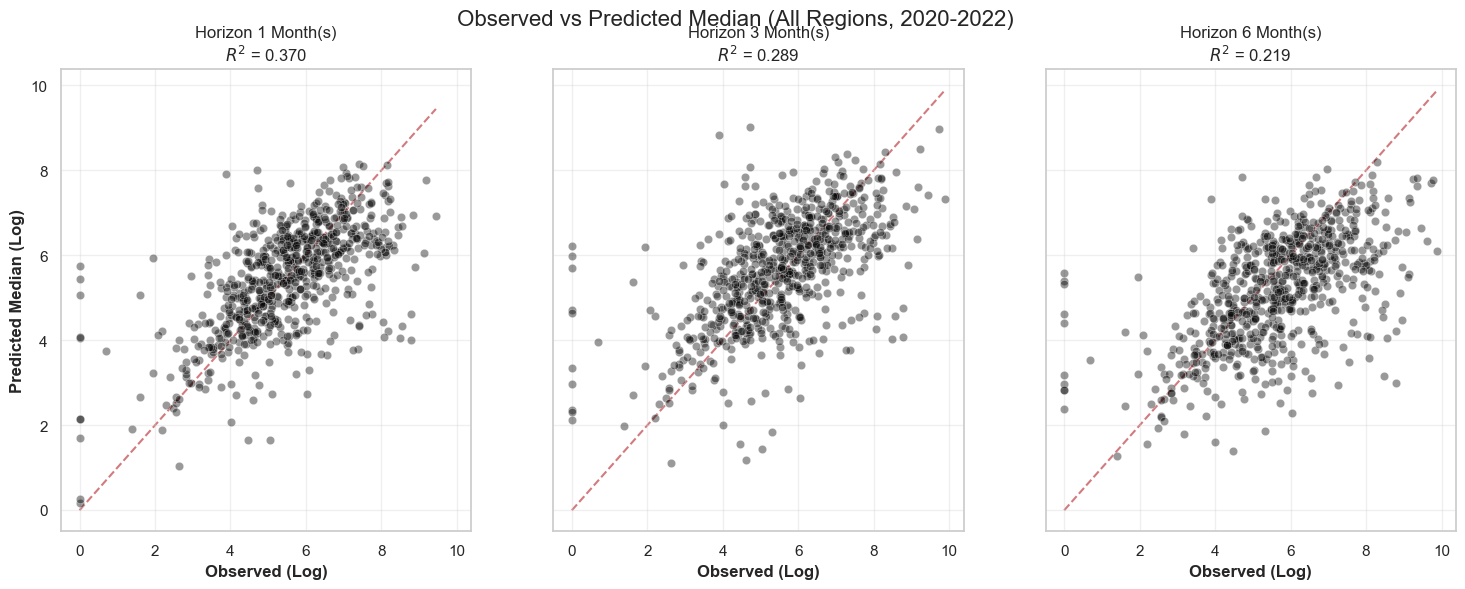

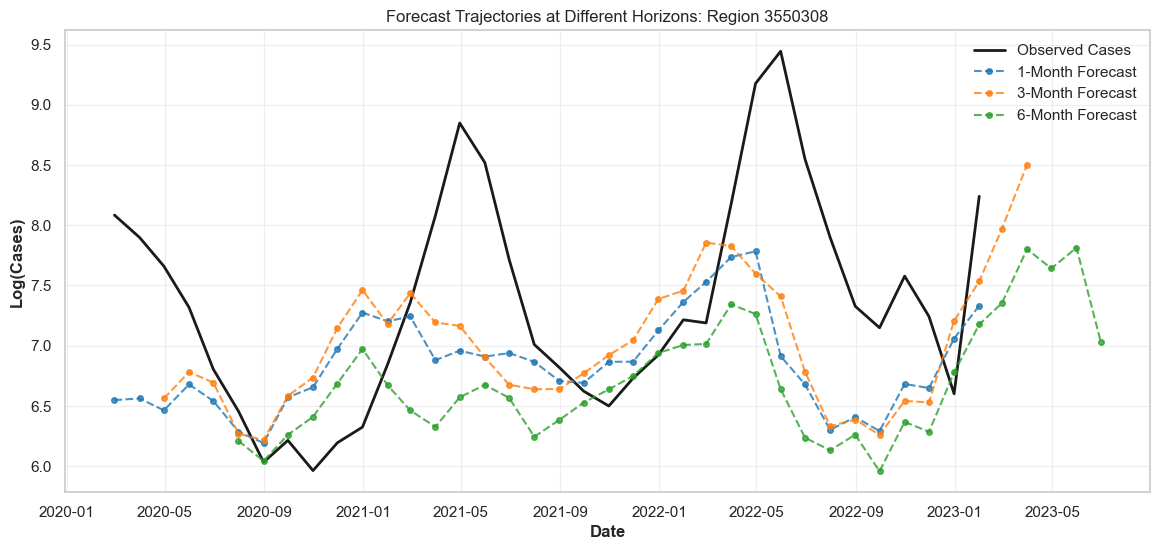

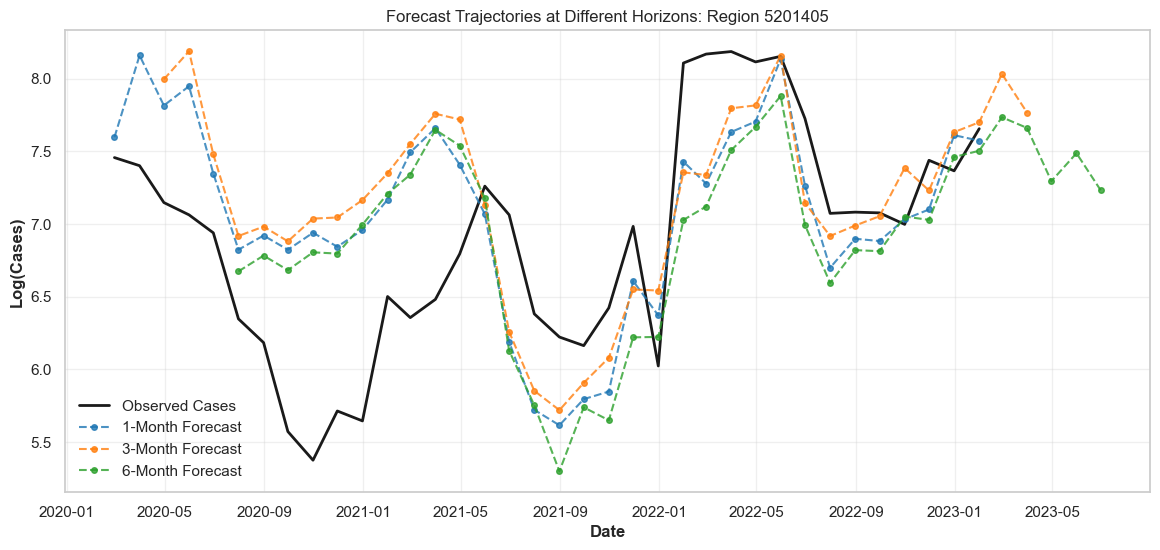

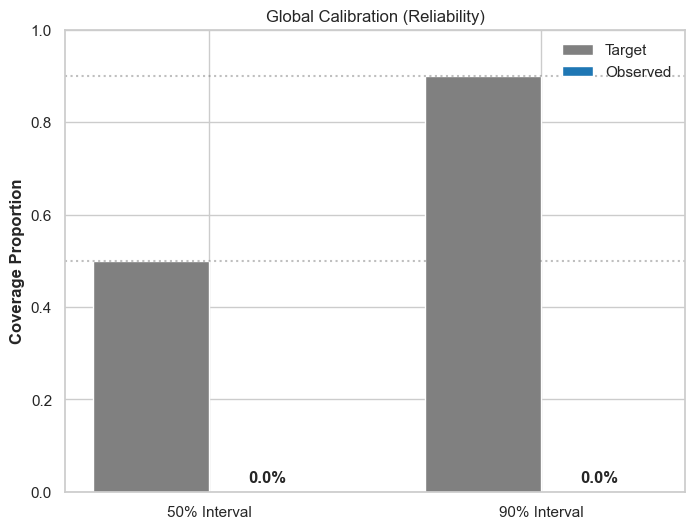

In [ ]:


# =============================================================================
# 1. LOAD DATA
# =============================================================================
print("Step 1: Loading Data")

# Filter regions (min 60 months)
# Select 20 valid regions
# valid_regions = df_final.groupby('Region')['Date'].count()
# valid_regions = valid_regions[valid_regions >= 60].index.tolist()
# # Prioritise High Case regions for meaningful visualization, then random
# high_case_regions = df_final.groupby('Region')['Cases'].sum().sort_values(ascending=False).head(50).index.tolist()
# pool = list(set(valid_regions).intersection(high_case_regions))
# target_regions = np.random.choice(pool, min(20, len(pool)), replace=False)

print(f"  Regions with sufficient history: {len(valid_regions)}")

# =============================================================================
# 2. FEATURE ENGINEERING FUNCTION
# =============================================================================
def prepare_region_series(region_id, df_all):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target: Log Scale
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    cov_dict = {}
    # 1. Weather
    w_cols = ['t2m', 'rh', 'tp', 'spei']
    valid_w = [c for c in w_cols if c in df_reg.columns]
    if valid_w:
        cov_dict['Weather'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_w, freq='ME'))
    
    # 2. Full
    f_cols = w_cols + ['gdp_pc', 'pop_count']
    valid_f = [c for c in f_cols if c in df_reg.columns]
    if valid_f:
        cov_dict['Full'] = fill_missing_values(TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=valid_f, freq='ME'))
    
    return ts_target, cov_dict

# =============================================================================
# 3. PHASE 1: PILOT TUNING (Robust & Leakage Proof)
# =============================================================================
for folder in ['darts_logs', '_model.pth.tar']:
    if os.path.exists(folder): shutil.rmtree(folder, ignore_errors=True)

# Select Top Region (Best Data Quality)
pilot_region = df_final.groupby('Region')['Cases'].sum().idxmax()
print(f"\n--- PHASE 1: TUNING ON PILOT REGION {pilot_region} ---")

ts_pilot, cov_pilot = prepare_region_series(pilot_region, df_final)
scaler_pilot = Scaler()
ts_pilot_scaled = scaler_pilot.fit_transform(ts_pilot)
cov_pilot_scaled = {k: Scaler().fit_transform(v) for k, v in cov_pilot.items()}

# Validation Split: Train 2015-2021, Validate on 2022
# Dynamic check to ensure we have data
split_date = pd.Timestamp("2022-01-01")
if split_date > ts_pilot_scaled.end_time():
    split_date = ts_pilot_scaled.end_time() - pd.DateOffset(months=12)

train, val_scaled = ts_pilot_scaled.split_after(split_date)
val_log = ts_pilot.slice(val_scaled.start_time(), val_scaled.end_time())

tuning_results = []
feature_sets = list(cov_pilot_scaled.keys()) + ['None']
epoch_options = [50, 100, 150] 
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

print("  Starting Grid Search...")
for feats in feature_sets:
    for eps in epoch_options:
        run_name = f"Tune_{feats}_{eps}_{uuid.uuid4().hex[:4]}"
        covs = cov_pilot_scaled.get(feats)
        
        model = TCNModel(
            input_chunk_length=24, output_chunk_length=6, kernel_size=3, num_filters=16,
            dilation_base=2, dropout=0.1, likelihood=GaussianLikelihood(), random_state=42,
            model_name=run_name, force_reset=True, save_checkpoints=False,
            pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
        )
        
        try:
            model.fit(series=train, past_covariates=covs, epochs=eps, verbose=False)
            
            # Predict Rolling 6-month windows for 2022
            hf = model.historical_forecasts(
                series=ts_pilot_scaled,
                past_covariates=covs,
                start=train.end_time() + pd.DateOffset(months=1),
                forecast_horizon=6,
                stride=1,
                retrain=False,
                verbose=False,
                num_samples=500
            )
            
            pred_log = scaler_pilot.inverse_transform(hf)
            vals = pred_log.values()
            if vals.ndim == 3: vals = vals[:, 0, :]
            
            total_wis = 0
            valid_steps = min(len(pred_log), len(val_log))
            
            for t_idx in range(valid_steps):
                samp = vals[t_idx, :]
                q_dict = {q: np.quantile(samp, q) for q in QUANTILES}
                actual = val_log[t_idx].values()[0][0]
                total_wis += calculate_wis_scalar(actual, q_dict)
            
            avg_wis = total_wis / valid_steps if valid_steps > 0 else np.nan
            tuning_results.append({'Features': feats, 'Epochs': eps, 'WIS': avg_wis})
            print(f"    Config [Feat={feats}, Ep={eps}]: WIS={avg_wis:.4f}")
            
        except Exception:
            pass

if not tuning_results:
    print("  Tuning failed. Defaulting to Weather/30.")
    best_config = {'Features': 'Weather', 'Epochs': 30}
else:
    best_config = sorted(tuning_results, key=lambda x: x['WIS'])[0]
    print(f"\nWINNING CONFIGURATION: {best_config}")

# =============================================================================
# 4. PHASE 2: MASS ROLLOUT (20 Regions)
# =============================================================================
# Select 20 valid regions
valid_regions = df_final.groupby('Region')['Date'].count()
valid_regions = valid_regions[valid_regions >= 60].index.tolist()
# Prioritize High Case regions for meaningful visualization, then random
high_case_regions = df_final.groupby('Region')['Cases'].sum().sort_values(ascending=False).head(50).index.tolist()
pool = list(set(valid_regions).intersection(high_case_regions))
target_regions = np.random.choice(pool, min(20, len(pool)), replace=False)

print(f"\n--- PHASE 2: ROLLING FORECAST ({len(target_regions)} REGIONS) ---")

start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

all_forecasts = []

for region in tqdm(target_regions, desc="Regions"):
    ts_raw, cov_raw_dict = prepare_region_series(region, df_final)
    
    # Config
    feat_key = best_config['Features']
    ts_cov = cov_raw_dict.get(feat_key, cov_raw_dict.get('Weather'))
    
    scaler_tgt = Scaler()
    ts_scaled = scaler_tgt.fit_transform(ts_raw)
    ts_cov_scaled = Scaler().fit_transform(ts_cov) if ts_cov else None
        
    # Rolling Loop (Stride=1) 
    for i, cutoff in enumerate(cutoffs):
        #Checks of enough data
        if cutoff < ts_scaled.start_time() + pd.DateOffset(months=24): continue
        if cutoff > ts_scaled.end_time(): break
            
        train, _ = ts_scaled.split_after(cutoff) # LEAKAGE FIX: Train INCLUDES cutoff
        
        model = TCNModel(
            input_chunk_length=24, output_chunk_length=6, kernel_size=3, num_filters=16,
            dilation_base=2, dropout=0.1, likelihood=GaussianLikelihood(), random_state=42,
            model_name=f"TCN_{region}_{uuid.uuid4().hex[:4]}", force_reset=True,
            save_checkpoints=False, pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
        )
        
        try:
            model.fit(series=train, past_covariates=ts_cov_scaled, epochs=best_config['Epochs'], verbose=False)
            
            # Predict 6 months
            pred_samples = model.predict(n=6, series=train, past_covariates=ts_cov_scaled, num_samples=1000, verbose=False)
            
            pred_inv = scaler_tgt.inverse_transform(pred_samples)
            vals = pred_inv.values()
            if vals.ndim == 3: vals = vals[:, 0, :]
            
            for h in [1, 3, 6]:
                step = h - 1
                if step >= len(pred_inv): break
                
                fc_date = pred_inv.time_index[step]
                samp = vals[step, :]
                q50 = np.quantile(samp, 0.5)
                q_dict = {q: np.quantile(samp, q) for q in QUANTILES}
                
                try: act = ts_raw[fc_date].values()[0][0]
                except: act = np.nan
                
                wis = calculate_wis_scalar(act, q_dict)
                
                row = {
                    'Region': region, 
                    'Forecast_Origin_Date': cutoff,
                    'Target_End_Date': fc_date,
                    'Horizon': h, 
                    'Actual_Log': act, 
                    'Predicted_Median': q50,
                    'WIS_Log': wis
                }
                for q, v in q_dict.items(): row[f'q{q:.2f}'] = v
                all_forecasts.append(row)
                
        except Exception:
            continue
            
    for folder in ['darts_logs']: 
        if os.path.exists(folder): shutil.rmtree(folder, ignore_errors=True)

# =============================================================================
# 5. SENSIBLE VISUALIZATIONS
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual_Log'])

print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    # --- PLOT 1: OBSERVED vs PREDICTED (SCATTER) with R2 ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    
    for idx, h in enumerate([1, 3, 6]):
        ax = axes[idx]
        subset = res_df[res_df['Horizon'] == h]
        
        # Metric
        r2 = r2_score(subset['Actual_Log'], subset['Predicted_Median'])
        
        # Scatter
        sns.scatterplot(data=subset, x='Actual_Log', y='Predicted_Median', alpha=0.4, ax=ax, color='black')
        
        # Perfect line
        lims = [min(subset['Actual_Log'].min(), subset['Predicted_Median'].min()), 
                max(subset['Actual_Log'].max(), subset['Predicted_Median'].max())]
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
        
        ax.set_title(f"Horizon {h} Month(s)\n$R^2$ = {r2:.3f}")
        ax.set_xlabel("Observed (Log)")
        if idx == 0: ax.set_ylabel("Predicted Median (Log)")
        ax.grid(True, alpha=0.3)

    plt.suptitle("Observed vs Predicted Median (All Regions, 2020-2022)", fontsize=16)
    plt.show()

    # --- PLOT 2: MULTI-HORIZON TRAJECTORIES (Case Studies) ---
    # Select 2 High-Volume Regions for Detail
    sample_regions = res_df.groupby('Region')['Actual_Log'].sum().nlargest(2).index.tolist()
    
    for rid in sample_regions:
        reg_data = res_df[res_df['Region'] == rid]
        
        plt.figure(figsize=(14, 6))
        
        # Plot Actuals (using H=1 to get the continuous line of truth)
        actuals = reg_data[reg_data['Horizon'] == 1].sort_values('Target_End_Date')
        plt.plot(actuals['Target_End_Date'], actuals['Actual_Log'], 'k-', lw=2, label='Observed Cases')
        
        # Plot Horizons
        colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'} # Blue, Orange, Green
        
        for h in [1, 3, 6]:
            h_data = reg_data[reg_data['Horizon'] == h].sort_values('Target_End_Date')
            plt.plot(h_data['Target_End_Date'], h_data['Predicted_Median'], 
                     marker='o', markersize=4, linestyle='--', color=colors[h], alpha=0.8, 
                     label=f'{h}-Month Forecast')
            
        plt.title(f"Forecast Trajectories at Different Horizons: Region {rid}")
        plt.ylabel("Log(Cases)")
        plt.xlabel("Date")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    # --- PLOT 3: GLOBAL RELIABILITY ---
    res_df['Covered_50'] = (res_df['Actual_Log'] >= res_df['q0.25']) & (res_df['Actual_Log'] <= res_df['q0.75'])
    res_df['Covered_90'] = (res_df['Actual_Log'] >= res_df['q0.05']) & (res_df['Actual_Log'] <= res_df['q0.95'])
    
    cov50 = res_df['Covered_50'].mean()
    cov90 = res_df['Covered_90'].mean()
    
    plt.figure(figsize=(8, 6))
    x = ['50% Interval', '90% Interval']
    y_target = [0.50, 0.90]
    y_observed = [cov50, cov90]
    
    x_axis = np.arange(len(x))
    width = 0.35
    
    plt.bar(x_axis - width/2, y_target, width, label='Target', color='gray')
    plt.bar(x_axis + width/2, y_observed, width, label='Observed', color=['#1f77b4', '#1f77b4'])
    
    plt.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    plt.axhline(0.9, color='gray', linestyle=':', alpha=0.5)
    
    plt.xticks(x_axis, x)
    plt.ylabel("Coverage Proportion")
    plt.title("Global Calibration (Reliability)")
    plt.legend()
    plt.ylim(0, 1)
    
    for i, v in enumerate(y_observed):
        plt.text(i + width/2, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')
        
    plt.show()

else:
    print("No forecasts generated.")


Total Forecasts: 2160

--- GLOBAL PERFORMANCE BY HORIZON ---
         R2 (Caret)        WIS
Horizon                       
1          0.401272  26.936233
3          0.347022  29.621288
6          0.332995  32.700514


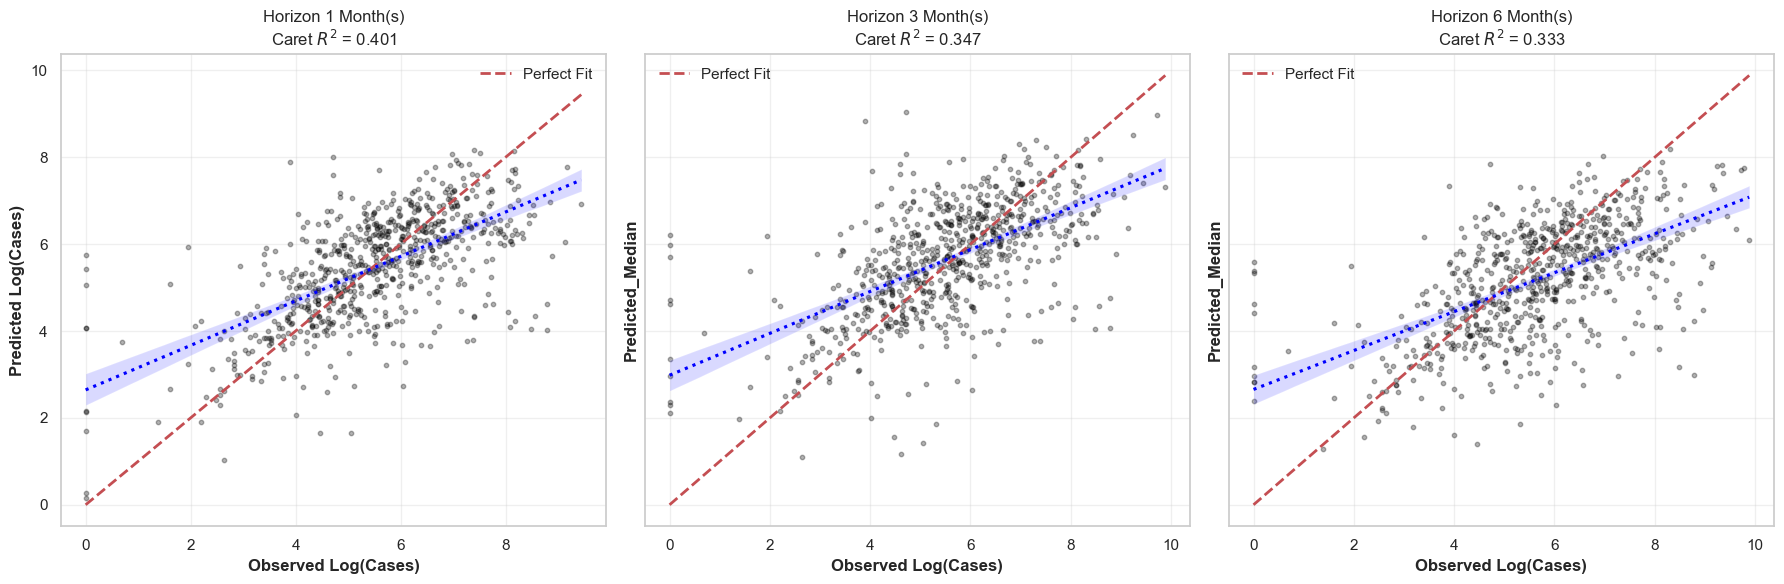

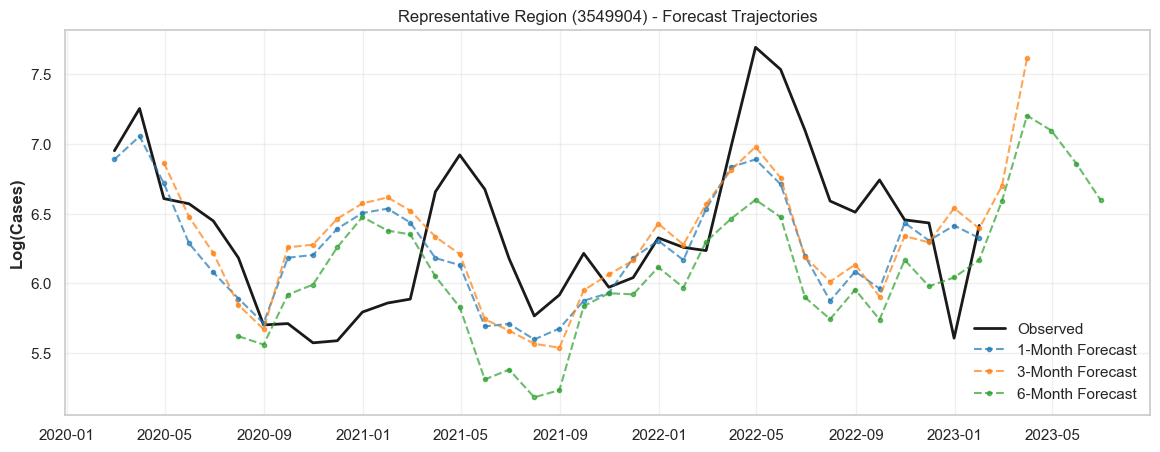

In [ ]:

print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    # --- METRIC CALCULATION (Per Horizon) ---
    def get_metrics(x):
        return pd.Series({
            'R2 (Caret)': caret_r2(x['Actual_Log'], x['Predicted_Median']),
            'WIS': x['WIS_Log'].mean()
        })

    metrics_df = res_df.groupby(['Horizon']).apply(get_metrics)
    print("\n--- GLOBAL PERFORMANCE BY HORIZON ---")
    print(metrics_df)

    # --- PLOT 1: SCATTER PLOT with Caret R2 ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    for idx, h in enumerate([1, 3, 6]):
        ax = axes[idx]
        subset = res_df[res_df['Horizon'] == h]
        
        # Calculate R2
        r2_val = caret_r2(subset['Actual_Log'], subset['Predicted_Median'])
        
        # Scatter
        ax.scatter(subset['Actual_Log'], subset['Predicted_Median'], alpha=0.3, color='black', s=10)
        
        # Identity Line
        lims = [0, max(subset['Actual_Log'].max(), subset['Predicted_Median'].max())]
        ax.plot(lims, lims, 'r--', lw=2, label='Perfect Fit')
        
        # Regression Line (to show correlation)
        sns.regplot(data=subset, x='Actual_Log', y='Predicted_Median', scatter=False, ax=ax, color='blue', line_kws={'linestyle':':'})
        
        ax.set_title(f"Horizon {h} Month(s)\nCaret $R^2$ = {r2_val:.3f}")
        ax.set_xlabel("Observed Log(Cases)")
        if idx == 0: ax.set_ylabel("Predicted Log(Cases)")
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # --- PLOT 2: TRAJECTORIES (Time Series Overlay) ---
    # Pick a representative region (Median R2)
    reg_scores = res_df[res_df['Horizon']==1].groupby('Region').apply(lambda x: caret_r2(x['Actual_Log'], x['Predicted_Median'])).sort_values()
    median_reg = reg_scores.index[len(reg_scores)//2]
    
    # Plot Trajectories
    reg_data = res_df[res_df['Region'] == median_reg]
    plt.figure(figsize=(14, 5))
    
    truth = reg_data[reg_data['Horizon']==1].sort_values('Target_End_Date')
    plt.plot(truth['Target_End_Date'], truth['Actual_Log'], 'k-', lw=2, label='Observed')
    
    colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
    for h in [1, 3, 6]:
        h_data = reg_data[reg_data['Horizon'] == h].sort_values('Target_End_Date')
        plt.plot(h_data['Target_End_Date'], h_data['Predicted_Median'], ls='--', marker='.', alpha=0.7, 
                 color=colors[h], label=f'{h}-Month Forecast')
        
    plt.title(f"Representative Region ({median_reg}) - Forecast Trajectories")
    plt.ylabel("Log(Cases)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Temporal Convolutional Network - iv
- With efficient retraining every six months



--- PHASE 1: FEATURE SELECTION (Pilot Region: 3106200) ---
  Testing Feature Set: Minimal_Weather ['t2m', 'tp']...
    -> WIS: 14.7975
  Testing Feature Set: Standard_Weather ['t2m', 'rh', 'tp']...
    -> WIS: 15.9538
  Testing Feature Set: Full_Weather ['t2m', 'rh', 'tp', 'spei']...
    -> WIS: 15.9538
  Testing Feature Set: Weather_Socio ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']...
    -> WIS: 14.2129
  Testing Feature Set: Univariate []...
    -> WIS: 14.2129

WINNING FEATURE SET: Weather_Socio
Columns: ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']

--- PHASE 2: ROLLING FORECAST (50 REGIONS) ---
Strategy: Stride=1 Month, Refit=Every 6 Months


Regions: 100%|██████████| 50/50 [41:30<00:00, 49.82s/it]



Total Forecasts: 5400

--- PERFORMANCE METRICS ---
         Caret_R2   Mean_WIS
Horizon                     
1        0.587754  20.650719
3        0.458809  26.554150
6        0.420053  28.422701


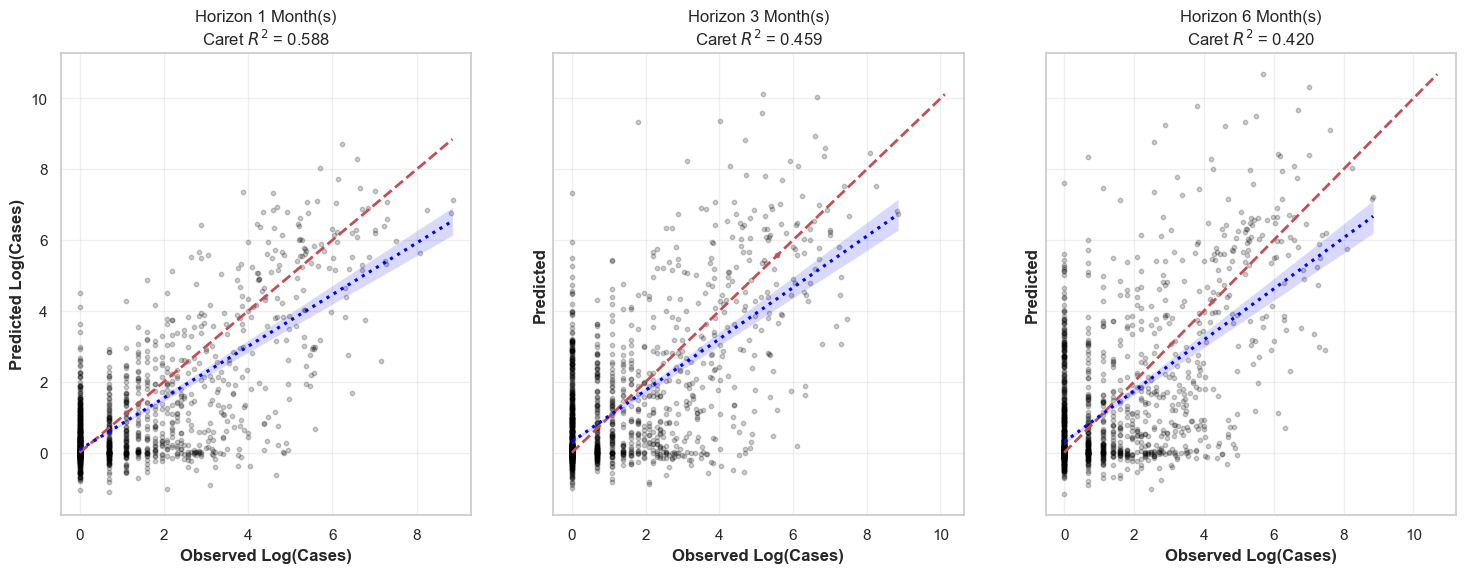

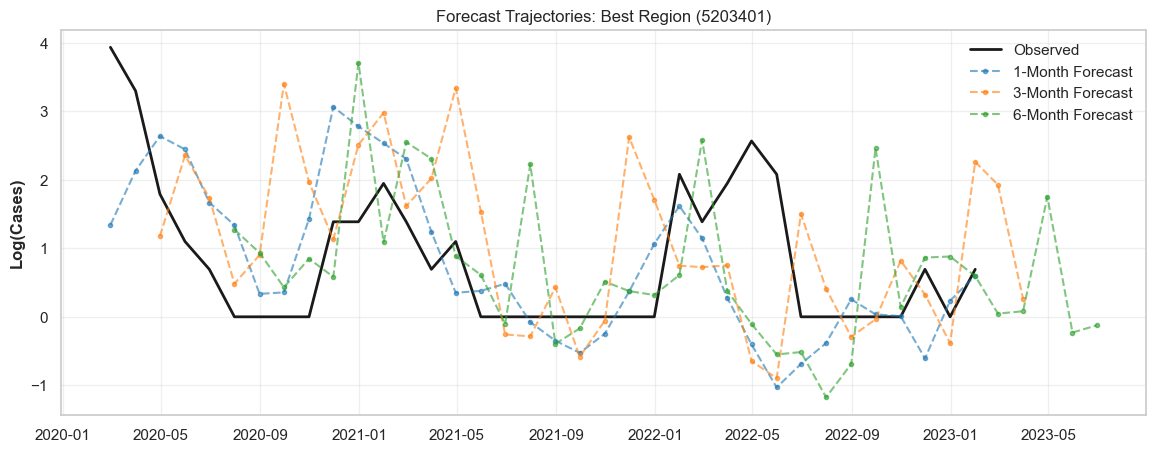

In [59]:
def prepare_region_series(region_id, df_all, feature_subset=None):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target: Log Scale
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    cov_dict = {}
    
    # Define available raw columns
    available_cols = [c for c in df_reg.columns if c not in ['Region', 'Date', 'Cases', 'LogCases']]
    
    # If a specific subset is requested, filter for it
    if feature_subset:
        selected_cols = [c for c in feature_subset if c in available_cols]
    else:
        # Default bucket: All Weather + Socio
        selected_cols = [c for c in available_cols if c in ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']]
    
    if selected_cols:
        ts_cov = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=selected_cols, freq='ME')
        ts_cov = fill_missing_values(ts_cov)
    else:
        ts_cov = None
        
    return ts_target, ts_cov

# =============================================================================
# 3. PHASE 1: FEATURE SELECTION (Pilot Phase)
# =============================================================================
# We use a high-data region to select the best features
pilot_region = df_final.groupby('Region')['Cases'].sum().idxmax()
print(f"\n--- PHASE 1: FEATURE SELECTION (Pilot Region: {pilot_region}) ---")

# Define Candidate Feature Sets
feature_candidates = {
    'Minimal_Weather': ['t2m', 'tp'],
    'Standard_Weather': ['t2m', 'rh', 'tp'],
    'Full_Weather': ['t2m', 'rh', 'tp', 'spei'],
    'Weather_Socio': ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count'],
    'Univariate': [] # No covariates
}

# Training Split for Tuning: Train 2015-2019, Validate 2020
split_date = pd.Timestamp("2020-01-01")
tuning_results = []

# Prepare Pilot Data
_, full_covs_ts = prepare_region_series(pilot_region, df_final) # Just to check availability

for name, cols in feature_candidates.items():
    print(f"  Testing Feature Set: {name} {cols}...")
    
    # Get Series
    ts_t, ts_c = prepare_region_series(pilot_region, df_final, feature_subset=cols)
    
    # Scale
    scaler_t = Scaler()
    ts_t_scaled = scaler_t.fit_transform(ts_t)
    
    if ts_c:
        scaler_c = Scaler()
        ts_c_scaled = scaler_c.fit_transform(ts_c)
    else:
        ts_c_scaled = None
        
    # Split
    train, val = ts_t_scaled.split_before(split_date)
    val = val.slice(split_date, split_date + pd.DateOffset(months=11)) # 1 Year Val
    val_log = ts_t.slice(val.start_time(), val.end_time()) # Unscaled target for WIS
    
    # Model (Fixed Hyperparams for fairness)
    model = TCNModel(
        input_chunk_length=24, output_chunk_length=6, 
        kernel_size=3, num_filters=16, dropout=0.1,
        likelihood=QuantileRegression(), random_state=42,
        model_name=f"FeatSel_{name}_{uuid.uuid4().hex[:4]}",
        force_reset=True, save_checkpoints=False,
        pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
    )
    
    try:
        model.fit(series=train, past_covariates=ts_c_scaled, epochs=50, verbose=False)
        
        # Predict 2020 (Rolling 6-month windows)
        hf = model.historical_forecasts(
            series=ts_t_scaled, past_covariates=ts_c_scaled,
            start=split_date, forecast_horizon=6, stride=6,
            retrain=False, verbose=False, num_samples=200
        )
        
        # Calc WIS
        pred_log = scaler_t.inverse_transform(hf)
        vals = pred_log.values()
        if vals.ndim == 3: vals = vals[:, 0, :]
        
        total_wis = 0
        steps = min(len(pred_log), len(val_log))
        
        for t in range(steps):
            samp = vals[t, :]
            q_dict = {q: np.quantile(samp, q) for q in [0.05, 0.5, 0.95]}
            act = val_log[t].values()[0][0]
            total_wis += calculate_wis_scalar(act, q_dict)
            
        avg_wis = total_wis / steps
        tuning_results.append({'Features': name, 'Columns': cols, 'WIS': avg_wis})
        print(f"    -> WIS: {avg_wis:.4f}")
        
    except Exception as e:
        print(f"    -> Failed: {e}")

# Select Best Features
if not tuning_results:
    best_features = ['t2m', 'rh', 'tp', 'spei'] # Fallback
    best_feat_name = "Full_Weather (Fallback)"
else:
    best_row = sorted(tuning_results, key=lambda x: x['WIS'])[0]
    best_features = best_row['Columns']
    best_feat_name = best_row['Features']

print(f"\nWINNING FEATURE SET: {best_feat_name}")
print(f"Columns: {best_features}")

# Cleanup logs
if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 4. PHASE 2: MAIN ROLLOUT (50 Regions, Refit Every 6 Months)
# =============================================================================
# Select 50 Random Regions
n_regions = min(50, len(valid_regions))
target_regions = np.random.choice(valid_regions, n_regions, replace=False)
print(f"\n--- PHASE 2: ROLLING FORECAST ({n_regions} REGIONS) ---")
print("Strategy: Stride=1 Month, Refit=Every 6 Months")

# Forecast Period: 2020-01-31 to 2022-12-31
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

all_forecasts = []
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

for region in tqdm(target_regions, desc="Regions"):
    # Data Prep (Using Best Features)
    ts_raw, ts_cov = prepare_region_series(region, df_final, feature_subset=best_features)
    
    scaler_tgt = Scaler()
    ts_scaled = scaler_tgt.fit_transform(ts_raw)
    ts_cov_scaled = Scaler().fit_transform(ts_cov) if ts_cov else None
    
    # Model State Tracking
    model = None
    steps_since_refit = 999 
    
    # Rolling Loop (Monthly Stride)
    for cutoff in cutoffs:
        if cutoff < ts_scaled.start_time() + pd.DateOffset(months=24): continue
        if cutoff > ts_scaled.end_time(): break
        
        # --- REFIT STRATEGY ---
        # Refit if: First run OR 6 months passed since last refit
        # (Using month modulo logic ensures alignment: Jan(1), Jul(7))
        # Or simpler: just count steps
        if model is None or steps_since_refit >= 6:
            # print(f"  [Region {region}] Refitting at {cutoff.date()}...")
            
            # SPLIT: Train includes cutoff
            train, _ = ts_scaled.split_after(cutoff)
            
            # Initialize Fresh Model
            model = TCNModel(
                input_chunk_length=24, output_chunk_length=6, 
                kernel_size=3, num_filters=16, dilation_base=2, dropout=0.1,
                likelihood=QuantileRegression(), random_state=42,
                model_name=f"TCN_{region}_{uuid.uuid4().hex[:4]}",
                force_reset=True, save_checkpoints=False,
                pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
            )
            
            try:
                model.fit(series=train, past_covariates=ts_cov_scaled, epochs=125, verbose=False)
                steps_since_refit = 0
            except:
                model = None # Reset if fail
                continue
        else:
            # No Refit: Just increment counter
            # The model object retains weights. Darts 'predict' uses the passed series for context.
            steps_since_refit += 1
            
        if model is None: continue

        # PREDICT
        # We always provide the full series up to cutoff as context
        # Darts handles looking back 'input_chunk_length' from the end of the series provided
        context_series = ts_scaled.slice(ts_scaled.start_time(), cutoff)
        
        try:
            pred_samples = model.predict(
                n=6, 
                series=context_series, 
                past_covariates=ts_cov_scaled, 
                num_samples=500, 
                verbose=False
            )
            
            # Inverse & Store
            pred_inv = scaler_tgt.inverse_transform(pred_samples)
            vals = pred_inv.values()
            if vals.ndim == 3: vals = vals[:, 0, :]
            
            for h in [1, 3, 6]:
                step = h - 1
                if step >= len(pred_inv): break
                
                fc_date = pred_inv.time_index[step]
                samp = vals[step, :]
                
                q_dict = {q: np.quantile(samp, q) for q in QUANTILES}
                q50 = q_dict[0.5]
                
                try: act = ts_raw[fc_date].values()[0][0]
                except: act = np.nan
                
                wis = calculate_wis_scalar(act, q_dict)
                
                all_forecasts.append({
                    'Region': region, 'Origin': cutoff, 'Target': fc_date,
                    'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
                })
                
        except Exception as e:
            continue

    # Clean logs per region
    if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 5. VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    # --- METRICS TABLE ---
    def get_metrics(x):
        return pd.Series({
            'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
            'Mean_WIS': x['WIS'].mean()
        })
    metrics = res_df.groupby('Horizon').apply(get_metrics)
    print("\n--- PERFORMANCE METRICS ---")
    print(metrics)

    # --- PLOT 1: Caret R2 Scatter ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, h in enumerate([1, 3, 6]):
        ax = axes[idx]
        sub = res_df[res_df['Horizon'] == h]
        r2 = caret_r2(sub['Actual'], sub['Predicted'])
        
        ax.scatter(sub['Actual'], sub['Predicted'], alpha=0.2, s=10, color='black')
        lims = [0, max(sub['Actual'].max(), sub['Predicted'].max())]
        ax.plot(lims, lims, 'r--', lw=2)
        sns.regplot(data=sub, x='Actual', y='Predicted', scatter=False, ax=ax, color='blue', line_kws={'linestyle':':'})
        
        ax.set_title(f"Horizon {h} Month(s)\nCaret $R^2$ = {r2:.3f}")
        ax.set_xlabel("Observed Log(Cases)")
        if idx == 0: ax.set_ylabel("Predicted Log(Cases)")
        ax.grid(True, alpha=0.3)
    plt.show()

    # --- PLOT 2: Trajectories (Best R2 Region) ---
    best_reg = res_df[res_df['Horizon']==1].groupby('Region').apply(lambda x: caret_r2(x['Actual'], x['Predicted'])).idxmax()
    reg_data = res_df[res_df['Region'] == best_reg]
    
    plt.figure(figsize=(14, 5))
    truth = reg_data[reg_data['Horizon']==1].sort_values('Target')
    plt.plot(truth['Target'], truth['Actual'], 'k-', lw=2, label='Observed')
    
    colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
    for h in [1, 3, 6]:
        h_data = reg_data[reg_data['Horizon'] == h].sort_values('Target')
        plt.plot(h_data['Target'], h_data['Predicted'], ls='--', marker='.', alpha=0.6, 
                 color=colors[h], label=f'{h}-Month Forecast')
    plt.title(f"Forecast Trajectories: Best Region ({best_reg})")
    plt.ylabel("Log(Cases)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("No forecasts generated.")

## XGBoost
Again, we will use Darts library. Follows familiar structure!
- Example feature selection
- Test out on 50 random regions
- Efficient refitting every six months
- Visualise forecasts and evaluation

In [ ]:
def prepare_region_series(region_id, df_all, feature_subset=None):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target: Log Scale
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    cov_dict = {}
    
    # Define available raw columns
    available_cols = [c for c in df_reg.columns if c not in ['Region', 'Date', 'Cases', 'LogCases']]
    
    # If a specific subset is requested, filter for it
    if feature_subset:
        selected_cols = [c for c in feature_subset if c in available_cols]
    else:
        # Default bucket: All Weather + Socio
        selected_cols = [c for c in available_cols if c in ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']]
    
    if selected_cols:
        ts_cov = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=selected_cols, freq='ME')
        ts_cov = fill_missing_values(ts_cov)
    else:
        ts_cov = None
        
    return ts_target, ts_cov

# =============================================================================
# 3. PHASE 1: FEATURE SELECTION (Pilot Phase)
# =============================================================================
# We use a high-data region to select the best features
pilot_region = df_final.groupby('Region')['Cases'].sum().idxmax()
print(f"\n--- PHASE 1: FEATURE SELECTION (Pilot Region: {pilot_region}) ---")

# Define Candidate Feature Sets
feature_candidates = {
    'Minimal_Weather': ['t2m', 'tp'],
    'Standard_Weather': ['t2m', 'rh', 'tp'],
    'Full_Weather': ['t2m', 'rh', 'tp', 'spei'],
    'Weather_Socio': ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count'],
    'Univariate': [] # No covariates
}

# Training Split for Tuning: Train 2015-2019, Validate 2020
split_date = pd.Timestamp("2020-01-01")
tuning_results = []

# Prepare Pilot Data
_, full_covs_ts = prepare_region_series(pilot_region, df_final) # Just to check availability

for name, cols in feature_candidates.items():
    print(f"  Testing Feature Set: {name} {cols}...")
    
    # Get Series
    ts_t, ts_c = prepare_region_series(pilot_region, df_final, feature_subset=cols)
    
    # Scale
    scaler_t = Scaler()
    ts_t_scaled = scaler_t.fit_transform(ts_t)
    
    if ts_c:
        scaler_c = Scaler()
        ts_c_scaled = scaler_c.fit_transform(ts_c)
    else:
        ts_c_scaled = None
        
    # Split
    train, val = ts_t_scaled.split_before(split_date)
    val = val.slice(split_date, split_date + pd.DateOffset(months=11)) # 1 Year Val
    val_log = ts_t.slice(val.start_time(), val.end_time()) # Unscaled target for WIS
    
    # Model (Fixed Hyperparams for fairness)
    model = XGBModel(lags=12, output_chunk_length=6, 
        lags_past_covariates=12,
        likelihood= "quantile",
        quantiles = QUANTILES)

    try:
        model.fit(series=train, past_covariates=ts_c_scaled,  verbose=False)
        
        # Predict 2020 (Rolling 6-month windows)
        hf = model.historical_forecasts(
            series=ts_t_scaled, past_covariates=ts_c_scaled,
            start=split_date, forecast_horizon=6, stride=6,
            retrain=False, verbose=False, num_samples=200
        )
        
        # Calc WIS
        pred_log = scaler_t.inverse_transform(hf)
        vals = pred_log.values()
        if vals.ndim == 3: vals = vals[:, 0, :]
        
        total_wis = 0
        steps = min(len(pred_log), len(val_log))
        
        for t in range(steps):
            samp = vals[t, :]
            q_dict = {q: np.quantile(samp, q) for q in [0.05, 0.5, 0.95]}
            act = val_log[t].values()[0][0]
            total_wis += calculate_wis_scalar(act, q_dict)
            
        avg_wis = total_wis / steps
        tuning_results.append({'Features': name, 'Columns': cols, 'WIS': avg_wis})
        print(f"    -> WIS: {avg_wis:.4f}")
        
    except Exception as e:
        print(f"    -> Failed: {e}")

# Select Best Features
if not tuning_results:
    best_features = ['t2m', 'rh', 'tp', 'spei'] # Fallback
    best_feat_name = "Full_Weather (Fallback)"
else:
    best_row = sorted(tuning_results, key=lambda x: x['WIS'])[0]
    best_features = best_row['Columns']
    best_feat_name = best_row['Features']

print(f"\nWINNING FEATURE SET: {best_feat_name}")
print(f"Columns: {best_features}")

# Cleanup logs
if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 4. PHASE 2: MAIN ROLLOUT (50 Regions, Refit Every 6 Months)
# =============================================================================
# Select 50 Random Regions
n_regions = min(50, len(valid_regions))
target_regions = np.random.choice(valid_regions, n_regions, replace=False)
print(f"\n--- PHASE 2: ROLLING FORECAST ({n_regions} REGIONS) ---")
print("Strategy: Stride=1 Month, Refit=Every 6 Months")

# Forecast Period: 2020-01-31 to 2022-12-31
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

all_forecasts = []
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

for region in tqdm(target_regions, desc="Regions"):
    # Data Prep (Using Best Features)
    ts_raw, ts_cov = prepare_region_series(region, df_final, feature_subset=best_features)
    
    scaler_tgt = Scaler()
    ts_scaled = scaler_tgt.fit_transform(ts_raw)
    ts_cov_scaled = Scaler().fit_transform(ts_cov) if ts_cov else None
    
    # Model State Tracking
    model = None
    steps_since_refit = 999 
    
    # Rolling Loop (Monthly Stride)
    for cutoff in cutoffs:
        if cutoff < ts_scaled.start_time() + pd.DateOffset(months=24): continue
        if cutoff > ts_scaled.end_time(): break
        
        # --- REFIT STRATEGY ---
        # Refit if: First run OR 6 months passed since last refit
        # (Using month modulo logic ensures alignment: Jan(1), Jul(7))
        # Or simpler: just count steps
        if model is None or steps_since_refit >= 6:
            # print(f"  [Region {region}] Refitting at {cutoff.date()}...")
            
            # SPLIT: Train includes cutoff
            train, _ = ts_scaled.split_after(cutoff)
            
            # Initialize Fresh Model
            model = XGBModel(lags=12, output_chunk_length=6, 
                lags_past_covariates=12,
                likelihood= "quantile",
                quantiles = QUANTILES)
            
            try:
                model.fit(series=train, past_covariates=ts_cov_scaled)
                steps_since_refit = 0
            except:
                model = None # Reset if fail
                continue
        else:
            # No Refit: Just increment counter
            # The model object retains weights. Darts 'predict' uses the passed series for context.
            steps_since_refit += 1
            
        if model is None: continue

        # PREDICT
        # We always provide the full series up to cutoff as context
        # Darts handles looking back 'input_chunk_length' from the end of the series provided
        context_series = ts_scaled.slice(ts_scaled.start_time(), cutoff)
        
        try:
            pred_samples = model.predict(
                n=6, 
                series=context_series, 
                past_covariates=ts_cov_scaled, 
                num_samples=500, 
                verbose=False
            )
            
            # Inverse & Store
            pred_inv = scaler_tgt.inverse_transform(pred_samples)
            vals = pred_inv.values()
            if vals.ndim == 3: vals = vals[:, 0, :]
            
            for h in [1, 3, 6]:
                step = h - 1
                if step >= len(pred_inv): break
                
                fc_date = pred_inv.time_index[step]
                samp = vals[step, :]
                
                q_dict = {q: np.quantile(samp, q) for q in QUANTILES}
                q50 = q_dict[0.5]
                
                try: act = ts_raw[fc_date].values()[0][0]
                except: act = np.nan
                
                wis = calculate_wis_scalar(act, q_dict)
                
                all_forecasts.append({
                    'Region': region, 'Origin': cutoff, 'Target': fc_date,
                    'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
                })
                
        except Exception as e:
            continue

    # Clean logs per region
    if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')



--- PHASE 1: FEATURE SELECTION (Pilot Region: 3106200) ---
  Testing Feature Set: Minimal_Weather ['t2m', 'tp']...
    -> WIS: 11.2376
  Testing Feature Set: Standard_Weather ['t2m', 'rh', 'tp']...
    -> WIS: 13.1550
  Testing Feature Set: Full_Weather ['t2m', 'rh', 'tp', 'spei']...
    -> WIS: 21.4581
  Testing Feature Set: Weather_Socio ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']...
    -> WIS: 13.5388
  Testing Feature Set: Univariate []...
    -> WIS: 13.2424

WINNING FEATURE SET: Minimal_Weather
Columns: ['t2m', 'tp']

--- PHASE 2: ROLLING FORECAST (50 REGIONS) ---
Strategy: Stride=1 Month, Refit=Every 6 Months


Regions: 100%|██████████| 50/50 [17:11<00:00, 20.63s/it]



Total Forecasts: 5400


NameError: name 'pearsonr' is not defined


Total Forecasts: 5400

--- PERFORMANCE METRICS ---
         Caret_R2   Mean_WIS
Horizon                     
1        0.458535  23.043557
3        0.320278  27.185900
6        0.286571  28.721300


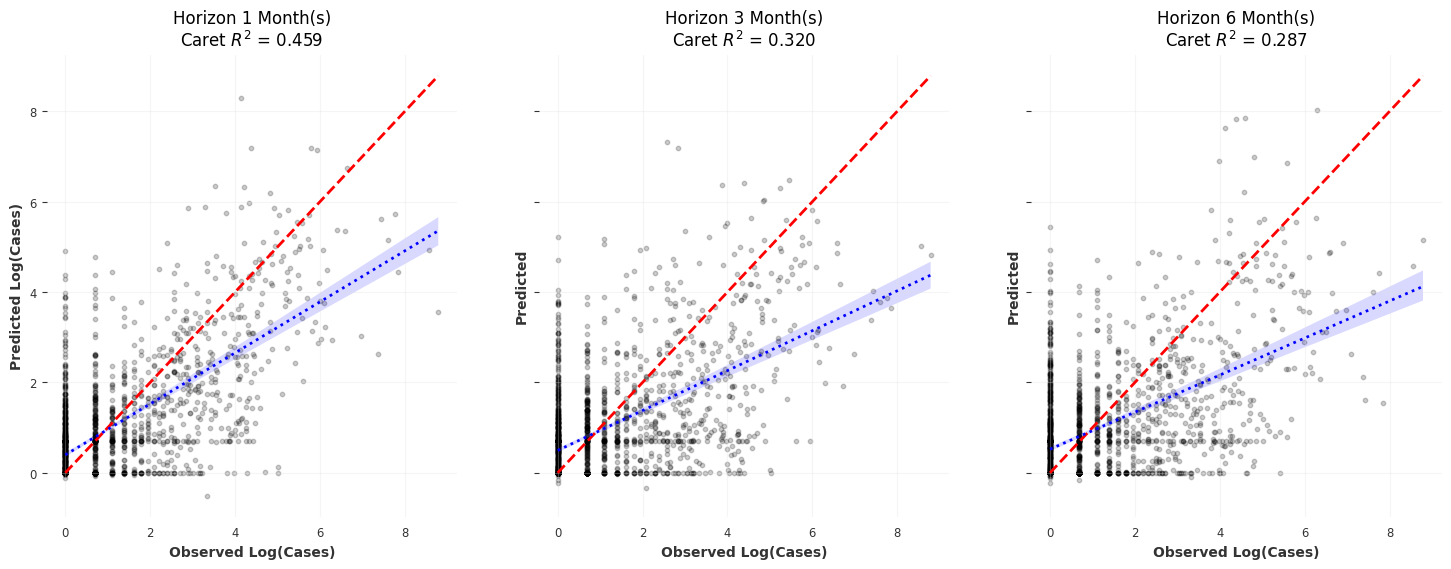

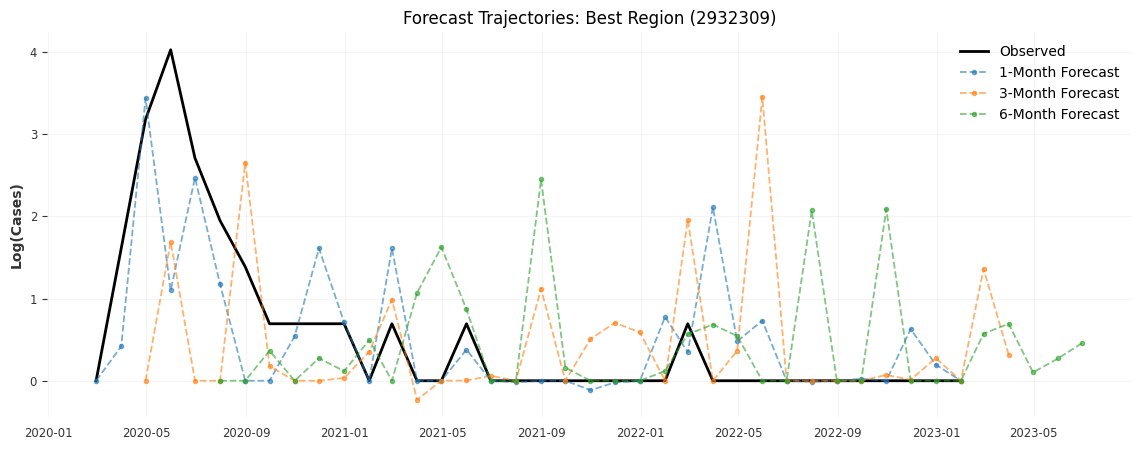

In [15]:

# =============================================================================
# 5. VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    # --- METRICS TABLE ---
    def get_metrics(x):
        return pd.Series({
            'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
            'Mean_WIS': x['WIS'].mean()
        })
    metrics = res_df.groupby('Horizon').apply(get_metrics)
    print("\n--- PERFORMANCE METRICS ---")
    print(metrics)

    # --- PLOT 1: Caret R2 Scatter ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, h in enumerate([1, 3, 6]):
        ax = axes[idx]
        sub = res_df[res_df['Horizon'] == h]
        r2 = caret_r2(sub['Actual'], sub['Predicted'])
        
        ax.scatter(sub['Actual'], sub['Predicted'], alpha=0.2, s=10, color='black')
        lims = [0, max(sub['Actual'].max(), sub['Predicted'].max())]
        ax.plot(lims, lims, 'r--', lw=2)
        sns.regplot(data=sub, x='Actual', y='Predicted', scatter=False, ax=ax, color='blue', line_kws={'linestyle':':'})
        
        ax.set_title(f"Horizon {h} Month(s)\nCaret $R^2$ = {r2:.3f}")
        ax.set_xlabel("Observed Log(Cases)")
        if idx == 0: ax.set_ylabel("Predicted Log(Cases)")
        ax.grid(True, alpha=0.3)
    plt.show()

    # --- PLOT 2: Trajectories (Best R2 Region) ---
    best_reg = res_df[res_df['Horizon']==1].groupby('Region').apply(lambda x: caret_r2(x['Actual'], x['Predicted'])).idxmax()
    reg_data = res_df[res_df['Region'] == best_reg]
    
    plt.figure(figsize=(14, 5))
    truth = reg_data[reg_data['Horizon']==1].sort_values('Target')
    plt.plot(truth['Target'], truth['Actual'], 'k-', lw=2, label='Observed')
    
    colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
    for h in [1, 3, 6]:
        h_data = reg_data[reg_data['Horizon'] == h].sort_values('Target')
        plt.plot(h_data['Target'], h_data['Predicted'], ls='--', marker='.', alpha=0.6, 
                 color=colors[h], label=f'{h}-Month Forecast')
    plt.title(f"Forecast Trajectories: Best Region ({best_reg})")
    plt.ylabel("Log(Cases)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("No forecasts generated.")

## NBeats/TFT Experiment


In [6]:
def calculate_wis_scalar(actual, q_dict):
    if pd.isna(actual): return np.nan
    qs = sorted(q_dict.keys())
    K = len(qs) // 2
    median = q_dict[0.5]
    wis_sum = 0.5 * abs(actual - median)
    for k in range(K):
        alpha = 2 * qs[k]
        L = q_dict[qs[k]]
        U = q_dict[qs[-(k+1)]]
        score = (U - L)
        if actual < L: score += (2/alpha) * (L - actual)
        if actual > U: score += (2/alpha) * (actual - U)
        wis_sum += score
    return wis_sum / (K + 0.5)

In [7]:
# Identify Columns
all_cols = df_final.columns.tolist()
hist_candidates = ['t2m', 'rh', 'tp', 'spei', 'pop_count', 'gdp_pc']
fc_cols = [c for c in all_cols if '_L' in c or '_fc' in c]
hist_cols = [c for c in hist_candidates if c in all_cols]

print(f"  Historical Covariates: {len(hist_cols)}")
print(f"  Forecast Covariates: {len(fc_cols)}")

# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
def prepare_region_series(region_id, df_all):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    # Static Covariate
    ts_target = ts_target.with_static_covariates(pd.Series([region_id], index=['RegionID']))
    
    # Past Covariates (History + Forecast Vectors)
    combined_cols = hist_cols + fc_cols
    if combined_cols:
        ts_past = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=combined_cols, freq='ME')
        ts_past = fill_missing_values(ts_past)
    else:
        ts_past = None
        
    # Future Covariates (Time Features)
    ts_future = datetime_attribute_timeseries(ts_target, attribute="month", cyclic=True)
    ts_future = ts_future.stack(datetime_attribute_timeseries(ts_target, attribute="year"))
    
    return ts_target, ts_past, ts_future

# =============================================================================
# 3. ROLLING FORECAST

# Robust extractor for probabilistic TimeSeries samples
def extract_samples_from_timeseries(ts):
    """
    Attempt to extract a numpy array of samples from a darts TimeSeries `ts`.
    Return shape: (num_samples, horizon, dim)
    Will raise ValueError if extraction fails.
    """
    # 1) ts.samples() -> often returns (num_samples, horizon, dim)
    try:
        if hasattr(ts, "samples") and callable(ts.samples):
            arr = np.asarray(ts.samples())
            if arr.ndim == 3:
                return arr
    except Exception:
        pass

    # 2) ts.pd_dataframe() and MultiIndex columns (samples encoded in column levels)
    try:
        df = ts.pd_dataframe()
        # If MultiIndex columns: common layout is (variable, sample_id)
        if isinstance(df.columns, pd.MultiIndex):
            # Determine which level encodes samples: try last level as sample id
            # We'll group by level index (assume last is sample id)
            sample_level = df.columns.nlevels - 1
            sample_ids = df.columns.get_level_values(sample_level).unique().tolist()
            samples = []
            for sid in sample_ids:
                # select all columns with this sample id across variable levels
                cols = [c for c in df.columns if c[sample_level] == sid]
                if not cols:
                    continue
                sub = df.loc[:, cols]
                # If sub has multiple columns per variable, keep their order; final shape (horizon, dim)
                samples.append(sub.values)
            if len(samples) > 0:
                arr = np.stack(samples, axis=0)  # (num_samples, horizon, dim)
                return arr
        else:
            # Non-multiindex: deterministic or single-sample probabilistic result
            arr = df.values  # shape (horizon, dim)
            return arr[np.newaxis, ...]  # (1, horizon, dim)
    except Exception:
        pass

    # 3) ts.values() or ts.all_values() heuristics
    try:
        # try all_values()
        if hasattr(ts, "all_values"):
            v = np.asarray(ts.all_values())
        else:
            v = np.asarray(ts.values())
        if v.ndim == 2:
            # (horizon, dim) -> single sample
            return v[np.newaxis, ...]
        if v.ndim == 3:
            # ambiguous axis ordering: try to detect which axis is samples
            # heuristics: samples axis typically >> horizon (e.g., 100s)
            shapes = v.shape
            # If first axis is large -> treat it as samples
            if shapes[0] >= max(shapes[1], shapes[2]):
                return v  # assume (num_samples, horizon, dim)
            # If last axis is largest -> move it to axis 0
            if shapes[-1] >= max(shapes[0], shapes[1]):
                return np.moveaxis(v, -1, 0)
            # else if middle axis is largest -> move middle to axis 0
            if shapes[1] >= max(shapes[0], shapes[2]):
                return np.moveaxis(v, 1, 0)
            # fallback: return as-is (hoping it's correct)
            return v
    except Exception:
        pass

    # 4) give up
    raise ValueError("Could not extract samples from TimeSeries object; unrecognized layout")

# =============================================================================
# Select 10 High Volume Regions
valid_regs = df_final.groupby('Region')['Date'].count()
valid_regs = valid_regs[valid_regs >= 72].index.tolist()
target_regions = df_final[df_final.Region.isin(valid_regs)].groupby('Region')['Cases'].sum().sort_values(ascending=False).head(10).index.tolist()

print(f"\n--- PROCESSING {len(target_regions)} REGIONS ---")

start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

all_forecasts = []
if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

INPUT_CHUNK = 36 # three years
OUTPUT_CHUNK = 6
# Min length: Need Input + Output to train at least one sample
MIN_TRAIN_LEN = INPUT_CHUNK + OUTPUT_CHUNK + 2

for region in target_regions:
    print(f"Processing Region {region}...")
    
    ts_t, ts_p, ts_f = prepare_region_series(region, df_final)
    
    # Setup Models Container
    models = {
        'TFT': {'model': None, 'steps': 999},
        'NBEATS': {'model': None, 'steps': 999}
    }
    
    for cutoff in cutoffs:
        # 1. Length Check (Pre-split)
        # We check if the raw series up to cutoff is long enough
        if cutoff < ts_t.start_time() + pd.DateOffset(months=MIN_TRAIN_LEN): continue
        if cutoff > ts_t.end_time(): break
        
        # 2. Split (Raw Data)
        train_t, _ = ts_t.split_after(cutoff)
        train_p, _ = ts_p.split_after(cutoff) if ts_p else (None, None)
        train_f, _ = ts_f.split_after(cutoff) # Future covs are known, but we fit scaler on history
        
        # 3. Scale (FIT ON TRAIN ONLY -> PREVENTS LEAKAGE)
        scaler_t = Scaler()
        train_t_scaled = scaler_t.fit_transform(train_t)
        
        if train_p:
            scaler_p = Scaler()
            train_p_scaled = scaler_p.fit_transform(train_p)
        else: train_p_scaled = None
            
        scaler_f = Scaler()
        train_f_scaled = scaler_f.fit_transform(train_f)
        
        # N-BEATS Stack
        if train_p_scaled:
            train_nbeats_cov = train_p_scaled.stack(train_f_scaled)
        else:
            train_nbeats_cov = train_f_scaled

        # --- MODEL 1: TFT ---
        if models['TFT']['model'] is None or models['TFT']['steps'] >= 6:
            models['TFT']['model'] = TFTModel(
                input_chunk_length=INPUT_CHUNK, output_chunk_length=OUTPUT_CHUNK,
                hidden_size=64, lstm_layers=2, num_attention_heads=4,
                dropout=0.1, batch_size=16, 
                n_epochs=100, # Fixed, no early stopping
                likelihood=QuantileRegression(quantiles=QUANTILES),
                random_state=42, force_reset=True,
                pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
            )
            try:
                models['TFT']['model'].fit(
                    series=train_t_scaled,
                    past_covariates=train_p_scaled,
                    future_covariates=train_f_scaled,
                    verbose=False
                )
                models['TFT']['steps'] = 0
            except: 
                models['TFT']['model'] = None
        else: models['TFT']['steps'] += 1
            
        # --- MODEL 2: N-BEATS ---
        if models['NBEATS']['model'] is None or models['NBEATS']['steps'] >= 6:
            models['NBEATS']['model'] = NBEATSModel(
                input_chunk_length=INPUT_CHUNK, output_chunk_length=OUTPUT_CHUNK,
                num_stacks=10, num_blocks=1, num_layers=4, layer_widths=256,
                dropout=0.1, batch_size=16, 
                n_epochs=100,
                likelihood=QuantileRegression(quantiles=QUANTILES),
                random_state=42, force_reset=True,
                pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
            )
            try:
                models['NBEATS']['model'].fit(
                    series=train_t_scaled,
                    past_covariates=train_nbeats_cov,
                    verbose=False
                )
                models['NBEATS']['steps'] = 0
            except: models['NBEATS']['model'] = None
        else: models['NBEATS']['steps'] += 1
        
        # --- PREDICT ---
        for m_name, m_dict in models.items():
            model = m_dict['model']
            if model is None: continue
            
            try:
                if m_name == 'TFT':
                    # TFT needs 'future_covariates' extended into the future
                    # Since ts_f is calendar features, we can generate/use the full original series 
                    # truncated to cutoff + horizon
                    fut_cov_horizon = ts_f.slice(ts_f.start_time(), cutoff + pd.DateOffset(months=OUTPUT_CHUNK))
                    fut_cov_scaled = scaler_f.transform(fut_cov_horizon)
                    
                    pred = model.predict(n=OUTPUT_CHUNK, series=train_t_scaled, 
                                         past_covariates=train_p_scaled, 
                                         future_covariates=fut_cov_scaled, 
                                         num_samples=500, verbose=False)
                else:
                    # N-BEATS assumes 'past' covariates. We just pass the training covariance stack.
                    # N-BEATS doesn't technically use 'future' inputs unless lagged/shifted.
                    # Here we rely on the autoregressive nature + past correlations.
                    pred = model.predict(n=OUTPUT_CHUNK, series=train_t_scaled, 
                                         past_covariates=train_nbeats_cov, 
                                         num_samples=500, verbose=False)
                
                # Inverse Transform
                pred_inv = scaler_t.inverse_transform(pred)
                
                # EXTRACT SAMPLES (Your Logic)
                try:
                    samples_arr = extract_samples_from_timeseries(pred_inv) # (nsamples, horizon, dim)
                except: continue
                
                # Ensure shape (500, 6, 1)
                if samples_arr.ndim == 3 and samples_arr.shape[2] == 1:
                    samples_arr = samples_arr[:, :, 0] # (500, 6)
                
                for h in [1, 3, 6]:
                    step = h - 1
                    
                    # Extract sample vector for this step
                    samp = samples_arr[:, step] # (500,)
                    
                    q50 = float(np.quantile(samp, 0.5))
                    q_dict = {q: float(np.quantile(samp, q)) for q in QUANTILES}
                    
                    try: 
                        fc_date = pred_inv.time_index[step]
                        act = ts_t[fc_date].values()[0][0]
                    except: 
                        act = np.nan
                    
                    wis = calculate_wis_scalar(act, q_dict)
                    
                    all_forecasts.append({
                        'Region': region, 'Model': m_name, 'Origin': cutoff, 'Target': fc_date,
                        'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
                    })
                    
            except Exception as e:
                # print(f"Pred Error: {e}")
                pass
    
    if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 4. VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    print("\n--- PERFORMANCE BY MODEL ---")
    metrics = res_df.groupby(['Model', 'Horizon']).apply(lambda x: pd.Series({
        'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
        'Mean_WIS': x['WIS'].mean()
    }))
    print(metrics)

    g = sns.FacetGrid(res_df, col="Horizon", row="Model", margin_titles=True, height=4)
    g.map(sns.scatterplot, "Actual", "Predicted", alpha=0.2, color='black', s=15)
    def add_line(x, y, **kwargs):
        plt.plot([min(x.min(), y.min()), max(x.max(), y.max())], [min(x.min(), y.min()), max(x.max(), y.max())], 'r--', lw=2)
    g.map(add_line, "Actual", "Predicted")
    plt.show()

    # Trajectories (Best TFT)
    tft_res = res_df[res_df['Model']=='TFT']
    if not tft_res.empty:
        best_reg = tft_res.groupby('Region')['WIS'].mean().idxmin()
        plt.figure(figsize=(14, 6))
        reg_data = tft_res[tft_res['Region'] == best_reg]
        truth = reg_data[reg_data.Horizon==1].sort_values('Target')
        plt.plot(truth.Target, truth.Actual, 'k-', lw=2, label='Observed')
        
        colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
        for h in [1, 3, 6]:
            h_data = reg_data[reg_data.Horizon==h].sort_values('Target')
            plt.plot(h_data.Target, h_data.Predicted, ls='--', marker='.', alpha=0.6, color=colors[h], label=f'TFT {h}-Mo')
        plt.title(f"TFT Forecasts: Region {best_reg}")
        plt.legend(); plt.show()
else:
    print("No forecasts generated.")

  Historical Covariates: 4
  Forecast Covariates: 30

--- PROCESSING 10 REGIONS ---
Processing Region 3106200...


NameError: name 'TFTModel' is not defined

In [ ]:
# # Reconstruct Columns (Flattened Forecasts)
# fc_cols = [c for c in df_final.columns if '_L' in c or '_fc' in c]
# hist_cols = ['t2m', 'rh', 'tp', 'spei']
# valid_hist = [c for c in hist_cols if c in df.columns]

# # =============================================================================
# # 2. FEATURE ENGINEERING
# # =============================================================================
# def prepare_region_series(region_id, df_all, feature_subset=None):
#     df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
#     # Target: Log Scale (NO SCALER will be applied to this)
#     df_reg['LogCases'] = np.log1p(df_reg['Cases'])
#     ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
#     ts_target = fill_missing_values(ts_target)
    
#     # Covariates
#     numeric = df_reg.select_dtypes(include=[np.number])
#     available = [c for c in numeric.columns if c not in ['Region', 'Cases', 'LogCases']]
    
#     if feature_subset:
#         cols = [c for c in feature_subset if c in available]
#     else:
#         cols = available
        
#     cols_past = [c for c in cols if '_fc' not in c]
#     cols_future = [c for c in cols if '_fc' in c]
    
#     ts_past = None
#     if cols_past:
#         ts_past = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=cols_past, freq='ME')
#         ts_past = fill_missing_values(ts_past)
        
#     ts_future = None
#     if cols_future:
#         ts_future = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=cols_future, freq='ME')
#         ts_future = fill_missing_values(ts_future)
        
#     return ts_target, ts_past, ts_future

# # =============================================================================
# # 3. PHASE 1: FEATURE SELECTION (Pilot)
# # =============================================================================
# pilot_region = df_final.groupby('Region')['Cases'].sum().idxmax()
# print(f"\n--- PHASE 1: FEATURE SELECTION (Pilot: {pilot_region}) ---")

# # Candidate Sets
# sets = {
#     'Hist_Only': valid_hist,
#     'Combined': valid_hist + fc_cols
# }

# QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
# tuning_res = []
# split_date = pd.Timestamp("2020-01-01")

# for name, cols in sets.items():
#     if not cols: continue
    
#     ts_t, ts_p, ts_f = prepare_region_series(pilot_region, df_final, cols)
    
#     # Scale Covariates Only
#     scaler_p = Scaler()
#     ts_p_sc = scaler_p.fit_transform(ts_p) if ts_p else None
#     scaler_f = Scaler()
#     ts_f_sc = scaler_f.fit_transform(ts_f) if ts_f else None
    
#     train, _ = ts_t.split_after(split_date)
    
#     model = XGBModel(
#         lags=12,
#         lags_past_covariates=12 if ts_p_sc else None,
#         lags_future_covariates=[0] if ts_f_sc else None,
#         output_chunk_length=6,
#         likelihood="quantile", quantiles=QUANTILES,
#         random_state=42
#     )
    
#     try:
#         model.fit(series=train, past_covariates=ts_p_sc, future_covariates=ts_f_sc)
        
#         # Predict Samples
#         pred = model.predict(n=6, series=train, past_covariates=ts_p_sc, future_covariates=ts_f_sc, num_samples=200, verbose=False)
        
#         # Eval
#         # Direct extraction (No inverse transform on target needed)
#         vals = pred.values()
#         if vals.ndim == 3: medians = np.quantile(vals[:, 0, :], 0.5, axis=1)
#         else: medians = np.quantile(vals, 0.5, axis=1)
            
#         actuals = ts_t.slice(pred.start_time(), pred.end_time()).values().flatten()
#         err = np.mean(np.abs(medians - actuals))
#         tuning_res.append({'Set': name, 'Columns': cols, 'MAE': err})
#         print(f"  Set {name}: MAE={err:.4f}")
        
#     except Exception as e:
#         print(f"  Set {name} Failed: {e}")

# if not tuning_res:
#     print("  Tuning Failed. Using Hist_Only.")
#     best_cols = valid_hist
# else:
#     best_res = sorted(tuning_res, key=lambda x: x['MAE'])[0]
#     best_cols = best_res['Columns']
#     print(f"\nWINNER: {best_res['Set']}")

# # =============================================================================
# # 4. PHASE 2: ROLLOUT (50 Regions)
# # =============================================================================
# # Select 50 Regions
# valid_regions = df_final.groupby('Region')['Date'].count()
# valid_regions = valid_regions[valid_regions >= 72].index.tolist()
# n_regions = min(1, len(valid_regions))
# target_regions = np.random.choice(valid_regions, n_regions, replace=False)

# print(f"\n--- PHASE 2: ROLLING FORECAST ({n_regions} REGIONS) ---")

# start_date = pd.Timestamp("2020-01-31")
# end_date   = pd.Timestamp("2022-12-31")
# cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

# all_forecasts = []

# for region in target_regions:
#     # Data
#     ts_t, ts_p, ts_f = prepare_region_series(region, df_final, best_cols)
    
#     # Scale Covariates Only
#     scaler_p = Scaler()
#     ts_p_sc = scaler_p.fit_transform(ts_p) if ts_p else None
#     scaler_f = Scaler()
#     ts_f_sc = scaler_f.fit_transform(ts_f) if ts_f else None
    
#     # Note: We do NOT scale ts_t (Target). It is already Log scale.
    
#     model = None
#     months_since_refit = 999
    
#     for cutoff in cutoffs:
#         if cutoff < ts_t.start_time() + pd.DateOffset(months=24): continue
#         if cutoff > ts_t.end_time(): break
        
#         # REFIT
#         if model is None or months_since_refit >= 6:
#             train, _ = ts_t.split_after(cutoff)
            
#             model = XGBModel(
#                 lags=24,
#                 lags_past_covariates=12 if ts_p_sc else None,
#                 lags_future_covariates=[0] if ts_f_sc else None,
#                 output_chunk_length=6,
#                 likelihood="quantile", quantiles=QUANTILES,
#                 random_state=42, n_estimators=100
#             )
#             try:
#                 model.fit(series=train, past_covariates=ts_p_sc, future_covariates=ts_f_sc)
#                 months_since_refit = 0
#             except:
#                 model = None
#                 continue
#         else:
#             months_since_refit += 1
            
#         if model is None: continue
        
#         # PREDICT (Samples)
#         try:
#             context_t = ts_t.split_after(cutoff)[0]
            
#             # 1. Predict Samples (NO INVERSE TRANSFORM NEEDED for Target)
#             pred_samples = model.predict(
#                 n=6, 
#                 series=context_t, 
#                 past_covariates=ts_p_sc, 
#                 future_covariates=ts_f_sc,
#                 num_samples=500, # <--- 500 Samples
#                 verbose=False
#             )
            
#             # 2. Extract Values directly
#             vals = pred_samples.values() 
#             # Darts shape for samples: (Time, Components=1, Samples=500)
            
#             for h in [1, 3, 6]:
#                 step = h - 1
#                 fc_date = pred_samples.time_index[step]
                
#                 # --- ROBUST EXTRACTION (USER'S CODE) ---
#                 if vals.ndim == 3:
#                     # (Time, Component, Samples) -> Extract Samples
#                     samples_at_step = vals[step, 0, :]
#                 else:
#                     # (Time, Samples)
#                     samples_at_step = vals[step, :]
#                 # -------------------------
                
#                 # Quantiles FROM Samples
#                 q05 = np.quantile(samples_at_step, 0.05)
#                 q50 = np.quantile(samples_at_step, 0.50)
#                 q95 = np.quantile(samples_at_step, 0.95)
                
#                 try: act = ts_t[fc_date].values()[0][0]
#                 except: act = np.nan
                
#                 q_dict = {q: np.quantile(samples_at_step, q) for q in QUANTILES}
#                 wis = calculate_wis_scalar(act, q_dict)
                
#                 all_forecasts.append({
#                     'Region': region, 'Origin': cutoff, 'Target': fc_date,
#                     'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
#                 })
                
#         except Exception as e:
#             # print(f"Err: {e}")
#             continue
            
#     if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# # =============================================================================
# # 5. VISUALIZATION
# # =============================================================================
# res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
# print(f"\nTotal Forecasts: {len(res_df)}")

# if len(res_df) > 0:
#     metrics = res_df.groupby('Horizon').apply(lambda x: pd.Series({
#         'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
#         'Mean_WIS': x['WIS'].mean()
#     }))
#     print("\n--- METRICS ---")
#     print(metrics)

#     fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
#     for idx, h in enumerate([1, 3, 6]):
#         ax = axes[idx]
#         sub = res_df[res_df['Horizon'] == h]
#         r2 = caret_r2(sub['Actual'], sub['Predicted'])
#         ax.scatter(sub['Actual'], sub['Predicted'], alpha=0.1, color='black', s=10)
#         lims = [0, max(sub['Actual'].max(), sub['Predicted'].max())]
#         ax.plot(lims, lims, 'r--', lw=2)
#         ax.set_title(f"Horizon {h}\n$R^2$={r2:.3f}")
#         ax.grid(True, alpha=0.3)
#     plt.suptitle("Observed vs Predicted (XGBoost)", fontsize=16)
#     plt.show()

#     # Heatmap
#     res_df['Year'] = res_df['Target'].dt.year
#     hm = res_df[res_df['Horizon'] == 1].pivot_table(index='Region', columns='Year', values='WIS', aggfunc='mean')
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(hm, cmap='magma_r', annot=False, cbar_kws={'label': 'WIS'})
#     plt.title("WIS Heatmap")
#     plt.show()

# else:
#     print("No forecasts generated.")

  Past Covariates (History + Forecast Vectors): 34


In [ ]:
def to_month_end(date_series):
    return pd.to_datetime(date_series) + pd.offsets.MonthEnd(0)

# Robust extractor for probabilistic TimeSeries samples
def extract_samples_from_timeseries(ts):
    """
    Attempt to extract a numpy array of samples from a darts TimeSeries `ts`.
    Return shape: (num_samples, horizon, dim)
    Will raise ValueError if extraction fails.
    """
    # 1) ts.samples() -> often returns (num_samples, horizon, dim)
    try:
        if hasattr(ts, "samples") and callable(ts.samples):
            arr = np.asarray(ts.samples())
            if arr.ndim == 3:
                return arr
    except Exception:
        pass

    # 2) ts.pd_dataframe() and MultiIndex columns (samples encoded in column levels)
    try:
        df = ts.pd_dataframe()
        # If MultiIndex columns: common layout is (variable, sample_id)
        if isinstance(df.columns, pd.MultiIndex):
            # Determine which level encodes samples: try last level as sample id
            # We'll group by level index (assume last is sample id)
            sample_level = df.columns.nlevels - 1
            sample_ids = df.columns.get_level_values(sample_level).unique().tolist()
            samples = []
            for sid in sample_ids:
                # select all columns with this sample id across variable levels
                cols = [c for c in df.columns if c[sample_level] == sid]
                if not cols:
                    continue
                sub = df.loc[:, cols]
                # If sub has multiple columns per variable, keep their order; final shape (horizon, dim)
                samples.append(sub.values)
            if len(samples) > 0:
                arr = np.stack(samples, axis=0)  # (num_samples, horizon, dim)
                return arr
        else:
            # Non-multiindex: deterministic or single-sample probabilistic result
            arr = df.values  # shape (horizon, dim)
            return arr[np.newaxis, ...]  # (1, horizon, dim)
    except Exception:
        pass

    # 3) ts.values() or ts.all_values() heuristics
    try:
        # try all_values()
        if hasattr(ts, "all_values"):
            v = np.asarray(ts.all_values())
        else:
            v = np.asarray(ts.values())
        if v.ndim == 2:
            # (horizon, dim) -> single sample
            return v[np.newaxis, ...]
        if v.ndim == 3:
            # ambiguous axis ordering: try to detect which axis is samples
            # heuristics: samples axis typically >> horizon (e.g., 100s)
            shapes = v.shape
            # If first axis is large -> treat it as samples
            if shapes[0] >= max(shapes[1], shapes[2]):
                return v  # assume (num_samples, horizon, dim)
            # If last axis is largest -> move it to axis 0
            if shapes[-1] >= max(shapes[0], shapes[1]):
                return np.moveaxis(v, -1, 0)
            # else if middle axis is largest -> move middle to axis 0
            if shapes[1] >= max(shapes[0], shapes[2]):
                return np.moveaxis(v, 1, 0)
            # fallback: return as-is (hoping it's correct)
            return v
    except Exception:
        pass

    # 4) give up
    raise ValueError("Could not extract samples from TimeSeries object; unrecognized layout")

# =============================================================================
# 1. LOAD DATA
# =============================================================================
print("Step 1: Loading Data...")

# Identify Columns
all_cols = df_final.columns.tolist()
hist_candidates = ['t2m', 'rh', 'tp', 'spei', 'pop_count', 'gdp_pc']
fc_cols = [c for c in all_cols if '_L' in c or '_fc' in c]
hist_cols = [c for c in hist_candidates if c in all_cols]

print(f"  Historical Covariates: {len(hist_cols)}")
print(f"  Forecast Covariates (Flattened): {len(fc_cols)}")

# =============================================================================
# 2. FEATURE ENGINEERING
# =============================================================================
def prepare_region_series(region_id, df_all):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')

    # Target
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)

    # Static
    ts_target = ts_target.with_static_covariates(pd.Series([region_id], index=['RegionID']))

    # Past (History + Forecast Vectors)
    combined_cols = hist_cols + fc_cols
    if combined_cols:
        ts_past = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=combined_cols, freq='ME')
        ts_past = fill_missing_values(ts_past)
    else:
        ts_past = None

    # Future (Time Features)
    ts_future = datetime_attribute_timeseries(ts_target, attribute="month", cyclic=True)
    ts_future = ts_future.stack(datetime_attribute_timeseries(ts_target, attribute="year"))

    return ts_target, ts_past, ts_future

# =============================================================================
# 3. ROLLING FORECAST
# =============================================================================
valid_regs = df_final.groupby('Region')['Date'].count()
valid_regs = valid_regs[valid_regs >= 72].index.tolist()
target_regions = df_final[df_final.Region.isin(valid_regs)].groupby('Region')['Cases'].sum().sort_values(ascending=False).head(5).index.tolist()

print(f"\n--- PROCESSING {len(target_regions)} REGIONS ---")

start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

all_forecasts = []
if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# Define Model Parameters
INPUT_CHUNK = 48
OUTPUT_CHUNK = 6
# Minimum required is roughly input + output to train
MIN_TRAIN_LEN = INPUT_CHUNK + OUTPUT_CHUNK + 2

for region in target_regions:
    print(f"Processing Region {region}...")

    ts_t, ts_p, ts_f = prepare_region_series(region, df_final)

    # Scale
    scaler_t = Scaler()
    ts_t_scaled = scaler_t.fit_transform(ts_t)

    scaler_p = Scaler()
    ts_p_scaled = scaler_p.fit_transform(ts_p) if ts_p else None

    scaler_f = Scaler()
    ts_f_scaled = scaler_f.fit_transform(ts_f)

    # N-BEATS Covariates (Stacked)
    if ts_p_scaled:
        ts_nbeats_cov = ts_p_scaled.stack(ts_f_scaled)
    else:
        ts_nbeats_cov = ts_f_scaled

    models = {
        'TFT': {'model': None, 'steps': 999},
        'NBEATS': {'model': None, 'steps': 999}
    }

    for cutoff in cutoffs:
        # Length Check
        if cutoff < ts_t_scaled.start_time() + pd.DateOffset(months=MIN_TRAIN_LEN): continue
        if cutoff > ts_t_scaled.end_time(): break

        # Split (Train includes cutoff)
        full_train, _ = ts_t_scaled.split_after(cutoff)

        # --- MODEL 1: TFT ---
        if models['TFT']['model'] is None or models['TFT']['steps'] >= 6:
            models['TFT']['model'] = TFTModel(
                input_chunk_length=INPUT_CHUNK, output_chunk_length=OUTPUT_CHUNK,
                hidden_size=64, lstm_layers=2, num_attention_heads=4,
                dropout=0.1, batch_size=16,
                n_epochs=100, # Fixed epochs (No Early Stopping)
                likelihood=QuantileRegression(quantiles=QUANTILES),
                random_state=42, force_reset=True,
                pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
            )
            try:
                models['TFT']['model'].fit(
                    series=full_train, # Train on ALL available data
                    past_covariates=ts_p_scaled,
                    future_covariates=ts_f_scaled,
                    verbose=False
                )
                models['TFT']['steps'] = 0
            except Exception:
                models['TFT']['model'] = None
        else: models['TFT']['steps'] += 1

        # --- MODEL 2: N-BEATS ---
        if models['NBEATS']['model'] is None or models['NBEATS']['steps'] >= 6:
            models['NBEATS']['model'] = NBEATSModel(
                input_chunk_length=INPUT_CHUNK, output_chunk_length=OUTPUT_CHUNK,
                num_stacks=10, num_blocks=2, num_layers=4, layer_widths=256,
                dropout=0.1, batch_size=32,
                n_epochs=20, # Fixed epochs
                likelihood=QuantileRegression(quantiles=QUANTILES),
                random_state=42, force_reset=True,
                pl_trainer_kwargs={"accelerator": "cpu", "enable_progress_bar": False}
            )
            try:
                models['NBEATS']['model'].fit(
                    series=full_train, # Train on ALL available data
                    past_covariates=ts_nbeats_cov,
                    verbose=False
                )
                models['NBEATS']['steps'] = 0
            except Exception:
                models['NBEATS']['model'] = None
        else: models['NBEATS']['steps'] += 1

        # --- PREDICT ---
        for m_name, m_dict in models.items():
            model = m_dict['model']
            if model is None: continue

            try:
                if m_name == 'TFT':
                    pred = model.predict(n=OUTPUT_CHUNK, series=full_train,
                                         past_covariates=ts_p_scaled,
                                         future_covariates=ts_f_scaled,
                                         num_samples=500, verbose=False)
                else:
                    pred = model.predict(n=OUTPUT_CHUNK, series=full_train,
                                         past_covariates=ts_nbeats_cov,
                                         num_samples=500, verbose=False)

                # inverse-transform the TimeSeries (works even if pred is probabilistic)
                pred_inv = scaler_t.inverse_transform(pred)

                # extract samples as numpy array shape (num_samples, horizon, dim)
                try:
                    samples_arr = extract_samples_from_timeseries(pred_inv)
                except ValueError:
                    # couldn't parse samples; skip this prediction
                    continue

                # ensure shape is (num_samples, horizon, dim)
                if samples_arr.ndim != 3:
                    continue
                nsamples, horizon, ndim = samples_arr.shape
                # If multiple dims (rare), pick first
                if ndim > 1:
                    samples_arr = samples_arr[:, :, 0]
                    samples_arr = samples_arr[:, :, np.newaxis]
                    nsamples, horizon, ndim = samples_arr.shape

                # For each horizon step build quantiles and append forecast row
                for h in [1, 3, 6]:
                    step = h - 1
                    if step >= horizon:
                        continue
                    # time index for this forecast step
                    try:
                        fc_date = pred_inv.time_index[step]
                    except Exception:
                        # fallback to cutoff + months
                        fc_date = cutoff + pd.DateOffset(months=h)

                    # samples for this step: shape (nsamples,)
                    samp = samples_arr[:, step, 0]

                    q50 = float(np.quantile(samp, 0.5))
                    q_dict = {q: float(np.quantile(samp, q)) for q in QUANTILES}

                    try:
                        act = ts_t[fc_date].values()[0][0]
                    except Exception:
                        act = np.nan

                    wis = calculate_wis_scalar(act, q_dict)
                    # print(f"\nWIS: {wis}")

                    all_forecasts.append({
                        'Region': region, 'Model': m_name, 'Origin': cutoff, 'Target': fc_date,
                        'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
                    })

            except Exception:
                # keep going if a single predict fails
                # uncomment for debugging:
                # print(f"Prediction error for region {region}, model {m_name}, cutoff {cutoff}", flush=True)
                continue

    if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 4. VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    print("\n--- PERFORMANCE BY MODEL ---")
    metrics = res_df.groupby(['Model', 'Horizon']).apply(lambda x: pd.Series({
        'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
        'Mean_WIS': x['WIS'].mean()
    }))
    print(metrics)

    g = sns.FacetGrid(res_df, col="Horizon", row="Model", margin_titles=True, height=4)
    g.map(sns.scatterplot, "Actual", "Predicted", alpha=0.2, color='black', s=15)
    def add_line(x, y, **kwargs):
        plt.plot([min(x.min(), y.min()), max(x.max(), y.max())], [min(x.min(), y.min()), max(x.max(), y.max())], 'r--', lw=2)
    g.map(add_line, "Actual", "Predicted")
    g.set_axis_labels("Observed", "Predicted")
    plt.subplots_adjust(top=0.9)
    plt.suptitle("TFT vs N-BEATS Performance", fontsize=16)
    plt.show()

    # Trajectories (Best TFT Region)
    tft_res = res_df[res_df['Model']=='TFT']
    if not tft_res.empty:
        best_reg_tft = tft_res.groupby('Region')['WIS'].mean().idxmin()
        plt.figure(figsize=(14, 6))
        reg_data = tft_res[tft_res['Region'] == best_reg_tft]
        truth = reg_data[reg_data.Horizon==1].sort_values('Target')
        plt.plot(truth.Target, truth.Actual, 'k-', lw=2, label='Observed')

        colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
        for h in [1, 3, 6]:
            h_data = reg_data[reg_data.Horizon==h].sort_values('Target')
            plt.plot(h_data.Target, h_data.Predicted, ls='--', marker='.', alpha=0.6, color=colors[h], label=f'TFT {h}-Mo')
        plt.title(f"TFT Forecasts: Region {best_reg_tft}")
        plt.legend(); plt.show()

else:
    print("No forecasts generated.")


Step 1: Loading Data...
  Historical Covariates: 4
  Forecast Covariates (Flattened): 30

--- PROCESSING 5 REGIONS ---
Processing Region 3106200...
Processing Region 5208707...
Processing Region 3550308...
Processing Region 5300108...


## "Foundational" time series models
- Examples: Chronos from Amazon, TimesFM from Google.
- Chronos is available from Amazon + can be used with Darts syntax: https://unit8co.github.io/darts/generated_api/darts.models.forecasting.chronos2_model.html#darts.models.forecasting.chronos2_model.Chronos2Model
- TimesFM is simple to use, e.g. https://www.analyticsvidhya.com/blog/2024/09/timesfm/
- Use GPU for these, as will likely crash your device otherwise

In [ ]:
from darts.models import Chronos2Model
def prepare_region_series(region_id, df_all, feature_subset=None):
    df_reg = df_all[df_all['Region'] == region_id].sort_values('Date')
    
    # Target: Log Scale
    df_reg['LogCases'] = np.log1p(df_reg['Cases'])
    ts_target = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols='LogCases', freq='ME')
    ts_target = fill_missing_values(ts_target)
    
    cov_dict = {}
    
    # Define available raw columns
    available_cols = [c for c in df_reg.columns if c not in ['Region', 'Date', 'Cases', 'LogCases']]
    
    # If a specific subset is requested, filter for it
    if feature_subset:
        selected_cols = [c for c in feature_subset if c in available_cols]
    else:
        # Default bucket: All Weather + Socio
        selected_cols = [c for c in available_cols if c in ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count']]
    
    if selected_cols:
        ts_cov = TimeSeries.from_dataframe(df_reg, time_col='Date', value_cols=selected_cols, freq='ME')
        ts_cov = fill_missing_values(ts_cov)
    else:
        ts_cov = None
        
    return ts_target, ts_cov

# =============================================================================
# 3. PHASE 1: FEATURE SELECTION (Pilot Phase)
# =============================================================================
# We use a high-data region to select the best features
pilot_region = df_final.groupby('Region')['Cases'].sum().idxmax()
print(f"\n--- PHASE 1: FEATURE SELECTION (Pilot Region: {pilot_region}) ---")

# Define Candidate Feature Sets
feature_candidates = {
    'Minimal_Weather': ['t2m', 'tp'],
    'Standard_Weather': ['t2m', 'rh', 'tp'],
    'Full_Weather': ['t2m', 'rh', 'tp', 'spei'],
    'Weather_Socio': ['t2m', 'rh', 'tp', 'spei', 'gdp_pc', 'pop_count'],
    'Univariate': [] # No covariates
}

# Training Split for Tuning: Train 2015-2019, Validate 2020
split_date = pd.Timestamp("2020-01-01")
tuning_results = []

# Prepare Pilot Data
_, full_covs_ts = prepare_region_series(pilot_region, df_final) # Just to check availability

for name, cols in feature_candidates.items():
    print(f"  Testing Feature Set: {name} {cols}...")
    
    # Get Series
    ts_t, ts_c = prepare_region_series(pilot_region, df_final, feature_subset=cols)
    
    # Scale
    scaler_t = Scaler()
    ts_t_scaled = scaler_t.fit_transform(ts_t)
    
    if ts_c:
        scaler_c = Scaler()
        ts_c_scaled = scaler_c.fit_transform(ts_c)
    else:
        ts_c_scaled = None
        
    # Split
    train, val = ts_t_scaled.split_before(split_date)
    val = val.slice(split_date, split_date + pd.DateOffset(months=11)) # 1 Year Val
    val_log = ts_t.slice(val.start_time(), val.end_time()) # Unscaled target for WIS
    
    # Model (Fixed Hyperparams for fairness)
    model = Chronos2Model(input_chunk_length=24, output_chunk_length=6, likelihood = QuantileRegression())

    try:
        model.fit(series=train, past_covariates=ts_c_scaled,  verbose=False)
        
        # Predict 2020 (Rolling 6-month windows)
        hf = model.historical_forecasts(
            series=ts_t_scaled, past_covariates=ts_c_scaled,
            start=split_date, forecast_horizon=6, stride=6,
            retrain=False, verbose=False, num_samples=200
        )
        
        # Calc WIS
        pred_log = scaler_t.inverse_transform(hf)
        vals = pred_log.values()
        if vals.ndim == 3: vals = vals[:, 0, :]
        
        total_wis = 0
        steps = min(len(pred_log), len(val_log))
        
        for t in range(steps):
            samp = vals[t, :]
            q_dict = {q: np.quantile(samp, q) for q in [0.05, 0.5, 0.95]}
            act = val_log[t].values()[0][0]
            total_wis += calculate_wis_scalar(act, q_dict)
            
        avg_wis = total_wis / steps
        tuning_results.append({'Features': name, 'Columns': cols, 'WIS': avg_wis})
        print(f"    -> WIS: {avg_wis:.4f}")
        
    except Exception as e:
        print(f"    -> Failed: {e}")

# Select Best Features
if not tuning_results:
    best_features = ['t2m', 'rh', 'tp', 'spei'] # Fallback
    best_feat_name = "Full_Weather (Fallback)"
else:
    best_row = sorted(tuning_results, key=lambda x: x['WIS'])[0]
    best_features = best_row['Columns']
    best_feat_name = best_row['Features']

print(f"\nWINNING FEATURE SET: {best_feat_name}")
print(f"Columns: {best_features}")

# Cleanup logs
if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 4. PHASE 2: MAIN ROLLOUT (50 Regions, Refit Every 6 Months)
# =============================================================================
# Select 50 Random Regions
n_regions = min(50, len(valid_regions))
target_regions = np.random.choice(valid_regions, n_regions, replace=False)
print(f"\n--- PHASE 2: ROLLING FORECAST ({n_regions} REGIONS) ---")
print("Strategy: Stride=1 Month, Refit=Every 6 Months")

# Forecast Period: 2020-01-31 to 2022-12-31
start_date = pd.Timestamp("2020-01-31")
end_date   = pd.Timestamp("2022-12-31")
cutoffs = pd.date_range(start=start_date, end=end_date, freq='ME')

all_forecasts = []
QUANTILES = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

for region in tqdm(target_regions, desc="Regions"):
    # Data Prep (Using Best Features)
    ts_raw, ts_cov = prepare_region_series(region, df_final, feature_subset=best_features)
    
    scaler_tgt = Scaler()
    ts_scaled = scaler_tgt.fit_transform(ts_raw)
    ts_cov_scaled = Scaler().fit_transform(ts_cov) if ts_cov else None
    
    # Model State Tracking
    model = None
    steps_since_refit = 999 
    
    # Rolling Loop (Monthly Stride)
    for cutoff in cutoffs:
        if cutoff < ts_scaled.start_time() + pd.DateOffset(months=24): continue
        if cutoff > ts_scaled.end_time(): break
        
        # --- REFIT STRATEGY ---
        # Refit if: First run OR 6 months passed since last refit
        # (Using month modulo logic ensures alignment: Jan(1), Jul(7))
        # Or simpler: just count steps
        if model is None or steps_since_refit >= 6:
            # print(f"  [Region {region}] Refitting at {cutoff.date()}...")
            
            # SPLIT: Train includes cutoff
            train, _ = ts_scaled.split_after(cutoff)
            
            # Initialize Fresh Model
            model = Chronos2Model(input_chunk_length=24, output_chunk_length=6, likelihood = QuantileRegression())

            
            try:
                model.fit(series=train, past_covariates=ts_cov_scaled)
                steps_since_refit = 0
            except:
                model = None # Reset if fail
                continue
        else:
            # No Refit: Just increment counter
            # The model object retains weights. Darts 'predict' uses the passed series for context.
            steps_since_refit += 1
            
        if model is None: continue

        # PREDICT
        # We always provide the full series up to cutoff as context
        # Darts handles looking back 'input_chunk_length' from the end of the series provided
        context_series = ts_scaled.slice(ts_scaled.start_time(), cutoff)
        
        try:
            pred_samples = model.predict(
                n=6, 
                series=context_series, 
                past_covariates=ts_cov_scaled, 
                num_samples=500, 
                verbose=False
            )
            
            # Inverse & Store
            pred_inv = scaler_tgt.inverse_transform(pred_samples)
            vals = pred_inv.values()
            if vals.ndim == 3: vals = vals[:, 0, :]
            
            for h in [1, 3, 6]:
                step = h - 1
                if step >= len(pred_inv): break
                
                fc_date = pred_inv.time_index[step]
                samp = vals[step, :]
                
                q_dict = {q: np.quantile(samp, q) for q in QUANTILES}
                q50 = q_dict[0.5]
                
                try: act = ts_raw[fc_date].values()[0][0]
                except: act = np.nan
                
                wis = calculate_wis_scalar(act, q_dict)
                
                all_forecasts.append({
                    'Region': region, 'Origin': cutoff, 'Target': fc_date,
                    'Horizon': h, 'Actual': act, 'Predicted': q50, 'WIS': wis
                })
                
        except Exception as e:
            continue

    # Clean logs per region
    if os.path.exists('darts_logs'): shutil.rmtree('darts_logs')

# =============================================================================
# 5. VISUALIZATION
# =============================================================================
res_df = pd.DataFrame(all_forecasts).dropna(subset=['Actual'])
print(f"\nTotal Forecasts: {len(res_df)}")

if len(res_df) > 0:
    # --- METRICS TABLE ---
    def get_metrics(x):
        return pd.Series({
            'Caret_R2': caret_r2(x['Actual'], x['Predicted']),
            'Mean_WIS': x['WIS'].mean()
        })
    metrics = res_df.groupby('Horizon').apply(get_metrics)
    print("\n--- PERFORMANCE METRICS ---")
    print(metrics)

    # --- PLOT 1: Caret R2 Scatter ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for idx, h in enumerate([1, 3, 6]):
        ax = axes[idx]
        sub = res_df[res_df['Horizon'] == h]
        r2 = caret_r2(sub['Actual'], sub['Predicted'])
        
        ax.scatter(sub['Actual'], sub['Predicted'], alpha=0.2, s=10, color='black')
        lims = [0, max(sub['Actual'].max(), sub['Predicted'].max())]
        ax.plot(lims, lims, 'r--', lw=2)
        sns.regplot(data=sub, x='Actual', y='Predicted', scatter=False, ax=ax, color='blue', line_kws={'linestyle':':'})
        
        ax.set_title(f"Horizon {h} Month(s)\nCaret $R^2$ = {r2:.3f}")
        ax.set_xlabel("Observed Log(Cases)")
        if idx == 0: ax.set_ylabel("Predicted Log(Cases)")
        ax.grid(True, alpha=0.3)
    plt.show()

    # --- PLOT 2: Trajectories (Best R2 Region) ---
    best_reg = res_df[res_df['Horizon']==1].groupby('Region').apply(lambda x: caret_r2(x['Actual'], x['Predicted'])).idxmax()
    reg_data = res_df[res_df['Region'] == best_reg]
    
    plt.figure(figsize=(14, 5))
    truth = reg_data[reg_data['Horizon']==1].sort_values('Target')
    plt.plot(truth['Target'], truth['Actual'], 'k-', lw=2, label='Observed')
    
    colors = {1: '#1f77b4', 3: '#ff7f0e', 6: '#2ca02c'}
    for h in [1, 3, 6]:
        h_data = reg_data[reg_data['Horizon'] == h].sort_values('Target')
        plt.plot(h_data['Target'], h_data['Predicted'], ls='--', marker='.', alpha=0.6, 
                 color=colors[h], label=f'{h}-Month Forecast')
    plt.title(f"Forecast Trajectories: Best Region ({best_reg})")
    plt.ylabel("Log(Cases)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("No forecasts generated.")

# Joint Experiments
- We can fit many of these models to regions jointly
- See those that support multivariate series:  https://unit8co.github.io/darts/index.html#forecasting-models
- Disclaimer: dangerous for ML models that have no spatial reasoning built in. By definition, these overfit